# Analyse von Audio Dateien zur Erkennung des Geschlechts - Optimierung UC1
## 1. Einlesen einer csv Datei
Die Datei enthält alle zuvor extrahierten Audio Features und das Ziellabel Geschlecht.

In [1]:
!pip install boto3
!conda install dask -y
!pip install fsspec
#!pip install pandas==0.22 # für macOS
#!pip install s3fs # wenn S3 Bucket verwendet wird
!pip install sklearn
!pip install keras
!pip install tensorflow

Solving environment: done

# All requested packages already installed.



In [2]:
# Bibliotheken importieren
import os
from os import path
#from pydub import AudioSegment
import pandas as pd
import numpy as np
import time

In [3]:
ROOT_DIR = os.getcwd()
ROOT_DIR

'/home/sebastian/Schreibtisch/BDC'

In [4]:
import os
import boto3
import pandas as pd
import sys
from io import StringIO
import dask.dataframe as dd
import numpy as np

# lokaler CSV-Import
df = pd.read_csv (ROOT_DIR+'/features_extracted/FeaturesExtracted.csv', delimiter =';')

Für die weitere Verarbeitung werden alle Spaltennamen in eine Liste übernommen. Es werden nur die Spaltennamen der Audio Features beibehalten

In [5]:
# liste mit Überschriften erstellen aus eingelesenem DataFrame

list_cn = df.columns.values
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn

array(['zcr', 'energy', 'energy_entropy', 'spectral_centroid',
       'spectral_spread', 'spectral_entropy', 'spectral_flux',
       'spectral_rolloff', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4',
       'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
       'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2',
       'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7',
       'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12',
       'chroma_std'], dtype=object)

In der folgenden Schleife wird der DataFrame bearbeitet:
Es werden als String erkannte character ([]) entfernt.
Anschließend werden alle String - Werte eines Elements in ein NumPy Array gewandelt und in eine Liste zwischengespeichert.
Die Liste wird zurück in das Element das DataFrame geschrieben und der Median gebildet.
Dies ist notwendig um das richtige Format zur Eingabe in das Neuronale Netz zu erhalten.

In [6]:
nrows = len(df)

for i in range (0,nrows):
    for j in list_cn:
        list_c = df[j].iloc[i]
        list_c = list_c.replace('[','')
        list_c = list_c.replace(']','')
        list1 = np.fromstring (list_c, sep=' ',dtype=float)
        df[j].iat[i] = list1
        df[j].iat[i] = df[j].iloc[i].mean()
    if (i % 10000 == 0):
        print ("Reihe "+ str(i) + " fertig")
print ("Konvertierung abgeschlossen.")

Reihe 0 fertig
Reihe 10000 fertig
Reihe 20000 fertig
Reihe 30000 fertig
Reihe 40000 fertig
Reihe 50000 fertig
Konvertierung abgeschlossen.


Anschließend werden die nicht benötigten Spalten aus dem DataFrame entfernt

In [7]:
df.head()

Unnamed: 0  index                          path        age  gender  \
0           0      0  common_voice_de_17325303.mp3      teens  female   
1           1      1  common_voice_de_18201555.mp3   thirties  female   
2           2      2  common_voice_de_17340778.mp3  seventies  female   
3           3      3  common_voice_de_17340779.mp3  seventies  female   
4           4      4  common_voice_de_18001112.mp3   thirties  female   

                      file_wave        zcr     energy energy_entropy  \
0  common_voice_de_17325303.wav  0.0642394  0.0135318        3.02116   
1  common_voice_de_18201555.wav  0.0267417  0.0130014        2.77044   
2  common_voice_de_17340778.wav   0.105491  0.0121004        3.03186   
3  common_voice_de_17340779.wav  0.0785068  0.0224792        3.00399   
4  common_voice_de_18001112.wav  0.0639123  0.0228039        2.93814   

  spectral_centroid  ...    chroma_4    chroma_5    chroma_6   chroma_7  \
0           0.16407  ...  0.00934431  0.00991758  0.00562172  0.0287514   
1          0.132734  ...  0.00155354  0.00371185  0.00130747   0.189198   
2          0.152934  ...  0.00936951   0.0113756   0.0128234  0.0129994   
3          0.135851  ...  0.00868118   0.0148549   0.0350073  0.0311008   
4          0.125391  ...   0.0180194   0.0127522  0.00865218  0.0297006   

     chroma_8    chroma_9  chroma_10   chroma_11    chroma_12 chroma_std  
0    0.002562  0.00438808   0.011294   0.0194284   0.00393223  0.0291324  
1  0.00100479  0.00284188  0.0180358   0.0157503  0.000653381  0.0577428  
2  0.00375398   0.0122628  0.0134202  0.00987359   0.00372229  0.0145285  
3  0.00233811   0.0120349  0.0214039    0.023406   0.00720268  0.0240949  
4  0.00205647  0.00680324  0.0193026    0.032946   0.00766575  0.0291375  

[5 rows x 40 columns]

# 1. Optimierung Daten shuffeln (1=rows / 0=columns)


In [18]:
df2 = df.sample(frac=1)
df2.head()

Unnamed: 0  index                          path       age  gender  \
3711         3711   3711  common_voice_de_18716857.mp3  fourties  female   
48753       48753  48753  common_voice_de_18782476.mp3  twenties    male   
25484       25484  25484  common_voice_de_18710422.mp3  fourties  female   
51681       51681  51681  common_voice_de_18933240.mp3  twenties    male   
3029         3029   3029  common_voice_de_18770491.mp3   fifties  female   

                          file_wave        zcr      energy energy_entropy  \
3711   common_voice_de_18716857.wav  0.0214142   0.0213097        3.02807   
48753  common_voice_de_18782476.wav  0.0868328  0.00653177        2.83972   
25484  common_voice_de_18710422.wav  0.0850044  0.00545652         2.7955   
51681  common_voice_de_18933240.wav  0.0307609   0.0309637        2.92956   
3029   common_voice_de_18770491.wav  0.0809381   0.0225546        2.76427   

      spectral_centroid  ...    chroma_4    chroma_5    chroma_6    chroma_7  \
3711          0.0988764  ...   0.0145406   0.0187106   0.0113168   0.0697884   
48753          0.138058  ...  0.00339555   0.0111403  0.00224556     0.10356   
25484          0.141358  ...  0.00559811  0.00903746  0.00555054   0.0342378   
51681          0.102053  ...   0.0144388    0.037449  0.00458825    0.079511   
3029           0.137424  ...   0.0104321  0.00689467  0.00610149  0.00721291   

          chroma_8    chroma_9   chroma_10   chroma_11   chroma_12 chroma_std  
3711    0.00225628  0.00799252   0.0220585   0.0203905    0.002987  0.0517169  
48753   0.00118311  0.00366116   0.0044604  0.00975332  0.00348187   0.036375  
25484   0.00342062  0.00523418   0.0128849   0.0333927  0.00475754  0.0223909  
51681  0.000846618  0.00646697   0.0193591   0.0179341  0.00476945  0.0427239  
3029    0.00728058  0.00463849  0.00577075   0.0115272  0.00972634  0.0183229  

[5 rows x 40 columns]

In [19]:
# löschen der nicht benötigten Spalten
#!Änderung: df2 mit geshuffelten Daten

df_gesamt = df2.copy()
del df_gesamt['Unnamed: 0']
del df_gesamt['index']
del df_gesamt['path']
del df_gesamt['age']
del df_gesamt['file_wave']

In [20]:
df_gesamt.head()

gender        zcr      energy energy_entropy spectral_centroid  \
3711   female  0.0214142   0.0213097        3.02807         0.0988764   
48753    male  0.0868328  0.00653177        2.83972          0.138058   
25484  female  0.0850044  0.00545652         2.7955          0.141358   
51681    male  0.0307609   0.0309637        2.92956          0.102053   
3029   female  0.0809381   0.0225546        2.76427          0.137424   

      spectral_spread spectral_entropy spectral_flux spectral_rolloff  \
3711         0.173787         0.083665     0.0156697        0.0296678   
48753        0.135942         0.778188    0.00579213         0.134435   
25484        0.154939         0.540268    0.00649109         0.113065   
51681        0.163997         0.191762     0.0116433        0.0452326   
3029         0.146476         0.487985    0.00876359         0.104987   

        mfcc_1  ...    chroma_4    chroma_5    chroma_6    chroma_7  \
3711  -27.9129  ...   0.0145406   0.0187106   0.0113168   0.0697884   
48753 -30.1628  ...  0.00339555   0.0111403  0.00224556     0.10356   
25484 -30.6433  ...  0.00559811  0.00903746  0.00555054   0.0342378   
51681 -27.8529  ...   0.0144388    0.037449  0.00458825    0.079511   
3029  -29.2267  ...   0.0104321  0.00689467  0.00610149  0.00721291   

          chroma_8    chroma_9   chroma_10   chroma_11   chroma_12 chroma_std  
3711    0.00225628  0.00799252   0.0220585   0.0203905    0.002987  0.0517169  
48753   0.00118311  0.00366116   0.0044604  0.00975332  0.00348187   0.036375  
25484   0.00342062  0.00523418   0.0128849   0.0333927  0.00475754  0.0223909  
51681  0.000846618  0.00646697   0.0193591   0.0179341  0.00476945  0.0427239  
3029    0.00728058  0.00463849  0.00577075   0.0115272  0.00972634  0.0183229  

[5 rows x 35 columns]

In [21]:
df_data_x = df_gesamt
del df_gesamt['gender']
df_data_x.head()

zcr      energy energy_entropy spectral_centroid spectral_spread  \
3711   0.0214142   0.0213097        3.02807         0.0988764        0.173787   
48753  0.0868328  0.00653177        2.83972          0.138058        0.135942   
25484  0.0850044  0.00545652         2.7955          0.141358        0.154939   
51681  0.0307609   0.0309637        2.92956          0.102053        0.163997   
3029   0.0809381   0.0225546        2.76427          0.137424        0.146476   

      spectral_entropy spectral_flux spectral_rolloff   mfcc_1   mfcc_2  ...  \
3711          0.083665     0.0156697        0.0296678 -27.9129  2.96403  ...   
48753         0.778188    0.00579213         0.134435 -30.1628  1.01586  ...   
25484         0.540268    0.00649109         0.113065 -30.6433  1.59164  ...   
51681         0.191762     0.0116433        0.0452326 -27.8529   2.6254  ...   
3029          0.487985    0.00876359         0.104987 -29.2267  1.16929  ...   

         chroma_4    chroma_5    chroma_6    chroma_7     chroma_8  \
3711    0.0145406   0.0187106   0.0113168   0.0697884   0.00225628   
48753  0.00339555   0.0111403  0.00224556     0.10356   0.00118311   
25484  0.00559811  0.00903746  0.00555054   0.0342378   0.00342062   
51681   0.0144388    0.037449  0.00458825    0.079511  0.000846618   
3029    0.0104321  0.00689467  0.00610149  0.00721291   0.00728058   

         chroma_9   chroma_10   chroma_11   chroma_12 chroma_std  
3711   0.00799252   0.0220585   0.0203905    0.002987  0.0517169  
48753  0.00366116   0.0044604  0.00975332  0.00348187   0.036375  
25484  0.00523418   0.0128849   0.0333927  0.00475754  0.0223909  
51681  0.00646697   0.0193591   0.0179341  0.00476945  0.0427239  
3029   0.00463849  0.00577075   0.0115272  0.00972634  0.0183229  

[5 rows x 34 columns]

Die Zielvariable (Gender) wird in eine eigene Liste (?) geschrieben. Da das neuronale Netz nur mit Integer bzw. Float als Zieldatentyp arbeiten kann, wir mit Hilfe der Methode LabelEncoder das Geschlacht als 0 und 1 kodiert:

In [24]:
# Erstellen eines df mit Zielvariable gender
df_gender_y = df2.gender.copy()
df_gender_y.tail()

22292    female
28250      male
49281      male
42287      male
53744      male
Name: gender, dtype: object

In [25]:
from sklearn.preprocessing import LabelEncoder
# integer encode
label_encoder = LabelEncoder()
df_gender_y = label_encoder.fit_transform(df_gender_y)
print(df_gender_y)

[0 1 0 ... 1 1 1]


# Model erstellen, compilieren und trainieren

Für das neuronale Netz verwenden wir Keras.
Folgende Funktionen werden aus Keras verwendet:
- Sequential
- Dense
- Activation

In [26]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [34]:
# model konfigurieren
# sigmoid

model = Sequential()
model.add (Dense (34, input_dim = 34, activation = 'relu'))
model.add (Dense (100, activation = 'relu'))
model.add (Dense (100, activation = 'relu'))
model.add (Dense (1, activation = 'sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 34)                1190      
_________________________________________________________________
dense_6 (Dense)              (None, 100)               3500      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 14,891
Trainable params: 14,891
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile (loss = "binary_crossentropy", optimizer = 'adam', metrics = ["binary_crossentropy","acc"])

In [36]:
import time

# Startzeit
t = time.localtime()
current_time = time.strftime("%d.%m.%Y %H:%M:%S", t)
print(current_time, ' Training gestartet ...')

# Model trainieren
history = model.fit (df_data_x, df_gender_y, epochs = 100, validation_split = 0.33, batch_size = 10)

# Endzeit
t2 = time.localtime()
current_time2 = time.strftime("%d.%m.%Y %H:%M:%S", t2)
print(current_time2, ' Training beendet ...')

11.05.2020 17:19:24  Training gestartet ...
Train on 37818 samples, validate on 18628 samples
Epoch 1/100
37818/37818 [==============================] - 8s 210us/step - loss: 0.3778 - binary_crossentropy: 0.3778 - acc: 0.8331 - val_loss: 0.3408 - val_binary_crossentropy: 0.3408 - val_acc: 0.8578
Epoch 2/100
37818/37818 [==============================] - 8s 223us/step - loss: 0.3230 - binary_crossentropy: 0.3230 - acc: 0.8647 - val_loss: 0.3619 - val_binary_crossentropy: 0.3619 - val_acc: 0.8392
Epoch 3/100
37818/37818 [==============================] - 8s 210us/step - loss: 0.3026 - binary_crossentropy: 0.3026 - acc: 0.8739 - val_loss: 0.2901 - val_binary_crossentropy: 0.2901 - val_acc: 0.8802
Epoch 4/100
37818/37818 [==============================] - 8s 211us/step - loss: 0.2840 - binary_crossentropy: 0.2840 - acc: 0.8816 - val_loss: 0.2740 - val_binary_crossentropy: 0.2740 - val_acc: 0.8838
Epoch 5/100
37818/37818 [==============================] - 8s 210us/step - loss: 0.2676 - bina

Epoch 41/100
37818/37818 [==============================] - 8s 205us/step - loss: 0.1335 - binary_crossentropy: 0.1335 - acc: 0.9489 - val_loss: 0.1701 - val_binary_crossentropy: 0.1701 - val_acc: 0.9373
Epoch 42/100
37818/37818 [==============================] - 8s 201us/step - loss: 0.1304 - binary_crossentropy: 0.1304 - acc: 0.9497 - val_loss: 0.1677 - val_binary_crossentropy: 0.1677 - val_acc: 0.9396
Epoch 43/100
37818/37818 [==============================] - 8s 201us/step - loss: 0.1320 - binary_crossentropy: 0.1320 - acc: 0.9487 - val_loss: 0.1604 - val_binary_crossentropy: 0.1604 - val_acc: 0.9413
Epoch 44/100
37818/37818 [==============================] - 7s 198us/step - loss: 0.1273 - binary_crossentropy: 0.1273 - acc: 0.9516 - val_loss: 0.1570 - val_binary_crossentropy: 0.1570 - val_acc: 0.9428
Epoch 45/100
37818/37818 [==============================] - 8s 200us/step - loss: 0.1253 - binary_crossentropy: 0.1253 - acc: 0.9514 - val_loss: 0.1843 - val_binary_crossentropy: 0.184

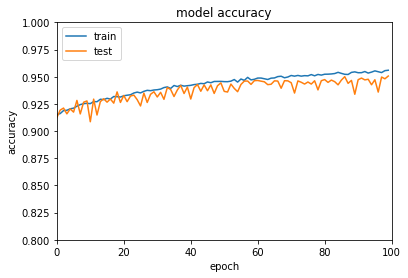

In [60]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.axis([0, 100, 0.8, 1])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

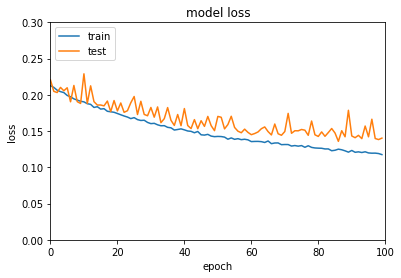

In [63]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.axis([0, 100, 0, 0.3])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Optimales Modell finden!

Im folgenden Schritt wird die optimale Kombination in Bezug auf die Aktivierungs- udn Optimierungs-Funktion und die Anzahl der Epochen evaluiert (per Grid Search)

In [39]:
from sklearn.model_selection import GridSearchCV

In [40]:
#Optimierungsfunktion für Modell
def c_modelOpti(optimizer, activation):
    model = Sequential()
    model.add(Dense(34, input_dim = 34, activation = activation))
    model.add (Dense (100, activation = activation))
    model.add (Dense (100, activation = activation))
    model.add (Dense (1, activation = 'sigmoid'))
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["binary_crossentropy","acc"])
    return model

In [42]:
model = KerasClassifier(build_fn=c_modelOpti)

epoches = [50, 100, 150]
optimizers = ['Adam', 'Adamax', 'SGD', 'RMSprop', 'Adadelta']
activations = ['softmax', 'relu', 'elu', 'selu', 'linear']

parameters = {'epochs': epoches, 'optimizer': optimizers, 'activation': activations}

clf = GridSearchCV(model, parameters)

# Startzeit
t = time.localtime()
current_time = time.strftime("%d.%m.%Y %H:%M:%S", t)
print(current_time, ' Training gestartet ...\n')

# Modell trainieren
clf.fit(df_data_x, df_gender_y, validation_split = 0.3)

# Endzeit
t2 = time.localtime()
current_time2 = time.strftime("%d.%m.%Y %H:%M:%S", t2)
print(' ')
print(current_time2, 'Training beendet ...')

11.05.2020 17:43:22  Training gestartet ...



/home/sebastian/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Train on 26341 samples, validate on 11289 samples
Epoch 1/50
26341/26341 [==============================] - 2s 85us/step - loss: 0.6895 - binary_crossentropy: 0.6895 - acc: 0.5512 - val_loss: 0.6615 - val_binary_crossentropy: 0.6615 - val_acc: 0.8151
Epoch 2/50
26341/26341 [==============================] - 2s 79us/step - loss: 0.5208 - binary_crossentropy: 0.5208 - acc: 0.8387 - val_loss: 0.4205 - val_binary_crossentropy: 0.4205 - val_acc: 0.8557
Epoch 3/50
26341/26341 [==============================] - 2s 79us/step - loss: 0.3855 - binary_crossentropy: 0.3855 - acc: 0.8587 - val_loss: 0.3632 - val_binary_crossentropy: 0.3632 - val_acc: 0.8630
Epoch 4/50
26341/26341 [==============================] - 2s 80us/step - loss: 0.3527 - binary_crossentropy: 0.3527 - acc: 0.8641 - val_loss: 0.3504 - val_binary_crossentropy: 0.3504 - val_acc: 0.8578
Epoch 5/50
26341/26341 [==============================] - 2s 80us/step - loss: 0.3345 - binary_crossentropy: 0.3345 - acc: 0.8677 - val_loss: 0.32

26341/26341 [==============================] - 2s 81us/step - loss: 0.2463 - binary_crossentropy: 0.2463 - acc: 0.9007 - val_loss: 0.2369 - val_binary_crossentropy: 0.2369 - val_acc: 0.9068
Epoch 32/50
26341/26341 [==============================] - 2s 80us/step - loss: 0.2437 - binary_crossentropy: 0.2437 - acc: 0.9024 - val_loss: 0.2360 - val_binary_crossentropy: 0.2360 - val_acc: 0.9055
Epoch 33/50
26341/26341 [==============================] - 2s 81us/step - loss: 0.2413 - binary_crossentropy: 0.2413 - acc: 0.9034 - val_loss: 0.2328 - val_binary_crossentropy: 0.2328 - val_acc: 0.9066
Epoch 34/50
26341/26341 [==============================] - 2s 82us/step - loss: 0.2410 - binary_crossentropy: 0.2410 - acc: 0.9033 - val_loss: 0.2328 - val_binary_crossentropy: 0.2328 - val_acc: 0.9074
Epoch 35/50
26341/26341 [==============================] - 2s 80us/step - loss: 0.2398 - binary_crossentropy: 0.2398 - acc: 0.9041 - val_loss: 0.2302 - val_binary_crossentropy: 0.2302 - val_acc: 0.9098
Ep

26341/26341 [==============================] - 2s 73us/step - loss: 0.3230 - binary_crossentropy: 0.3230 - acc: 0.8698 - val_loss: 0.3204 - val_binary_crossentropy: 0.3204 - val_acc: 0.8686
Epoch 12/50
26341/26341 [==============================] - 2s 73us/step - loss: 0.3209 - binary_crossentropy: 0.3209 - acc: 0.8704 - val_loss: 0.3209 - val_binary_crossentropy: 0.3209 - val_acc: 0.8688
Epoch 13/50
26341/26341 [==============================] - 2s 73us/step - loss: 0.3176 - binary_crossentropy: 0.3176 - acc: 0.8717 - val_loss: 0.3165 - val_binary_crossentropy: 0.3165 - val_acc: 0.8690
Epoch 14/50
26341/26341 [==============================] - 2s 72us/step - loss: 0.3148 - binary_crossentropy: 0.3148 - acc: 0.8713 - val_loss: 0.3124 - val_binary_crossentropy: 0.3124 - val_acc: 0.8690
Epoch 15/50
26341/26341 [==============================] - 2s 77us/step - loss: 0.3120 - binary_crossentropy: 0.3120 - acc: 0.8719 - val_loss: 0.3091 - val_binary_crossentropy: 0.3091 - val_acc: 0.8693
Ep

Epoch 42/50
26341/26341 [==============================] - 2s 78us/step - loss: 0.2430 - binary_crossentropy: 0.2430 - acc: 0.9042 - val_loss: 0.2368 - val_binary_crossentropy: 0.2368 - val_acc: 0.9051
Epoch 43/50
26341/26341 [==============================] - 2s 77us/step - loss: 0.2424 - binary_crossentropy: 0.2424 - acc: 0.9045 - val_loss: 0.2316 - val_binary_crossentropy: 0.2316 - val_acc: 0.9089
Epoch 44/50
26341/26341 [==============================] - 2s 78us/step - loss: 0.2407 - binary_crossentropy: 0.2407 - acc: 0.9048 - val_loss: 0.2329 - val_binary_crossentropy: 0.2329 - val_acc: 0.9052
Epoch 45/50
26341/26341 [==============================] - 2s 78us/step - loss: 0.2399 - binary_crossentropy: 0.2399 - acc: 0.9057 - val_loss: 0.2307 - val_binary_crossentropy: 0.2307 - val_acc: 0.9100
Epoch 46/50
26341/26341 [==============================] - 2s 78us/step - loss: 0.2386 - binary_crossentropy: 0.2386 - acc: 0.9061 - val_loss: 0.2267 - val_binary_crossentropy: 0.2267 - val_ac

26341/26341 [==============================] - 2s 75us/step - loss: 0.2686 - binary_crossentropy: 0.2686 - acc: 0.8903 - val_loss: 0.2684 - val_binary_crossentropy: 0.2684 - val_acc: 0.8884
Epoch 33/50
26341/26341 [==============================] - 2s 76us/step - loss: 0.2663 - binary_crossentropy: 0.2663 - acc: 0.8915 - val_loss: 0.2630 - val_binary_crossentropy: 0.2630 - val_acc: 0.8919
Epoch 34/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.2640 - binary_crossentropy: 0.2640 - acc: 0.8929 - val_loss: 0.2605 - val_binary_crossentropy: 0.2605 - val_acc: 0.8909
Epoch 35/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.2633 - binary_crossentropy: 0.2633 - acc: 0.8921 - val_loss: 0.2572 - val_binary_crossentropy: 0.2572 - val_acc: 0.8964
Epoch 36/50
26341/26341 [==============================] - 2s 76us/step - loss: 0.2610 - binary_crossentropy: 0.2610 - acc: 0.8948 - val_loss: 0.2552 - val_binary_crossentropy: 0.2552 - val_acc: 0.8947
Ep

26341/26341 [==============================] - 2s 77us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4951 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4966
Epoch 13/50
26341/26341 [==============================] - 3s 95us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5006 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 14/50
26341/26341 [==============================] - 3s 98us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4972 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4966
Epoch 15/50
26341/26341 [==============================] - 3s 99us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4974 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 16/50
26341/26341 [==============================] - 2s 84us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4997 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4966
Ep

Epoch 43/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4970 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5000
Epoch 44/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5002 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5000
Epoch 45/50
26341/26341 [==============================] - 2s 73us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4963 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5000
Epoch 46/50
26341/26341 [==============================] - 2s 74us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4983 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.5000
Epoch 47/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4983 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_ac

26341/26341 [==============================] - 2s 74us/step - loss: 0.2338 - binary_crossentropy: 0.2338 - acc: 0.9062 - val_loss: 0.2279 - val_binary_crossentropy: 0.2279 - val_acc: 0.9121
Epoch 34/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.2331 - binary_crossentropy: 0.2331 - acc: 0.9068 - val_loss: 0.2325 - val_binary_crossentropy: 0.2325 - val_acc: 0.9062
Epoch 35/50
26341/26341 [==============================] - 2s 73us/step - loss: 0.2313 - binary_crossentropy: 0.2313 - acc: 0.9075 - val_loss: 0.2306 - val_binary_crossentropy: 0.2306 - val_acc: 0.9100
Epoch 36/50
26341/26341 [==============================] - 2s 73us/step - loss: 0.2303 - binary_crossentropy: 0.2303 - acc: 0.9083 - val_loss: 0.2345 - val_binary_crossentropy: 0.2345 - val_acc: 0.9052
Epoch 37/50
26341/26341 [==============================] - 2s 74us/step - loss: 0.2282 - binary_crossentropy: 0.2282 - acc: 0.9103 - val_loss: 0.2627 - val_binary_crossentropy: 0.2627 - val_acc: 0.8942
Ep

26341/26341 [==============================] - 2s 72us/step - loss: 0.3141 - binary_crossentropy: 0.3141 - acc: 0.8727 - val_loss: 0.3142 - val_binary_crossentropy: 0.3142 - val_acc: 0.8728
Epoch 14/50
26341/26341 [==============================] - 2s 72us/step - loss: 0.3092 - binary_crossentropy: 0.3092 - acc: 0.8747 - val_loss: 0.3052 - val_binary_crossentropy: 0.3052 - val_acc: 0.8758
Epoch 15/50
26341/26341 [==============================] - 2s 72us/step - loss: 0.3034 - binary_crossentropy: 0.3034 - acc: 0.8761 - val_loss: 0.2995 - val_binary_crossentropy: 0.2995 - val_acc: 0.8771
Epoch 16/50
26341/26341 [==============================] - 2s 72us/step - loss: 0.2988 - binary_crossentropy: 0.2988 - acc: 0.8775 - val_loss: 0.2973 - val_binary_crossentropy: 0.2973 - val_acc: 0.8759
Epoch 17/50
26341/26341 [==============================] - 2s 72us/step - loss: 0.2944 - binary_crossentropy: 0.2944 - acc: 0.8800 - val_loss: 0.3041 - val_binary_crossentropy: 0.3041 - val_acc: 0.8743
Ep

Epoch 44/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4999 - val_loss: 0.6934 - val_binary_crossentropy: 0.6934 - val_acc: 0.4967
Epoch 45/50
26341/26341 [==============================] - 2s 76us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4995 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5033
Epoch 46/50
26341/26341 [==============================] - 2s 74us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4955 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4967
Epoch 47/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.6931 - binary_crossentropy: 0.6931 - acc: 0.4988 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5033
Epoch 48/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4971 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_ac

26341/26341 [==============================] - 2s 75us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4986 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 35/50
26341/26341 [==============================] - 2s 74us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5051 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4966
Epoch 36/50
26341/26341 [==============================] - 2s 73us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4954 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 37/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4972 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4966
Epoch 38/50
26341/26341 [==============================] - 2s 74us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4972 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4966
Ep

26341/26341 [==============================] - 2s 73us/step - loss: 0.2702 - binary_crossentropy: 0.2702 - acc: 0.8897 - val_loss: 0.2756 - val_binary_crossentropy: 0.2756 - val_acc: 0.8820
Epoch 15/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.2642 - binary_crossentropy: 0.2642 - acc: 0.8906 - val_loss: 0.2560 - val_binary_crossentropy: 0.2560 - val_acc: 0.8960
Epoch 16/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.2583 - binary_crossentropy: 0.2583 - acc: 0.8947 - val_loss: 0.2680 - val_binary_crossentropy: 0.2680 - val_acc: 0.8878
Epoch 17/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.2524 - binary_crossentropy: 0.2524 - acc: 0.8970 - val_loss: 0.2477 - val_binary_crossentropy: 0.2477 - val_acc: 0.9017
Epoch 18/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.2480 - binary_crossentropy: 0.2480 - acc: 0.8993 - val_loss: 0.2700 - val_binary_crossentropy: 0.2700 - val_acc: 0.888

26341/26341 [==============================] - 2s 73us/step - loss: 0.1968 - binary_crossentropy: 0.1968 - acc: 0.9235 - val_loss: 0.2172 - val_binary_crossentropy: 0.2172 - val_acc: 0.9154
Epoch 95/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.1967 - binary_crossentropy: 0.1967 - acc: 0.9245 - val_loss: 0.1959 - val_binary_crossentropy: 0.1959 - val_acc: 0.9257
Epoch 96/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.1952 - binary_crossentropy: 0.1952 - acc: 0.9240 - val_loss: 0.2296 - val_binary_crossentropy: 0.2296 - val_acc: 0.9092
Epoch 97/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.1952 - binary_crossentropy: 0.1952 - acc: 0.9257 - val_loss: 0.2062 - val_binary_crossentropy: 0.2062 - val_acc: 0.9216
Epoch 98/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.1945 - binary_crossentropy: 0.1945 - acc: 0.9255 - val_loss: 0.2060 - val_binary_crossentropy: 0.2060 - val_acc: 0.922

Epoch 34/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.2290 - binary_crossentropy: 0.2290 - acc: 0.9103 - val_loss: 0.2149 - val_binary_crossentropy: 0.2149 - val_acc: 0.9174
Epoch 35/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.2268 - binary_crossentropy: 0.2268 - acc: 0.9122 - val_loss: 0.2148 - val_binary_crossentropy: 0.2148 - val_acc: 0.9163
Epoch 36/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.2270 - binary_crossentropy: 0.2270 - acc: 0.9109 - val_loss: 0.2378 - val_binary_crossentropy: 0.2378 - val_acc: 0.9040
Epoch 37/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.2245 - binary_crossentropy: 0.2245 - acc: 0.9139 - val_loss: 0.2220 - val_binary_crossentropy: 0.2220 - val_acc: 0.9142
Epoch 38/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.2231 - binary_crossentropy: 0.2231 - acc: 0.9132 - val_loss: 0.2102 - val_binary_crossentropy: 0.2102 - v

Epoch 14/100
26341/26341 [==============================] - 2s 78us/step - loss: 0.2823 - binary_crossentropy: 0.2823 - acc: 0.8842 - val_loss: 0.2755 - val_binary_crossentropy: 0.2755 - val_acc: 0.8858
Epoch 15/100
26341/26341 [==============================] - 2s 78us/step - loss: 0.2768 - binary_crossentropy: 0.2768 - acc: 0.8868 - val_loss: 0.2723 - val_binary_crossentropy: 0.2723 - val_acc: 0.8874
Epoch 16/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.2715 - binary_crossentropy: 0.2715 - acc: 0.8900 - val_loss: 0.2662 - val_binary_crossentropy: 0.2662 - val_acc: 0.8908
Epoch 17/100
26341/26341 [==============================] - 2s 77us/step - loss: 0.2674 - binary_crossentropy: 0.2674 - acc: 0.8910 - val_loss: 0.2606 - val_binary_crossentropy: 0.2606 - val_acc: 0.8943
Epoch 18/100
26341/26341 [==============================] - 2s 78us/step - loss: 0.2651 - binary_crossentropy: 0.2651 - acc: 0.8921 - val_loss: 0.2577 - val_binary_crossentropy: 0.2577 - v

26341/26341 [==============================] - 2s 78us/step - loss: 0.2100 - binary_crossentropy: 0.2100 - acc: 0.9179 - val_loss: 0.2100 - val_binary_crossentropy: 0.2100 - val_acc: 0.9177
Epoch 95/100
26341/26341 [==============================] - 2s 78us/step - loss: 0.2086 - binary_crossentropy: 0.2086 - acc: 0.9173 - val_loss: 0.2109 - val_binary_crossentropy: 0.2109 - val_acc: 0.9168
Epoch 96/100
26341/26341 [==============================] - 2s 78us/step - loss: 0.2090 - binary_crossentropy: 0.2090 - acc: 0.9178 - val_loss: 0.2048 - val_binary_crossentropy: 0.2048 - val_acc: 0.9196
Epoch 97/100
26341/26341 [==============================] - 2s 77us/step - loss: 0.2085 - binary_crossentropy: 0.2085 - acc: 0.9184 - val_loss: 0.2042 - val_binary_crossentropy: 0.2042 - val_acc: 0.9208
Epoch 98/100
26341/26341 [==============================] - 2s 78us/step - loss: 0.2069 - binary_crossentropy: 0.2069 - acc: 0.9191 - val_loss: 0.2042 - val_binary_crossentropy: 0.2042 - val_acc: 0.919

Epoch 34/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.2451 - binary_crossentropy: 0.2451 - acc: 0.9023 - val_loss: 0.2404 - val_binary_crossentropy: 0.2404 - val_acc: 0.9042
Epoch 35/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.2439 - binary_crossentropy: 0.2439 - acc: 0.9016 - val_loss: 0.2394 - val_binary_crossentropy: 0.2394 - val_acc: 0.9021
Epoch 36/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.2421 - binary_crossentropy: 0.2420 - acc: 0.9024 - val_loss: 0.2382 - val_binary_crossentropy: 0.2382 - val_acc: 0.9029
Epoch 37/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.2393 - binary_crossentropy: 0.2393 - acc: 0.9051 - val_loss: 0.2523 - val_binary_crossentropy: 0.2523 - val_acc: 0.8987
Epoch 38/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.2396 - binary_crossentropy: 0.2396 - acc: 0.9026 - val_loss: 0.2342 - val_binary_crossentropy: 0.2342 - v

Epoch 14/100
26341/26341 [==============================] - 2s 77us/step - loss: 0.3224 - binary_crossentropy: 0.3224 - acc: 0.8684 - val_loss: 0.3143 - val_binary_crossentropy: 0.3143 - val_acc: 0.8695
Epoch 15/100
26341/26341 [==============================] - 2s 77us/step - loss: 0.3204 - binary_crossentropy: 0.3204 - acc: 0.8684 - val_loss: 0.3128 - val_binary_crossentropy: 0.3128 - val_acc: 0.8692
Epoch 16/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.3186 - binary_crossentropy: 0.3186 - acc: 0.8683 - val_loss: 0.3103 - val_binary_crossentropy: 0.3103 - val_acc: 0.8697
Epoch 17/100
26341/26341 [==============================] - 2s 77us/step - loss: 0.3157 - binary_crossentropy: 0.3157 - acc: 0.8698 - val_loss: 0.3149 - val_binary_crossentropy: 0.3149 - val_acc: 0.8666
Epoch 18/100
26341/26341 [==============================] - 2s 78us/step - loss: 0.3148 - binary_crossentropy: 0.3148 - acc: 0.8694 - val_loss: 0.3095 - val_binary_crossentropy: 0.3095 - v

26341/26341 [==============================] - 2s 75us/step - loss: 0.2165 - binary_crossentropy: 0.2165 - acc: 0.9167 - val_loss: 0.2169 - val_binary_crossentropy: 0.2169 - val_acc: 0.9168
Epoch 95/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.2160 - binary_crossentropy: 0.2160 - acc: 0.9167 - val_loss: 0.2063 - val_binary_crossentropy: 0.2063 - val_acc: 0.9204
Epoch 96/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.2157 - binary_crossentropy: 0.2157 - acc: 0.9170 - val_loss: 0.2047 - val_binary_crossentropy: 0.2047 - val_acc: 0.9225
Epoch 97/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.2158 - binary_crossentropy: 0.2158 - acc: 0.9161 - val_loss: 0.2099 - val_binary_crossentropy: 0.2099 - val_acc: 0.9199
Epoch 98/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.2157 - binary_crossentropy: 0.2157 - acc: 0.9153 - val_loss: 0.2092 - val_binary_crossentropy: 0.2092 - val_acc: 0.920

Epoch 34/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.2609 - binary_crossentropy: 0.2609 - acc: 0.8950 - val_loss: 0.2613 - val_binary_crossentropy: 0.2613 - val_acc: 0.8903
Epoch 35/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.2576 - binary_crossentropy: 0.2576 - acc: 0.8973 - val_loss: 0.2521 - val_binary_crossentropy: 0.2521 - val_acc: 0.8949
Epoch 36/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.2558 - binary_crossentropy: 0.2558 - acc: 0.8979 - val_loss: 0.2527 - val_binary_crossentropy: 0.2527 - val_acc: 0.8994
Epoch 37/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.2524 - binary_crossentropy: 0.2524 - acc: 0.8995 - val_loss: 0.2583 - val_binary_crossentropy: 0.2583 - val_acc: 0.8966
Epoch 38/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.2504 - binary_crossentropy: 0.2504 - acc: 0.9001 - val_loss: 0.2477 - val_binary_crossentropy: 0.2477 - v

Epoch 14/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4974 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4967
Epoch 15/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5029 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5033
Epoch 16/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4958 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4967
Epoch 17/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4998 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4967
Epoch 18/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4976 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - v

26341/26341 [==============================] - 2s 70us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5007 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933 - val_acc: 0.4967
Epoch 95/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5007 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4967
Epoch 96/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5013 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4967
Epoch 97/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4994 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4967
Epoch 98/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5006 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.496

Epoch 34/100
26341/26341 [==============================] - 2s 85us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4987 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 35/100
26341/26341 [==============================] - 2s 86us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4964 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 36/100
26341/26341 [==============================] - 2s 86us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5005 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 37/100
26341/26341 [==============================] - 2s 86us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4974 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 38/100
26341/26341 [==============================] - 2s 85us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4936 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - v

Epoch 14/100
26341/26341 [==============================] - 2s 84us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5029 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.5000
Epoch 15/100
26341/26341 [==============================] - 2s 87us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4942 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5000
Epoch 16/100
26341/26341 [==============================] - 2s 85us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5001 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.5000
Epoch 17/100
26341/26341 [==============================] - 2s 85us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4981 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5000
Epoch 18/100
26341/26341 [==============================] - 2s 84us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4969 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - v

26341/26341 [==============================] - 2s 85us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4998 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5000
Epoch 95/100
26341/26341 [==============================] - 2s 83us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4959 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5000
Epoch 96/100
26341/26341 [==============================] - 2s 86us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4984 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.5000
Epoch 97/100
26341/26341 [==============================] - 2s 84us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5017 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.5000
Epoch 98/100
26341/26341 [==============================] - 2s 85us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4977 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.500

Epoch 34/100
26341/26341 [==============================] - 2s 85us/step - loss: 0.2371 - binary_crossentropy: 0.2371 - acc: 0.9068 - val_loss: 0.2396 - val_binary_crossentropy: 0.2396 - val_acc: 0.9046
Epoch 35/100
26341/26341 [==============================] - 2s 85us/step - loss: 0.2343 - binary_crossentropy: 0.2343 - acc: 0.9056 - val_loss: 0.2324 - val_binary_crossentropy: 0.2324 - val_acc: 0.9076
Epoch 36/100
26341/26341 [==============================] - 2s 86us/step - loss: 0.2324 - binary_crossentropy: 0.2324 - acc: 0.9085 - val_loss: 0.2392 - val_binary_crossentropy: 0.2392 - val_acc: 0.9052
Epoch 37/100
26341/26341 [==============================] - 2s 87us/step - loss: 0.2313 - binary_crossentropy: 0.2313 - acc: 0.9086 - val_loss: 0.2613 - val_binary_crossentropy: 0.2613 - val_acc: 0.8927
Epoch 38/100
26341/26341 [==============================] - 2s 87us/step - loss: 0.2312 - binary_crossentropy: 0.2312 - acc: 0.9090 - val_loss: 0.2278 - val_binary_crossentropy: 0.2278 - v

Epoch 14/100
26341/26341 [==============================] - 2s 86us/step - loss: 0.3115 - binary_crossentropy: 0.3115 - acc: 0.8716 - val_loss: 0.3004 - val_binary_crossentropy: 0.3004 - val_acc: 0.8764
Epoch 15/100
26341/26341 [==============================] - 2s 87us/step - loss: 0.3048 - binary_crossentropy: 0.3048 - acc: 0.8764 - val_loss: 0.2959 - val_binary_crossentropy: 0.2959 - val_acc: 0.8762
Epoch 16/100
26341/26341 [==============================] - 2s 86us/step - loss: 0.2993 - binary_crossentropy: 0.2993 - acc: 0.8776 - val_loss: 0.2920 - val_binary_crossentropy: 0.2920 - val_acc: 0.8779
Epoch 17/100
26341/26341 [==============================] - 2s 85us/step - loss: 0.2938 - binary_crossentropy: 0.2938 - acc: 0.8807 - val_loss: 0.2808 - val_binary_crossentropy: 0.2808 - val_acc: 0.8852
Epoch 18/100
26341/26341 [==============================] - 2s 85us/step - loss: 0.2892 - binary_crossentropy: 0.2892 - acc: 0.8825 - val_loss: 0.2818 - val_binary_crossentropy: 0.2818 - v

26341/26341 [==============================] - 2s 86us/step - loss: 0.2006 - binary_crossentropy: 0.2006 - acc: 0.9221 - val_loss: 0.2220 - val_binary_crossentropy: 0.2220 - val_acc: 0.9128
Epoch 95/100
26341/26341 [==============================] - 2s 85us/step - loss: 0.1996 - binary_crossentropy: 0.1996 - acc: 0.9231 - val_loss: 0.2905 - val_binary_crossentropy: 0.2905 - val_acc: 0.8768
Epoch 96/100
26341/26341 [==============================] - 2s 85us/step - loss: 0.1991 - binary_crossentropy: 0.1991 - acc: 0.9230 - val_loss: 0.1874 - val_binary_crossentropy: 0.1874 - val_acc: 0.9298
Epoch 97/100
26341/26341 [==============================] - 2s 86us/step - loss: 0.1991 - binary_crossentropy: 0.1991 - acc: 0.9229 - val_loss: 0.2139 - val_binary_crossentropy: 0.2139 - val_acc: 0.9156
Epoch 98/100
26341/26341 [==============================] - 2s 85us/step - loss: 0.1984 - binary_crossentropy: 0.1984 - acc: 0.9247 - val_loss: 0.2021 - val_binary_crossentropy: 0.2021 - val_acc: 0.922

Epoch 34/100
26341/26341 [==============================] - 2s 84us/step - loss: 0.2368 - binary_crossentropy: 0.2368 - acc: 0.9078 - val_loss: 0.2466 - val_binary_crossentropy: 0.2466 - val_acc: 0.9003
Epoch 35/100
26341/26341 [==============================] - 2s 80us/step - loss: 0.2348 - binary_crossentropy: 0.2348 - acc: 0.9081 - val_loss: 0.2269 - val_binary_crossentropy: 0.2269 - val_acc: 0.9093
Epoch 36/100
26341/26341 [==============================] - 2s 82us/step - loss: 0.2334 - binary_crossentropy: 0.2334 - acc: 0.9086 - val_loss: 0.3097 - val_binary_crossentropy: 0.3097 - val_acc: 0.8673
Epoch 37/100
26341/26341 [==============================] - 2s 82us/step - loss: 0.2320 - binary_crossentropy: 0.2320 - acc: 0.9086 - val_loss: 0.2265 - val_binary_crossentropy: 0.2265 - val_acc: 0.9091
Epoch 38/100
26341/26341 [==============================] - 2s 81us/step - loss: 0.2305 - binary_crossentropy: 0.2305 - acc: 0.9084 - val_loss: 0.2758 - val_binary_crossentropy: 0.2758 - v

Epoch 14/100
26341/26341 [==============================] - 2s 84us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5021 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4967
Epoch 15/100
26341/26341 [==============================] - 2s 81us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4979 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4967
Epoch 16/100
26341/26341 [==============================] - 2s 82us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5029 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5033
Epoch 17/100
26341/26341 [==============================] - 2s 83us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5003 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5033
Epoch 18/100
26341/26341 [==============================] - 2s 82us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4965 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - v

26341/26341 [==============================] - 2s 80us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4994 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4967
Epoch 95/100
26341/26341 [==============================] - 2s 81us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4998 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5033
Epoch 96/100
26341/26341 [==============================] - 2s 81us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4996 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5033
Epoch 97/100
26341/26341 [==============================] - 2s 82us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4970 - val_loss: 0.6931 - val_binary_crossentropy: 0.6932 - val_acc: 0.4967
Epoch 98/100
26341/26341 [==============================] - 2s 77us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4952 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.496

Epoch 34/100
26341/26341 [==============================] - 2s 83us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5013 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4966
Epoch 35/100
26341/26341 [==============================] - 2s 83us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4916 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.4966
Epoch 36/100
26341/26341 [==============================] - 2s 83us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5006 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 37/100
26341/26341 [==============================] - 2s 83us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4983 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 38/100
26341/26341 [==============================] - 2s 83us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4955 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - v

Epoch 14/100
26341/26341 [==============================] - 2s 80us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4992 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5000
Epoch 15/100
26341/26341 [==============================] - 2s 82us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4925 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.5000
Epoch 16/100
26341/26341 [==============================] - 2s 81us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4985 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.5000
Epoch 17/100
26341/26341 [==============================] - 2s 82us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4985 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.5000
Epoch 18/100
26341/26341 [==============================] - 2s 79us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4987 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - v

26341/26341 [==============================] - 2s 83us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4998 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.5000
Epoch 95/100
26341/26341 [==============================] - 2s 82us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5018 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5000
Epoch 96/100
26341/26341 [==============================] - 2s 82us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4983 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.5000
Epoch 97/100
26341/26341 [==============================] - 2s 82us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4964 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.5000
Epoch 98/100
26341/26341 [==============================] - 2s 83us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4988 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.500

Epoch 34/150
26341/26341 [==============================] - 2s 80us/step - loss: 0.2295 - binary_crossentropy: 0.2295 - acc: 0.9096 - val_loss: 0.2298 - val_binary_crossentropy: 0.2298 - val_acc: 0.9084
Epoch 35/150
26341/26341 [==============================] - 2s 80us/step - loss: 0.2273 - binary_crossentropy: 0.2273 - acc: 0.9106 - val_loss: 0.2242 - val_binary_crossentropy: 0.2242 - val_acc: 0.9113
Epoch 36/150
26341/26341 [==============================] - 2s 79us/step - loss: 0.2276 - binary_crossentropy: 0.2276 - acc: 0.9104 - val_loss: 0.2197 - val_binary_crossentropy: 0.2197 - val_acc: 0.9141
Epoch 37/150
26341/26341 [==============================] - 2s 79us/step - loss: 0.2251 - binary_crossentropy: 0.2251 - acc: 0.9117 - val_loss: 0.2245 - val_binary_crossentropy: 0.2245 - val_acc: 0.9120
Epoch 38/150
26341/26341 [==============================] - 2s 80us/step - loss: 0.2249 - binary_crossentropy: 0.2249 - acc: 0.9125 - val_loss: 0.2185 - val_binary_crossentropy: 0.2185 - v

26341/26341 [==============================] - 2s 80us/step - loss: 0.2025 - binary_crossentropy: 0.2025 - acc: 0.9202 - val_loss: 0.1982 - val_binary_crossentropy: 0.1982 - val_acc: 0.9251
Epoch 115/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.2006 - binary_crossentropy: 0.2006 - acc: 0.9228 - val_loss: 0.1976 - val_binary_crossentropy: 0.1976 - val_acc: 0.9234
Epoch 116/150
26341/26341 [==============================] - 2s 79us/step - loss: 0.1989 - binary_crossentropy: 0.1989 - acc: 0.9221 - val_loss: 0.1975 - val_binary_crossentropy: 0.1975 - val_acc: 0.9246
Epoch 117/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.1993 - binary_crossentropy: 0.1993 - acc: 0.9227 - val_loss: 0.1968 - val_binary_crossentropy: 0.1968 - val_acc: 0.9257
Epoch 118/150
26341/26341 [==============================] - 2s 80us/step - loss: 0.2002 - binary_crossentropy: 0.2002 - acc: 0.9229 - val_loss: 0.1981 - val_binary_crossentropy: 0.1981 - val_acc: 0

Epoch 4/150
26341/26341 [==============================] - 2s 85us/step - loss: 0.3590 - binary_crossentropy: 0.3590 - acc: 0.8617 - val_loss: 0.3414 - val_binary_crossentropy: 0.3414 - val_acc: 0.8678
Epoch 5/150
26341/26341 [==============================] - 2s 86us/step - loss: 0.3411 - binary_crossentropy: 0.3411 - acc: 0.8650 - val_loss: 0.3267 - val_binary_crossentropy: 0.3267 - val_acc: 0.8671
Epoch 6/150
26341/26341 [==============================] - 2s 86us/step - loss: 0.3295 - binary_crossentropy: 0.3295 - acc: 0.8661 - val_loss: 0.3172 - val_binary_crossentropy: 0.3172 - val_acc: 0.8688
Epoch 7/150
26341/26341 [==============================] - 2s 85us/step - loss: 0.3209 - binary_crossentropy: 0.3209 - acc: 0.8688 - val_loss: 0.3098 - val_binary_crossentropy: 0.3098 - val_acc: 0.8704
Epoch 8/150
26341/26341 [==============================] - 2s 85us/step - loss: 0.3140 - binary_crossentropy: 0.3140 - acc: 0.8708 - val_loss: 0.3067 - val_binary_crossentropy: 0.3067 - val_ac

26341/26341 [==============================] - 2s 84us/step - loss: 0.2121 - binary_crossentropy: 0.2121 - acc: 0.9170 - val_loss: 0.2018 - val_binary_crossentropy: 0.2018 - val_acc: 0.9221
Epoch 85/150
26341/26341 [==============================] - 2s 86us/step - loss: 0.2136 - binary_crossentropy: 0.2136 - acc: 0.9163 - val_loss: 0.2140 - val_binary_crossentropy: 0.2140 - val_acc: 0.9170
Epoch 86/150
26341/26341 [==============================] - 2s 85us/step - loss: 0.2098 - binary_crossentropy: 0.2098 - acc: 0.9185 - val_loss: 0.2029 - val_binary_crossentropy: 0.2029 - val_acc: 0.9214
Epoch 87/150
26341/26341 [==============================] - 2s 85us/step - loss: 0.2096 - binary_crossentropy: 0.2096 - acc: 0.9184 - val_loss: 0.1999 - val_binary_crossentropy: 0.1999 - val_acc: 0.9237
Epoch 88/150
26341/26341 [==============================] - 2s 85us/step - loss: 0.2104 - binary_crossentropy: 0.2104 - acc: 0.9179 - val_loss: 0.2032 - val_binary_crossentropy: 0.2032 - val_acc: 0.921

Epoch 14/150
26341/26341 [==============================] - 2s 88us/step - loss: 0.2771 - binary_crossentropy: 0.2771 - acc: 0.8887 - val_loss: 0.2695 - val_binary_crossentropy: 0.2695 - val_acc: 0.8899
Epoch 15/150
26341/26341 [==============================] - 2s 86us/step - loss: 0.2717 - binary_crossentropy: 0.2717 - acc: 0.8919 - val_loss: 0.2620 - val_binary_crossentropy: 0.2620 - val_acc: 0.8933
Epoch 16/150
26341/26341 [==============================] - 2s 86us/step - loss: 0.2655 - binary_crossentropy: 0.2655 - acc: 0.8943 - val_loss: 0.2595 - val_binary_crossentropy: 0.2595 - val_acc: 0.8930
Epoch 17/150
26341/26341 [==============================] - 2s 88us/step - loss: 0.2620 - binary_crossentropy: 0.2620 - acc: 0.8964 - val_loss: 0.2530 - val_binary_crossentropy: 0.2530 - val_acc: 0.8980
Epoch 18/150
26341/26341 [==============================] - 2s 88us/step - loss: 0.2581 - binary_crossentropy: 0.2581 - acc: 0.8977 - val_loss: 0.2502 - val_binary_crossentropy: 0.2502 - v

26341/26341 [==============================] - 2s 86us/step - loss: 0.1956 - binary_crossentropy: 0.1956 - acc: 0.9243 - val_loss: 0.2038 - val_binary_crossentropy: 0.2038 - val_acc: 0.9186
Epoch 95/150
26341/26341 [==============================] - 2s 86us/step - loss: 0.1927 - binary_crossentropy: 0.1927 - acc: 0.9253 - val_loss: 0.2058 - val_binary_crossentropy: 0.2058 - val_acc: 0.9182
Epoch 96/150
26341/26341 [==============================] - 2s 86us/step - loss: 0.1946 - binary_crossentropy: 0.1946 - acc: 0.9246 - val_loss: 0.1879 - val_binary_crossentropy: 0.1879 - val_acc: 0.9289
Epoch 97/150
26341/26341 [==============================] - 2s 86us/step - loss: 0.1927 - binary_crossentropy: 0.1927 - acc: 0.9261 - val_loss: 0.1880 - val_binary_crossentropy: 0.1880 - val_acc: 0.9294
Epoch 98/150
26341/26341 [==============================] - 2s 85us/step - loss: 0.1919 - binary_crossentropy: 0.1919 - acc: 0.9260 - val_loss: 0.1977 - val_binary_crossentropy: 0.1977 - val_acc: 0.922

Epoch 24/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.2851 - binary_crossentropy: 0.2851 - acc: 0.8820 - val_loss: 0.2857 - val_binary_crossentropy: 0.2857 - val_acc: 0.8783
Epoch 25/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.2817 - binary_crossentropy: 0.2817 - acc: 0.8838 - val_loss: 0.2775 - val_binary_crossentropy: 0.2775 - val_acc: 0.8835
Epoch 26/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.2772 - binary_crossentropy: 0.2772 - acc: 0.8875 - val_loss: 0.2866 - val_binary_crossentropy: 0.2866 - val_acc: 0.8811
Epoch 27/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.2740 - binary_crossentropy: 0.2740 - acc: 0.8884 - val_loss: 0.2678 - val_binary_crossentropy: 0.2678 - val_acc: 0.8894
Epoch 28/150
26341/26341 [==============================] - 2s 79us/step - loss: 0.2688 - binary_crossentropy: 0.2688 - acc: 0.8898 - val_loss: 0.2636 - val_binary_crossentropy: 0.2636 - v

26341/26341 [==============================] - 2s 79us/step - loss: 0.1964 - binary_crossentropy: 0.1964 - acc: 0.9241 - val_loss: 0.1975 - val_binary_crossentropy: 0.1975 - val_acc: 0.9266
Epoch 105/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.1974 - binary_crossentropy: 0.1974 - acc: 0.9237 - val_loss: 0.1948 - val_binary_crossentropy: 0.1948 - val_acc: 0.9267
Epoch 106/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.1967 - binary_crossentropy: 0.1967 - acc: 0.9240 - val_loss: 0.1954 - val_binary_crossentropy: 0.1954 - val_acc: 0.9256
Epoch 107/150
26341/26341 [==============================] - 2s 79us/step - loss: 0.1960 - binary_crossentropy: 0.1960 - acc: 0.9246 - val_loss: 0.1944 - val_binary_crossentropy: 0.1944 - val_acc: 0.9261
Epoch 108/150
26341/26341 [==============================] - 2s 80us/step - loss: 0.1958 - binary_crossentropy: 0.1958 - acc: 0.9253 - val_loss: 0.1934 - val_binary_crossentropy: 0.1934 - val_acc: 0

Epoch 34/150
26341/26341 [==============================] - 2s 82us/step - loss: 0.2595 - binary_crossentropy: 0.2595 - acc: 0.8949 - val_loss: 0.2476 - val_binary_crossentropy: 0.2476 - val_acc: 0.8999
Epoch 35/150
26341/26341 [==============================] - 2s 84us/step - loss: 0.2559 - binary_crossentropy: 0.2559 - acc: 0.8977 - val_loss: 0.2463 - val_binary_crossentropy: 0.2463 - val_acc: 0.9022
Epoch 36/150
26341/26341 [==============================] - 2s 83us/step - loss: 0.2536 - binary_crossentropy: 0.2536 - acc: 0.8997 - val_loss: 0.2507 - val_binary_crossentropy: 0.2507 - val_acc: 0.9004
Epoch 37/150
26341/26341 [==============================] - 2s 84us/step - loss: 0.2511 - binary_crossentropy: 0.2511 - acc: 0.9000 - val_loss: 0.2449 - val_binary_crossentropy: 0.2449 - val_acc: 0.9019
Epoch 38/150
26341/26341 [==============================] - 2s 81us/step - loss: 0.2490 - binary_crossentropy: 0.2490 - acc: 0.9013 - val_loss: 0.2389 - val_binary_crossentropy: 0.2389 - v

26341/26341 [==============================] - 2s 59us/step - loss: 0.1980 - binary_crossentropy: 0.1980 - acc: 0.9238 - val_loss: 0.1967 - val_binary_crossentropy: 0.1967 - val_acc: 0.9256
Epoch 115/150
26341/26341 [==============================] - 2s 65us/step - loss: 0.1992 - binary_crossentropy: 0.1992 - acc: 0.9238 - val_loss: 0.1924 - val_binary_crossentropy: 0.1924 - val_acc: 0.9265
Epoch 116/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.1978 - binary_crossentropy: 0.1978 - acc: 0.9238 - val_loss: 0.2042 - val_binary_crossentropy: 0.2042 - val_acc: 0.9221
Epoch 117/150
26341/26341 [==============================] - 2s 82us/step - loss: 0.1969 - binary_crossentropy: 0.1969 - acc: 0.9245 - val_loss: 0.1918 - val_binary_crossentropy: 0.1918 - val_acc: 0.9266
Epoch 118/150
26341/26341 [==============================] - 2s 82us/step - loss: 0.1967 - binary_crossentropy: 0.1967 - acc: 0.9236 - val_loss: 0.1932 - val_binary_crossentropy: 0.1932 - val_acc: 0

Epoch 4/150
26341/26341 [==============================] - 2s 86us/step - loss: 0.4178 - binary_crossentropy: 0.4178 - acc: 0.8488 - val_loss: 0.3871 - val_binary_crossentropy: 0.3871 - val_acc: 0.8552
Epoch 5/150
26341/26341 [==============================] - 2s 87us/step - loss: 0.3771 - binary_crossentropy: 0.3771 - acc: 0.8550 - val_loss: 0.3699 - val_binary_crossentropy: 0.3699 - val_acc: 0.8565
Epoch 6/150
26341/26341 [==============================] - 2s 88us/step - loss: 0.3609 - binary_crossentropy: 0.3609 - acc: 0.8610 - val_loss: 0.3540 - val_binary_crossentropy: 0.3540 - val_acc: 0.8641
Epoch 7/150
26341/26341 [==============================] - 2s 87us/step - loss: 0.3526 - binary_crossentropy: 0.3526 - acc: 0.8634 - val_loss: 0.3472 - val_binary_crossentropy: 0.3472 - val_acc: 0.8647
Epoch 8/150
26341/26341 [==============================] - 2s 87us/step - loss: 0.3432 - binary_crossentropy: 0.3432 - acc: 0.8662 - val_loss: 0.3381 - val_binary_crossentropy: 0.3381 - val_ac

26341/26341 [==============================] - 2s 84us/step - loss: 0.2180 - binary_crossentropy: 0.2180 - acc: 0.9158 - val_loss: 0.2364 - val_binary_crossentropy: 0.2364 - val_acc: 0.9032
Epoch 85/150
26341/26341 [==============================] - 2s 81us/step - loss: 0.2190 - binary_crossentropy: 0.2190 - acc: 0.9124 - val_loss: 0.2133 - val_binary_crossentropy: 0.2133 - val_acc: 0.9150
Epoch 86/150
26341/26341 [==============================] - 2s 85us/step - loss: 0.2182 - binary_crossentropy: 0.2182 - acc: 0.9145 - val_loss: 0.2187 - val_binary_crossentropy: 0.2187 - val_acc: 0.9123
Epoch 87/150
26341/26341 [==============================] - 2s 85us/step - loss: 0.2174 - binary_crossentropy: 0.2174 - acc: 0.9152 - val_loss: 0.2125 - val_binary_crossentropy: 0.2125 - val_acc: 0.9151
Epoch 88/150
26341/26341 [==============================] - 2s 85us/step - loss: 0.2184 - binary_crossentropy: 0.2184 - acc: 0.9132 - val_loss: 0.2121 - val_binary_crossentropy: 0.2121 - val_acc: 0.914

Epoch 14/150
26341/26341 [==============================] - 2s 86us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5012 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4967
Epoch 15/150
26341/26341 [==============================] - 2s 87us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4957 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4967
Epoch 16/150
26341/26341 [==============================] - 2s 86us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5017 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4967
Epoch 17/150
26341/26341 [==============================] - 2s 86us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5009 - val_loss: 0.6931 - val_binary_crossentropy: 0.6932 - val_acc: 0.4967
Epoch 18/150
26341/26341 [==============================] - 2s 85us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4987 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - v

26341/26341 [==============================] - 2s 82us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5022 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4967
Epoch 95/150
26341/26341 [==============================] - 2s 87us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5011 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4967
Epoch 96/150
26341/26341 [==============================] - 2s 87us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5020 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4967
Epoch 97/150
26341/26341 [==============================] - 2s 87us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4971 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4967
Epoch 98/150
26341/26341 [==============================] - 2s 86us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5010 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.496

Epoch 24/150
26341/26341 [==============================] - 2s 86us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4993 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 25/150
26341/26341 [==============================] - 2s 86us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5029 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 26/150
26341/26341 [==============================] - 2s 86us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4985 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.4966
Epoch 27/150
26341/26341 [==============================] - 2s 87us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5007 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 28/150
26341/26341 [==============================] - 2s 85us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5011 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - v

26341/26341 [==============================] - 2s 86us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4960 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 105/150
26341/26341 [==============================] - 2s 84us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4985 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 106/150
26341/26341 [==============================] - 2s 85us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4960 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 107/150
26341/26341 [==============================] - 2s 84us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4953 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 108/150
26341/26341 [==============================] - 2s 86us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4991 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0

Epoch 34/150
26341/26341 [==============================] - 2s 83us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5010 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.5000
Epoch 35/150
26341/26341 [==============================] - 2s 84us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4996 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5000
Epoch 36/150
26341/26341 [==============================] - 2s 85us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4935 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.5000
Epoch 37/150
26341/26341 [==============================] - 2s 84us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4978 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5000
Epoch 38/150
26341/26341 [==============================] - 2s 85us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4955 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - v

26341/26341 [==============================] - 2s 78us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.5000
Epoch 115/150
26341/26341 [==============================] - 2s 84us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4995 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.5000
Epoch 116/150
26341/26341 [==============================] - 2s 85us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4992 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5000
Epoch 117/150
26341/26341 [==============================] - 2s 84us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4986 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5000
Epoch 118/150
26341/26341 [==============================] - 2s 83us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5007 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0

Epoch 4/150
26341/26341 [==============================] - 2s 85us/step - loss: 0.3980 - binary_crossentropy: 0.3980 - acc: 0.8524 - val_loss: 0.3802 - val_binary_crossentropy: 0.3802 - val_acc: 0.8545
Epoch 5/150
26341/26341 [==============================] - 2s 87us/step - loss: 0.3630 - binary_crossentropy: 0.3630 - acc: 0.8609 - val_loss: 0.3603 - val_binary_crossentropy: 0.3603 - val_acc: 0.8596
Epoch 6/150
26341/26341 [==============================] - 2s 86us/step - loss: 0.3506 - binary_crossentropy: 0.3506 - acc: 0.8639 - val_loss: 0.3454 - val_binary_crossentropy: 0.3454 - val_acc: 0.8667
Epoch 7/150
26341/26341 [==============================] - 2s 84us/step - loss: 0.3427 - binary_crossentropy: 0.3427 - acc: 0.8655 - val_loss: 0.3467 - val_binary_crossentropy: 0.3467 - val_acc: 0.8656
Epoch 8/150
26341/26341 [==============================] - 2s 83us/step - loss: 0.3357 - binary_crossentropy: 0.3357 - acc: 0.8674 - val_loss: 0.3298 - val_binary_crossentropy: 0.3298 - val_ac

26341/26341 [==============================] - 2s 85us/step - loss: 0.2018 - binary_crossentropy: 0.2018 - acc: 0.9224 - val_loss: 0.2273 - val_binary_crossentropy: 0.2273 - val_acc: 0.9120
Epoch 85/150
26341/26341 [==============================] - 2s 84us/step - loss: 0.2011 - binary_crossentropy: 0.2011 - acc: 0.9214 - val_loss: 0.1985 - val_binary_crossentropy: 0.1985 - val_acc: 0.9257
Epoch 86/150
26341/26341 [==============================] - 2s 87us/step - loss: 0.2009 - binary_crossentropy: 0.2009 - acc: 0.9215 - val_loss: 0.2398 - val_binary_crossentropy: 0.2398 - val_acc: 0.9065
Epoch 87/150
26341/26341 [==============================] - 2s 86us/step - loss: 0.2003 - binary_crossentropy: 0.2003 - acc: 0.9222 - val_loss: 0.2225 - val_binary_crossentropy: 0.2225 - val_acc: 0.9142
Epoch 88/150
26341/26341 [==============================] - 2s 84us/step - loss: 0.1993 - binary_crossentropy: 0.1993 - acc: 0.9227 - val_loss: 0.2384 - val_binary_crossentropy: 0.2384 - val_acc: 0.907

Epoch 14/150
26341/26341 [==============================] - 2s 80us/step - loss: 0.3125 - binary_crossentropy: 0.3125 - acc: 0.8716 - val_loss: 0.3211 - val_binary_crossentropy: 0.3211 - val_acc: 0.8644
Epoch 15/150
26341/26341 [==============================] - 2s 79us/step - loss: 0.3081 - binary_crossentropy: 0.3081 - acc: 0.8734 - val_loss: 0.2987 - val_binary_crossentropy: 0.2987 - val_acc: 0.8735
Epoch 16/150
26341/26341 [==============================] - 2s 81us/step - loss: 0.3035 - binary_crossentropy: 0.3035 - acc: 0.8746 - val_loss: 0.2936 - val_binary_crossentropy: 0.2936 - val_acc: 0.8757
Epoch 17/150
26341/26341 [==============================] - 2s 80us/step - loss: 0.2998 - binary_crossentropy: 0.2998 - acc: 0.8756 - val_loss: 0.2892 - val_binary_crossentropy: 0.2892 - val_acc: 0.8770
Epoch 18/150
26341/26341 [==============================] - 2s 79us/step - loss: 0.2951 - binary_crossentropy: 0.2951 - acc: 0.8783 - val_loss: 0.2848 - val_binary_crossentropy: 0.2848 - v

26341/26341 [==============================] - 2s 81us/step - loss: 0.1999 - binary_crossentropy: 0.1999 - acc: 0.9234 - val_loss: 0.2480 - val_binary_crossentropy: 0.2480 - val_acc: 0.8985
Epoch 95/150
26341/26341 [==============================] - 2s 80us/step - loss: 0.1989 - binary_crossentropy: 0.1989 - acc: 0.9251 - val_loss: 0.1886 - val_binary_crossentropy: 0.1886 - val_acc: 0.9279
Epoch 96/150
26341/26341 [==============================] - 2s 81us/step - loss: 0.1999 - binary_crossentropy: 0.1999 - acc: 0.9254 - val_loss: 0.1857 - val_binary_crossentropy: 0.1857 - val_acc: 0.9308
Epoch 97/150
26341/26341 [==============================] - 2s 81us/step - loss: 0.1990 - binary_crossentropy: 0.1990 - acc: 0.9247 - val_loss: 0.1988 - val_binary_crossentropy: 0.1988 - val_acc: 0.9230
Epoch 98/150
26341/26341 [==============================] - 2s 82us/step - loss: 0.1993 - binary_crossentropy: 0.1993 - acc: 0.9233 - val_loss: 0.1937 - val_binary_crossentropy: 0.1937 - val_acc: 0.925

Epoch 24/150
26341/26341 [==============================] - 2s 83us/step - loss: 0.2653 - binary_crossentropy: 0.2653 - acc: 0.8929 - val_loss: 0.2589 - val_binary_crossentropy: 0.2589 - val_acc: 0.8904
Epoch 25/150
26341/26341 [==============================] - 2s 84us/step - loss: 0.2615 - binary_crossentropy: 0.2615 - acc: 0.8934 - val_loss: 0.3100 - val_binary_crossentropy: 0.3100 - val_acc: 0.8655
Epoch 26/150
26341/26341 [==============================] - 2s 85us/step - loss: 0.2588 - binary_crossentropy: 0.2588 - acc: 0.8958 - val_loss: 0.3105 - val_binary_crossentropy: 0.3105 - val_acc: 0.8685
Epoch 27/150
26341/26341 [==============================] - 2s 84us/step - loss: 0.2546 - binary_crossentropy: 0.2546 - acc: 0.8975 - val_loss: 0.2480 - val_binary_crossentropy: 0.2480 - val_acc: 0.8995
Epoch 28/150
26341/26341 [==============================] - 2s 84us/step - loss: 0.2526 - binary_crossentropy: 0.2526 - acc: 0.8974 - val_loss: 0.2486 - val_binary_crossentropy: 0.2486 - v

26341/26341 [==============================] - 2s 84us/step - loss: 0.2054 - binary_crossentropy: 0.2054 - acc: 0.9199 - val_loss: 0.2227 - val_binary_crossentropy: 0.2227 - val_acc: 0.9104
Epoch 105/150
26341/26341 [==============================] - 2s 83us/step - loss: 0.2037 - binary_crossentropy: 0.2037 - acc: 0.9205 - val_loss: 0.2043 - val_binary_crossentropy: 0.2043 - val_acc: 0.9178
Epoch 106/150
26341/26341 [==============================] - 2s 84us/step - loss: 0.2025 - binary_crossentropy: 0.2025 - acc: 0.9202 - val_loss: 0.2078 - val_binary_crossentropy: 0.2078 - val_acc: 0.9174
Epoch 107/150
26341/26341 [==============================] - 2s 84us/step - loss: 0.2034 - binary_crossentropy: 0.2034 - acc: 0.9212 - val_loss: 0.2133 - val_binary_crossentropy: 0.2133 - val_acc: 0.9129
Epoch 108/150
26341/26341 [==============================] - 2s 84us/step - loss: 0.2023 - binary_crossentropy: 0.2023 - acc: 0.9223 - val_loss: 0.1948 - val_binary_crossentropy: 0.1948 - val_acc: 0

Epoch 34/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.6931 - binary_crossentropy: 0.6931 - acc: 0.5027 - val_loss: 0.6934 - val_binary_crossentropy: 0.6934 - val_acc: 0.4967
Epoch 35/150
26341/26341 [==============================] - 2s 81us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5006 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4967
Epoch 36/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4974 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4967
Epoch 37/150
26341/26341 [==============================] - 2s 79us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4991 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4967
Epoch 38/150
26341/26341 [==============================] - 2s 80us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5026 - val_loss: 0.6934 - val_binary_crossentropy: 0.6934 - v

26341/26341 [==============================] - 2s 78us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4972 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933 - val_acc: 0.4967
Epoch 115/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5020 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5033
Epoch 116/150
26341/26341 [==============================] - 2s 79us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4979 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933 - val_acc: 0.4967
Epoch 117/150
26341/26341 [==============================] - 2s 79us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5007 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.4967
Epoch 118/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5015 - val_loss: 0.6934 - val_binary_crossentropy: 0.6934 - val_acc: 0

Epoch 4/150
26341/26341 [==============================] - 2s 80us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4970 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 5/150
26341/26341 [==============================] - 2s 83us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4977 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 6/150
26341/26341 [==============================] - 2s 83us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4967 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 7/150
26341/26341 [==============================] - 2s 79us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4936 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 8/150
26341/26341 [==============================] - 2s 81us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4984 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_ac

26341/26341 [==============================] - 2s 81us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5033 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 85/150
26341/26341 [==============================] - 2s 81us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4978 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 86/150
26341/26341 [==============================] - 2s 81us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.5032 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.4966
Epoch 87/150
26341/26341 [==============================] - 2s 80us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4961 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5034
Epoch 88/150
26341/26341 [==============================] - 2s 79us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4986 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.503

Epoch 14/150
26341/26341 [==============================] - 2s 84us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4974 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.5000
Epoch 15/150
26341/26341 [==============================] - 2s 84us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4958 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.5000
Epoch 16/150
26341/26341 [==============================] - 2s 83us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4982 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5000
Epoch 17/150
26341/26341 [==============================] - 2s 84us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4947 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5000
Epoch 18/150
26341/26341 [==============================] - 2s 85us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4952 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - v

26341/26341 [==============================] - 2s 83us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4979 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.5000
Epoch 95/150
26341/26341 [==============================] - 2s 82us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4991 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5000
Epoch 96/150
26341/26341 [==============================] - 2s 84us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4952 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.5000
Epoch 97/150
26341/26341 [==============================] - 2s 82us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4990 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931 - val_acc: 0.5000
Epoch 98/150
26341/26341 [==============================] - 2s 82us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - acc: 0.4987 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932 - val_acc: 0.500

Epoch 24/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.2116 - binary_crossentropy: 0.2116 - acc: 0.9172 - val_loss: 0.2019 - val_binary_crossentropy: 0.2019 - val_acc: 0.9213
Epoch 25/50
26341/26341 [==============================] - 2s 73us/step - loss: 0.2066 - binary_crossentropy: 0.2066 - acc: 0.9183 - val_loss: 0.2042 - val_binary_crossentropy: 0.2042 - val_acc: 0.9193
Epoch 26/50
26341/26341 [==============================] - 2s 74us/step - loss: 0.2040 - binary_crossentropy: 0.2040 - acc: 0.9200 - val_loss: 0.2017 - val_binary_crossentropy: 0.2017 - val_acc: 0.9189
Epoch 27/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.2037 - binary_crossentropy: 0.2037 - acc: 0.9188 - val_loss: 0.2144 - val_binary_crossentropy: 0.2144 - val_acc: 0.9148
Epoch 28/50
26341/26341 [==============================] - 2s 74us/step - loss: 0.2012 - binary_crossentropy: 0.2012 - acc: 0.9200 - val_loss: 0.2642 - val_binary_crossentropy: 0.2642 - val_ac

26341/26341 [==============================] - 2s 69us/step - loss: 0.2319 - binary_crossentropy: 0.2319 - acc: 0.9082 - val_loss: 0.2202 - val_binary_crossentropy: 0.2202 - val_acc: 0.9117
Epoch 15/50
26341/26341 [==============================] - 2s 69us/step - loss: 0.2248 - binary_crossentropy: 0.2248 - acc: 0.9108 - val_loss: 0.2125 - val_binary_crossentropy: 0.2125 - val_acc: 0.9172
Epoch 16/50
26341/26341 [==============================] - 2s 69us/step - loss: 0.2224 - binary_crossentropy: 0.2224 - acc: 0.9112 - val_loss: 0.2056 - val_binary_crossentropy: 0.2056 - val_acc: 0.9195
Epoch 17/50
26341/26341 [==============================] - 2s 69us/step - loss: 0.2189 - binary_crossentropy: 0.2189 - acc: 0.9125 - val_loss: 0.2162 - val_binary_crossentropy: 0.2162 - val_acc: 0.9131
Epoch 18/50
26341/26341 [==============================] - 2s 66us/step - loss: 0.2137 - binary_crossentropy: 0.2137 - acc: 0.9158 - val_loss: 0.2025 - val_binary_crossentropy: 0.2025 - val_acc: 0.9190
Ep

Epoch 45/50
26341/26341 [==============================] - 2s 68us/step - loss: 0.1530 - binary_crossentropy: 0.1530 - acc: 0.9417 - val_loss: 0.1659 - val_binary_crossentropy: 0.1659 - val_acc: 0.9363
Epoch 46/50
26341/26341 [==============================] - 2s 66us/step - loss: 0.1518 - binary_crossentropy: 0.1518 - acc: 0.9416 - val_loss: 0.1705 - val_binary_crossentropy: 0.1705 - val_acc: 0.9337
Epoch 47/50
26341/26341 [==============================] - 2s 67us/step - loss: 0.1498 - binary_crossentropy: 0.1498 - acc: 0.9425 - val_loss: 0.1710 - val_binary_crossentropy: 0.1710 - val_acc: 0.9341
Epoch 48/50
26341/26341 [==============================] - 2s 68us/step - loss: 0.1454 - binary_crossentropy: 0.1454 - acc: 0.9446 - val_loss: 0.1599 - val_binary_crossentropy: 0.1599 - val_acc: 0.9385
Epoch 49/50
26341/26341 [==============================] - 2s 68us/step - loss: 0.1472 - binary_crossentropy: 0.1472 - acc: 0.9436 - val_loss: 0.2131 - val_binary_crossentropy: 0.2131 - val_ac

26341/26341 [==============================] - 2s 74us/step - loss: 0.2077 - binary_crossentropy: 0.2077 - acc: 0.9177 - val_loss: 0.2137 - val_binary_crossentropy: 0.2137 - val_acc: 0.9155
Epoch 36/50
26341/26341 [==============================] - 2s 73us/step - loss: 0.2039 - binary_crossentropy: 0.2039 - acc: 0.9180 - val_loss: 0.2127 - val_binary_crossentropy: 0.2127 - val_acc: 0.9163
Epoch 37/50
26341/26341 [==============================] - 2s 74us/step - loss: 0.2032 - binary_crossentropy: 0.2032 - acc: 0.9189 - val_loss: 0.2068 - val_binary_crossentropy: 0.2068 - val_acc: 0.9174
Epoch 38/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.2033 - binary_crossentropy: 0.2033 - acc: 0.9184 - val_loss: 0.2007 - val_binary_crossentropy: 0.2007 - val_acc: 0.9225
Epoch 39/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.1989 - binary_crossentropy: 0.1989 - acc: 0.9210 - val_loss: 0.2141 - val_binary_crossentropy: 0.2141 - val_acc: 0.9127
Ep

26341/26341 [==============================] - 2s 73us/step - loss: 0.2467 - binary_crossentropy: 0.2467 - acc: 0.8995 - val_loss: 0.2373 - val_binary_crossentropy: 0.2373 - val_acc: 0.8997
Epoch 16/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.2454 - binary_crossentropy: 0.2454 - acc: 0.8993 - val_loss: 0.2584 - val_binary_crossentropy: 0.2584 - val_acc: 0.8947
Epoch 17/50
26341/26341 [==============================] - 2s 76us/step - loss: 0.2407 - binary_crossentropy: 0.2407 - acc: 0.9016 - val_loss: 0.2339 - val_binary_crossentropy: 0.2339 - val_acc: 0.9045
Epoch 18/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.2340 - binary_crossentropy: 0.2340 - acc: 0.9052 - val_loss: 0.2365 - val_binary_crossentropy: 0.2365 - val_acc: 0.9044
Epoch 19/50
26341/26341 [==============================] - 2s 76us/step - loss: 0.2312 - binary_crossentropy: 0.2312 - acc: 0.9064 - val_loss: 0.2226 - val_binary_crossentropy: 0.2226 - val_acc: 0.9106
Ep

Epoch 46/50
26341/26341 [==============================] - 2s 76us/step - loss: 0.3791 - binary_crossentropy: 0.3791 - acc: 0.8336 - val_loss: 0.3316 - val_binary_crossentropy: 0.3316 - val_acc: 0.8634
Epoch 47/50
26341/26341 [==============================] - 2s 73us/step - loss: 0.3767 - binary_crossentropy: 0.3767 - acc: 0.8334 - val_loss: 0.4085 - val_binary_crossentropy: 0.4085 - val_acc: 0.8300
Epoch 48/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.3756 - binary_crossentropy: 0.3756 - acc: 0.8346 - val_loss: 0.4918 - val_binary_crossentropy: 0.4918 - val_acc: 0.7837
Epoch 49/50
26341/26341 [==============================] - 2s 74us/step - loss: 0.3773 - binary_crossentropy: 0.3773 - acc: 0.8351 - val_loss: 0.3300 - val_binary_crossentropy: 0.3300 - val_acc: 0.8615
Epoch 50/50
18816/18816 [==============================] - 1s 31us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/50
26341/26341 [==============================] - 2s 76us/step

26341/26341 [==============================] - 2s 72us/step - loss: 0.4100 - binary_crossentropy: 0.4100 - acc: 0.8144 - val_loss: 1.1959 - val_binary_crossentropy: 1.1959 - val_acc: 0.5429
Epoch 37/50
26341/26341 [==============================] - 2s 72us/step - loss: 0.4023 - binary_crossentropy: 0.4023 - acc: 0.8214 - val_loss: 0.5423 - val_binary_crossentropy: 0.5423 - val_acc: 0.7184
Epoch 38/50
26341/26341 [==============================] - 2s 74us/step - loss: 0.4060 - binary_crossentropy: 0.4060 - acc: 0.8174 - val_loss: 0.4664 - val_binary_crossentropy: 0.4664 - val_acc: 0.7793
Epoch 39/50
26341/26341 [==============================] - 2s 72us/step - loss: 0.3994 - binary_crossentropy: 0.3994 - acc: 0.8232 - val_loss: 0.5886 - val_binary_crossentropy: 0.5886 - val_acc: 0.7023
Epoch 40/50
26341/26341 [==============================] - 2s 72us/step - loss: 0.4011 - binary_crossentropy: 0.4011 - acc: 0.8216 - val_loss: 0.5087 - val_binary_crossentropy: 0.5087 - val_acc: 0.7631
Ep

26341/26341 [==============================] - 2s 73us/step - loss: 0.2385 - binary_crossentropy: 0.2385 - acc: 0.9032 - val_loss: 0.3450 - val_binary_crossentropy: 0.3450 - val_acc: 0.8527
Epoch 17/50
26341/26341 [==============================] - 2s 72us/step - loss: 0.2355 - binary_crossentropy: 0.2355 - acc: 0.9061 - val_loss: 0.2403 - val_binary_crossentropy: 0.2403 - val_acc: 0.9049
Epoch 18/50
26341/26341 [==============================] - 2s 73us/step - loss: 0.2296 - binary_crossentropy: 0.2296 - acc: 0.9082 - val_loss: 0.2761 - val_binary_crossentropy: 0.2761 - val_acc: 0.8857
Epoch 19/50
26341/26341 [==============================] - 2s 71us/step - loss: 0.2248 - binary_crossentropy: 0.2248 - acc: 0.9097 - val_loss: 0.2712 - val_binary_crossentropy: 0.2712 - val_acc: 0.8845
Epoch 20/50
26341/26341 [==============================] - 2s 73us/step - loss: 0.2239 - binary_crossentropy: 0.2239 - acc: 0.9114 - val_loss: 0.2590 - val_binary_crossentropy: 0.2590 - val_acc: 0.8921
Ep

Epoch 47/50
26341/26341 [==============================] - 2s 71us/step - loss: 0.2126 - binary_crossentropy: 0.2126 - acc: 0.9187 - val_loss: 0.1940 - val_binary_crossentropy: 0.1940 - val_acc: 0.9283
Epoch 48/50
26341/26341 [==============================] - 2s 73us/step - loss: 0.2125 - binary_crossentropy: 0.2125 - acc: 0.9194 - val_loss: 0.1908 - val_binary_crossentropy: 0.1908 - val_acc: 0.9274
Epoch 49/50
26341/26341 [==============================] - 2s 74us/step - loss: 0.2091 - binary_crossentropy: 0.2091 - acc: 0.9197 - val_loss: 0.1926 - val_binary_crossentropy: 0.1926 - val_acc: 0.9293
Epoch 50/50
18815/18815 [==============================] - 1s 31us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/50
26341/26341 [==============================] - 2s 71us/step - loss: 0.4482 - binary_crossentropy: 0.4482 - acc: 0.7868 - val_loss: 0.6674 - val_binary_crossentropy: 0.6674 - val_acc: 0.7081
Epoch 2/50
26341/26341 [==============================] - 2s 67us/step 

26341/26341 [==============================] - 2s 69us/step - loss: 0.2036 - binary_crossentropy: 0.2036 - acc: 0.9235 - val_loss: 0.3138 - val_binary_crossentropy: 0.3138 - val_acc: 0.8727
Epoch 38/50
26341/26341 [==============================] - 2s 68us/step - loss: 0.2068 - binary_crossentropy: 0.2068 - acc: 0.9207 - val_loss: 0.2168 - val_binary_crossentropy: 0.2168 - val_acc: 0.9139
Epoch 39/50
26341/26341 [==============================] - 2s 68us/step - loss: 0.2063 - binary_crossentropy: 0.2063 - acc: 0.9214 - val_loss: 0.2026 - val_binary_crossentropy: 0.2026 - val_acc: 0.9221
Epoch 40/50
26341/26341 [==============================] - 2s 68us/step - loss: 0.2027 - binary_crossentropy: 0.2027 - acc: 0.9239 - val_loss: 0.2285 - val_binary_crossentropy: 0.2285 - val_acc: 0.9176
Epoch 41/50
26341/26341 [==============================] - 2s 67us/step - loss: 0.2047 - binary_crossentropy: 0.2047 - acc: 0.9222 - val_loss: 0.1921 - val_binary_crossentropy: 0.1921 - val_acc: 0.9267
Ep

26341/26341 [==============================] - 2s 67us/step - loss: 0.2195 - binary_crossentropy: 0.2195 - acc: 0.9133 - val_loss: 0.2450 - val_binary_crossentropy: 0.2450 - val_acc: 0.9019
Epoch 18/50
26341/26341 [==============================] - 2s 67us/step - loss: 0.2143 - binary_crossentropy: 0.2143 - acc: 0.9154 - val_loss: 0.2345 - val_binary_crossentropy: 0.2345 - val_acc: 0.9057
Epoch 19/50
26341/26341 [==============================] - 2s 69us/step - loss: 0.2109 - binary_crossentropy: 0.2109 - acc: 0.9180 - val_loss: 0.2067 - val_binary_crossentropy: 0.2067 - val_acc: 0.9188
Epoch 20/50
26341/26341 [==============================] - 2s 70us/step - loss: 0.2056 - binary_crossentropy: 0.2056 - acc: 0.9183 - val_loss: 0.2012 - val_binary_crossentropy: 0.2012 - val_acc: 0.9199
Epoch 21/50
26341/26341 [==============================] - 2s 70us/step - loss: 0.2036 - binary_crossentropy: 0.2036 - acc: 0.9195 - val_loss: 0.2036 - val_binary_crossentropy: 0.2036 - val_acc: 0.9213
Ep

Epoch 48/50
26341/26341 [==============================] - 2s 70us/step - loss: 0.1648 - binary_crossentropy: 0.1648 - acc: 0.9369 - val_loss: 0.1706 - val_binary_crossentropy: 0.1706 - val_acc: 0.9375
Epoch 49/50
26341/26341 [==============================] - 2s 70us/step - loss: 0.1627 - binary_crossentropy: 0.1627 - acc: 0.9382 - val_loss: 0.1769 - val_binary_crossentropy: 0.1769 - val_acc: 0.9340
Epoch 50/50
18815/18815 [==============================] - 1s 32us/step
Train on 26341 samples, validate on 11289 samples
Epoch 1/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.4271 - binary_crossentropy: 0.4271 - acc: 0.8043 - val_loss: 0.3195 - val_binary_crossentropy: 0.3195 - val_acc: 0.8657
Epoch 2/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.3255 - binary_crossentropy: 0.3255 - acc: 0.8646 - val_loss: 0.3008 - val_binary_crossentropy: 0.3008 - val_acc: 0.8739
Epoch 3/100
26341/26341 [==============================] - 2s 69us/ste

Epoch 38/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.1548 - binary_crossentropy: 0.1548 - acc: 0.9408 - val_loss: 0.1846 - val_binary_crossentropy: 0.1846 - val_acc: 0.9300
Epoch 39/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.1552 - binary_crossentropy: 0.1552 - acc: 0.9397 - val_loss: 0.1642 - val_binary_crossentropy: 0.1642 - val_acc: 0.9369
Epoch 40/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.1527 - binary_crossentropy: 0.1527 - acc: 0.9406 - val_loss: 0.1596 - val_binary_crossentropy: 0.1596 - val_acc: 0.9408
Epoch 41/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.1498 - binary_crossentropy: 0.1498 - acc: 0.9415 - val_loss: 0.1654 - val_binary_crossentropy: 0.1654 - val_acc: 0.9379
Epoch 42/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.1478 - binary_crossentropy: 0.1478 - acc: 0.9432 - val_loss: 0.1575 - val_binary_crossentropy: 0.1575 - v

Epoch 18/100
26341/26341 [==============================] - 2s 67us/step - loss: 0.2303 - binary_crossentropy: 0.2303 - acc: 0.9083 - val_loss: 0.2138 - val_binary_crossentropy: 0.2138 - val_acc: 0.9158
Epoch 19/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.2328 - binary_crossentropy: 0.2328 - acc: 0.9077 - val_loss: 0.2183 - val_binary_crossentropy: 0.2183 - val_acc: 0.9126
Epoch 20/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.2224 - binary_crossentropy: 0.2224 - acc: 0.9113 - val_loss: 0.2075 - val_binary_crossentropy: 0.2075 - val_acc: 0.9198
Epoch 21/100
26341/26341 [==============================] - 2s 67us/step - loss: 0.2232 - binary_crossentropy: 0.2232 - acc: 0.9115 - val_loss: 0.2084 - val_binary_crossentropy: 0.2084 - val_acc: 0.9188
Epoch 22/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.2190 - binary_crossentropy: 0.2190 - acc: 0.9134 - val_loss: 0.2216 - val_binary_crossentropy: 0.2216 - v

26341/26341 [==============================] - 2s 69us/step - loss: 0.0970 - binary_crossentropy: 0.0970 - acc: 0.9627 - val_loss: 0.1578 - val_binary_crossentropy: 0.1578 - val_acc: 0.9466
Epoch 99/100
26341/26341 [==============================] - 2s 67us/step - loss: 0.0985 - binary_crossentropy: 0.0985 - acc: 0.9621 - val_loss: 0.1792 - val_binary_crossentropy: 0.1792 - val_acc: 0.9418
Epoch 100/100
18815/18815 [==============================] - 0s 22us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.4491 - binary_crossentropy: 0.4491 - acc: 0.7895 - val_loss: 0.3319 - val_binary_crossentropy: 0.3319 - val_acc: 0.8627
Epoch 2/100
26341/26341 [==============================] - 2s 67us/step - loss: 0.3432 - binary_crossentropy: 0.3432 - acc: 0.8568 - val_loss: 0.3266 - val_binary_crossentropy: 0.3266 - val_acc: 0.8665
Epoch 3/100
26341/26341 [==============================] - 2s 67us/step - loss:

Epoch 38/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.1841 - binary_crossentropy: 0.1841 - acc: 0.9268 - val_loss: 0.1802 - val_binary_crossentropy: 0.1802 - val_acc: 0.9284
Epoch 39/100
26341/26341 [==============================] - 2s 64us/step - loss: 0.1833 - binary_crossentropy: 0.1833 - acc: 0.9290 - val_loss: 0.1815 - val_binary_crossentropy: 0.1815 - val_acc: 0.9304
Epoch 40/100
26341/26341 [==============================] - 2s 63us/step - loss: 0.1792 - binary_crossentropy: 0.1792 - acc: 0.9295 - val_loss: 0.1706 - val_binary_crossentropy: 0.1706 - val_acc: 0.9340
Epoch 41/100
26341/26341 [==============================] - 2s 63us/step - loss: 0.1759 - binary_crossentropy: 0.1759 - acc: 0.9309 - val_loss: 0.1729 - val_binary_crossentropy: 0.1729 - val_acc: 0.9326
Epoch 42/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.1728 - binary_crossentropy: 0.1728 - acc: 0.9327 - val_loss: 0.1715 - val_binary_crossentropy: 0.1715 - v

Epoch 18/100
26341/26341 [==============================] - 2s 66us/step - loss: 0.2330 - binary_crossentropy: 0.2330 - acc: 0.9057 - val_loss: 0.2217 - val_binary_crossentropy: 0.2217 - val_acc: 0.9129
Epoch 19/100
26341/26341 [==============================] - 2s 66us/step - loss: 0.2254 - binary_crossentropy: 0.2254 - acc: 0.9108 - val_loss: 0.2314 - val_binary_crossentropy: 0.2314 - val_acc: 0.9081
Epoch 20/100
26341/26341 [==============================] - 2s 66us/step - loss: 0.2273 - binary_crossentropy: 0.2273 - acc: 0.9082 - val_loss: 0.2214 - val_binary_crossentropy: 0.2214 - val_acc: 0.9109
Epoch 21/100
26341/26341 [==============================] - 2s 65us/step - loss: 0.2266 - binary_crossentropy: 0.2266 - acc: 0.9096 - val_loss: 0.2296 - val_binary_crossentropy: 0.2296 - val_acc: 0.9073
Epoch 22/100
26341/26341 [==============================] - 2s 67us/step - loss: 0.2225 - binary_crossentropy: 0.2225 - acc: 0.9107 - val_loss: 0.2130 - val_binary_crossentropy: 0.2130 - v

26341/26341 [==============================] - 2s 66us/step - loss: 0.1131 - binary_crossentropy: 0.1131 - acc: 0.9566 - val_loss: 0.1416 - val_binary_crossentropy: 0.1416 - val_acc: 0.9482
Epoch 99/100
26341/26341 [==============================] - 2s 66us/step - loss: 0.1089 - binary_crossentropy: 0.1089 - acc: 0.9586 - val_loss: 0.1607 - val_binary_crossentropy: 0.1607 - val_acc: 0.9390
Epoch 100/100
18816/18816 [==============================] - 0s 23us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.4543 - binary_crossentropy: 0.4543 - acc: 0.7858 - val_loss: 0.3829 - val_binary_crossentropy: 0.3829 - val_acc: 0.8335
Epoch 2/100
26341/26341 [==============================] - 2s 66us/step - loss: 0.3449 - binary_crossentropy: 0.3449 - acc: 0.8563 - val_loss: 0.3180 - val_binary_crossentropy: 0.3180 - val_acc: 0.8658
Epoch 3/100
26341/26341 [==============================] - 2s 65us/step - loss:

Epoch 38/100
26341/26341 [==============================] - 2s 64us/step - loss: 0.1950 - binary_crossentropy: 0.1950 - acc: 0.9232 - val_loss: 0.1837 - val_binary_crossentropy: 0.1837 - val_acc: 0.9298
Epoch 39/100
26341/26341 [==============================] - 2s 65us/step - loss: 0.1886 - binary_crossentropy: 0.1886 - acc: 0.9268 - val_loss: 0.2002 - val_binary_crossentropy: 0.2002 - val_acc: 0.9220
Epoch 40/100
26341/26341 [==============================] - 2s 63us/step - loss: 0.1868 - binary_crossentropy: 0.1868 - acc: 0.9287 - val_loss: 0.1873 - val_binary_crossentropy: 0.1873 - val_acc: 0.9271
Epoch 41/100
26341/26341 [==============================] - 2s 65us/step - loss: 0.1857 - binary_crossentropy: 0.1857 - acc: 0.9285 - val_loss: 0.1892 - val_binary_crossentropy: 0.1892 - val_acc: 0.9270
Epoch 42/100
26341/26341 [==============================] - 2s 65us/step - loss: 0.1847 - binary_crossentropy: 0.1847 - acc: 0.9297 - val_loss: 0.1908 - val_binary_crossentropy: 0.1908 - v

Epoch 18/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.2385 - binary_crossentropy: 0.2385 - acc: 0.9047 - val_loss: 0.2248 - val_binary_crossentropy: 0.2248 - val_acc: 0.9074
Epoch 19/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.2329 - binary_crossentropy: 0.2329 - acc: 0.9078 - val_loss: 0.2277 - val_binary_crossentropy: 0.2277 - val_acc: 0.9062
Epoch 20/100
26341/26341 [==============================] - 2s 61us/step - loss: 0.2332 - binary_crossentropy: 0.2332 - acc: 0.9074 - val_loss: 0.2227 - val_binary_crossentropy: 0.2227 - val_acc: 0.9097
Epoch 21/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.2297 - binary_crossentropy: 0.2297 - acc: 0.9088 - val_loss: 0.2204 - val_binary_crossentropy: 0.2204 - val_acc: 0.9092
Epoch 22/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.2296 - binary_crossentropy: 0.2296 - acc: 0.9075 - val_loss: 0.2225 - val_binary_crossentropy: 0.2225 - v

26341/26341 [==============================] - 2s 61us/step - loss: 0.1366 - binary_crossentropy: 0.1366 - acc: 0.9466 - val_loss: 0.1523 - val_binary_crossentropy: 0.1523 - val_acc: 0.9430
Epoch 99/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.1368 - binary_crossentropy: 0.1368 - acc: 0.9470 - val_loss: 0.1521 - val_binary_crossentropy: 0.1521 - val_acc: 0.9430
Epoch 100/100
18815/18815 [==============================] - 0s 22us/step
Train on 26341 samples, validate on 11289 samples
Epoch 1/100
26341/26341 [==============================] - 2s 66us/step - loss: 0.6781 - binary_crossentropy: 0.6781 - acc: 0.5717 - val_loss: 0.6570 - val_binary_crossentropy: 0.6570 - val_acc: 0.5476
Epoch 2/100
26341/26341 [==============================] - 2s 61us/step - loss: 0.6425 - binary_crossentropy: 0.6425 - acc: 0.6332 - val_loss: 0.9102 - val_binary_crossentropy: 0.9102 - val_acc: 0.5034
Epoch 3/100
26341/26341 [==============================] - 2s 61us/step - loss:

Epoch 38/100
26341/26341 [==============================] - 2s 63us/step - loss: 0.3982 - binary_crossentropy: 0.3982 - acc: 0.8232 - val_loss: 0.4061 - val_binary_crossentropy: 0.4061 - val_acc: 0.8418
Epoch 39/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.3917 - binary_crossentropy: 0.3917 - acc: 0.8254 - val_loss: 0.7254 - val_binary_crossentropy: 0.7254 - val_acc: 0.6573
Epoch 40/100
26341/26341 [==============================] - 2s 61us/step - loss: 0.3938 - binary_crossentropy: 0.3938 - acc: 0.8231 - val_loss: 0.3599 - val_binary_crossentropy: 0.3599 - val_acc: 0.8489
Epoch 41/100
26341/26341 [==============================] - 2s 61us/step - loss: 0.3929 - binary_crossentropy: 0.3929 - acc: 0.8267 - val_loss: 0.6304 - val_binary_crossentropy: 0.6304 - val_acc: 0.6668
Epoch 42/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.3927 - binary_crossentropy: 0.3927 - acc: 0.8262 - val_loss: 0.3931 - val_binary_crossentropy: 0.3931 - v

Epoch 18/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.4798 - binary_crossentropy: 0.4798 - acc: 0.7745 - val_loss: 0.5789 - val_binary_crossentropy: 0.5789 - val_acc: 0.6963
Epoch 19/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.4678 - binary_crossentropy: 0.4678 - acc: 0.7793 - val_loss: 0.4337 - val_binary_crossentropy: 0.4337 - val_acc: 0.8050
Epoch 20/100
26341/26341 [==============================] - 2s 61us/step - loss: 0.4633 - binary_crossentropy: 0.4633 - acc: 0.7836 - val_loss: 0.3876 - val_binary_crossentropy: 0.3876 - val_acc: 0.8429
Epoch 21/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.4584 - binary_crossentropy: 0.4584 - acc: 0.7878 - val_loss: 0.5467 - val_binary_crossentropy: 0.5467 - val_acc: 0.7399
Epoch 22/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.4512 - binary_crossentropy: 0.4512 - acc: 0.7914 - val_loss: 0.3922 - val_binary_crossentropy: 0.3922 - v

26341/26341 [==============================] - 2s 59us/step - loss: 0.3391 - binary_crossentropy: 0.3391 - acc: 0.8574 - val_loss: 0.4548 - val_binary_crossentropy: 0.4548 - val_acc: 0.7763
Epoch 99/100
26341/26341 [==============================] - 2s 60us/step - loss: 0.3366 - binary_crossentropy: 0.3366 - acc: 0.8572 - val_loss: 0.3766 - val_binary_crossentropy: 0.3766 - val_acc: 0.8405
Epoch 100/100
18815/18815 [==============================] - 0s 22us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 2s 64us/step - loss: 0.6702 - binary_crossentropy: 0.6702 - acc: 0.5955 - val_loss: 0.6085 - val_binary_crossentropy: 0.6085 - val_acc: 0.7360
Epoch 2/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.6331 - binary_crossentropy: 0.6331 - acc: 0.6498 - val_loss: 0.7454 - val_binary_crossentropy: 0.7454 - val_acc: 0.5136
Epoch 3/100
26341/26341 [==============================] - 2s 63us/step - loss:

Epoch 38/100
26341/26341 [==============================] - 2s 61us/step - loss: 0.3952 - binary_crossentropy: 0.3952 - acc: 0.8273 - val_loss: 0.5123 - val_binary_crossentropy: 0.5123 - val_acc: 0.7179
Epoch 39/100
26341/26341 [==============================] - 2s 61us/step - loss: 0.4000 - binary_crossentropy: 0.4000 - acc: 0.8212 - val_loss: 0.3466 - val_binary_crossentropy: 0.3466 - val_acc: 0.8523
Epoch 40/100
26341/26341 [==============================] - 2s 61us/step - loss: 0.3916 - binary_crossentropy: 0.3916 - acc: 0.8274 - val_loss: 0.3481 - val_binary_crossentropy: 0.3481 - val_acc: 0.8526
Epoch 41/100
26341/26341 [==============================] - 2s 61us/step - loss: 0.3961 - binary_crossentropy: 0.3961 - acc: 0.8245 - val_loss: 0.3951 - val_binary_crossentropy: 0.3951 - val_acc: 0.8165
Epoch 42/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.3953 - binary_crossentropy: 0.3953 - acc: 0.8241 - val_loss: 0.3557 - val_binary_crossentropy: 0.3557 - v

Epoch 18/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.2377 - binary_crossentropy: 0.2377 - acc: 0.9063 - val_loss: 0.2179 - val_binary_crossentropy: 0.2179 - val_acc: 0.9131
Epoch 19/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.2340 - binary_crossentropy: 0.2340 - acc: 0.9069 - val_loss: 0.2574 - val_binary_crossentropy: 0.2574 - val_acc: 0.8972
Epoch 20/100
26341/26341 [==============================] - 2s 61us/step - loss: 0.2329 - binary_crossentropy: 0.2329 - acc: 0.9094 - val_loss: 0.2761 - val_binary_crossentropy: 0.2761 - val_acc: 0.8954
Epoch 21/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.2310 - binary_crossentropy: 0.2310 - acc: 0.9104 - val_loss: 0.2128 - val_binary_crossentropy: 0.2128 - val_acc: 0.9191
Epoch 22/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.2296 - binary_crossentropy: 0.2296 - acc: 0.9109 - val_loss: 0.5639 - val_binary_crossentropy: 0.5639 - v

26341/26341 [==============================] - 2s 61us/step - loss: 0.1778 - binary_crossentropy: 0.1778 - acc: 0.9335 - val_loss: 0.2088 - val_binary_crossentropy: 0.2088 - val_acc: 0.9316
Epoch 99/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.1774 - binary_crossentropy: 0.1774 - acc: 0.9341 - val_loss: 0.3351 - val_binary_crossentropy: 0.3351 - val_acc: 0.8720
Epoch 100/100
18816/18816 [==============================] - 0s 22us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.5244 - binary_crossentropy: 0.5244 - acc: 0.7327 - val_loss: 0.4282 - val_binary_crossentropy: 0.4282 - val_acc: 0.8072
Epoch 2/100
26341/26341 [==============================] - 2s 61us/step - loss: 0.3691 - binary_crossentropy: 0.3691 - acc: 0.8437 - val_loss: 0.3843 - val_binary_crossentropy: 0.3843 - val_acc: 0.8391
Epoch 3/100
26341/26341 [==============================] - 2s 60us/step - loss:

Epoch 38/100
26341/26341 [==============================] - 2s 59us/step - loss: 0.2270 - binary_crossentropy: 0.2270 - acc: 0.9154 - val_loss: 0.2140 - val_binary_crossentropy: 0.2140 - val_acc: 0.9164
Epoch 39/100
26341/26341 [==============================] - 2s 59us/step - loss: 0.2253 - binary_crossentropy: 0.2253 - acc: 0.9141 - val_loss: 0.2026 - val_binary_crossentropy: 0.2026 - val_acc: 0.9257
Epoch 40/100
26341/26341 [==============================] - 2s 58us/step - loss: 0.2252 - binary_crossentropy: 0.2252 - acc: 0.9132 - val_loss: 0.2698 - val_binary_crossentropy: 0.2698 - val_acc: 0.8891
Epoch 41/100
26341/26341 [==============================] - 2s 58us/step - loss: 0.2246 - binary_crossentropy: 0.2246 - acc: 0.9144 - val_loss: 0.2269 - val_binary_crossentropy: 0.2269 - val_acc: 0.9100
Epoch 42/100
26341/26341 [==============================] - 2s 59us/step - loss: 0.2240 - binary_crossentropy: 0.2240 - acc: 0.9141 - val_loss: 0.2493 - val_binary_crossentropy: 0.2493 - v

Epoch 18/100
26341/26341 [==============================] - 2s 61us/step - loss: 0.2295 - binary_crossentropy: 0.2295 - acc: 0.9092 - val_loss: 0.2422 - val_binary_crossentropy: 0.2422 - val_acc: 0.9098
Epoch 19/100
26341/26341 [==============================] - 2s 61us/step - loss: 0.2281 - binary_crossentropy: 0.2281 - acc: 0.9099 - val_loss: 0.2348 - val_binary_crossentropy: 0.2348 - val_acc: 0.9084
Epoch 20/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.2239 - binary_crossentropy: 0.2239 - acc: 0.9121 - val_loss: 0.2360 - val_binary_crossentropy: 0.2360 - val_acc: 0.9035
Epoch 21/100
26341/26341 [==============================] - 2s 61us/step - loss: 0.2215 - binary_crossentropy: 0.2215 - acc: 0.9144 - val_loss: 0.2289 - val_binary_crossentropy: 0.2289 - val_acc: 0.9099
Epoch 22/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.2196 - binary_crossentropy: 0.2196 - acc: 0.9133 - val_loss: 0.3480 - val_binary_crossentropy: 0.3480 - v

26341/26341 [==============================] - 2s 70us/step - loss: 0.1807 - binary_crossentropy: 0.1807 - acc: 0.9338 - val_loss: 0.1958 - val_binary_crossentropy: 0.1958 - val_acc: 0.9314
Epoch 99/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.1825 - binary_crossentropy: 0.1825 - acc: 0.9331 - val_loss: 0.2026 - val_binary_crossentropy: 0.2026 - val_acc: 0.9318
Epoch 100/100
18815/18815 [==============================] - 1s 30us/step
Train on 26341 samples, validate on 11289 samples
Epoch 1/100
26341/26341 [==============================] - 2s 80us/step - loss: 0.4456 - binary_crossentropy: 0.4456 - acc: 0.7873 - val_loss: 0.3611 - val_binary_crossentropy: 0.3611 - val_acc: 0.8527
Epoch 2/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.3490 - binary_crossentropy: 0.3490 - acc: 0.8549 - val_loss: 0.4265 - val_binary_crossentropy: 0.4265 - val_acc: 0.8043
Epoch 3/100
26341/26341 [==============================] - 2s 72us/step - loss:

Epoch 38/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.1697 - binary_crossentropy: 0.1697 - acc: 0.9350 - val_loss: 0.3245 - val_binary_crossentropy: 0.3245 - val_acc: 0.8687
Epoch 39/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.1670 - binary_crossentropy: 0.1670 - acc: 0.9359 - val_loss: 0.1858 - val_binary_crossentropy: 0.1858 - val_acc: 0.9285
Epoch 40/100
26341/26341 [==============================] - 2s 67us/step - loss: 0.1646 - binary_crossentropy: 0.1646 - acc: 0.9368 - val_loss: 0.2570 - val_binary_crossentropy: 0.2570 - val_acc: 0.8985
Epoch 41/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.1649 - binary_crossentropy: 0.1649 - acc: 0.9364 - val_loss: 0.2462 - val_binary_crossentropy: 0.2462 - val_acc: 0.8983
Epoch 42/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.1623 - binary_crossentropy: 0.1623 - acc: 0.9368 - val_loss: 0.1739 - val_binary_crossentropy: 0.1739 - v

Epoch 18/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.2278 - binary_crossentropy: 0.2278 - acc: 0.9095 - val_loss: 0.2267 - val_binary_crossentropy: 0.2267 - val_acc: 0.9105
Epoch 19/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.2240 - binary_crossentropy: 0.2240 - acc: 0.9087 - val_loss: 0.2247 - val_binary_crossentropy: 0.2247 - val_acc: 0.9108
Epoch 20/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.2202 - binary_crossentropy: 0.2202 - acc: 0.9119 - val_loss: 0.2102 - val_binary_crossentropy: 0.2102 - val_acc: 0.9162
Epoch 21/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.2157 - binary_crossentropy: 0.2157 - acc: 0.9149 - val_loss: 0.2322 - val_binary_crossentropy: 0.2322 - val_acc: 0.9049
Epoch 22/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.2128 - binary_crossentropy: 0.2128 - acc: 0.9147 - val_loss: 0.2066 - val_binary_crossentropy: 0.2066 - v

26341/26341 [==============================] - 2s 71us/step - loss: 0.1239 - binary_crossentropy: 0.1239 - acc: 0.9533 - val_loss: 0.1695 - val_binary_crossentropy: 0.1695 - val_acc: 0.9397
Epoch 99/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.1213 - binary_crossentropy: 0.1213 - acc: 0.9556 - val_loss: 0.2115 - val_binary_crossentropy: 0.2115 - val_acc: 0.9270
Epoch 100/100
18815/18815 [==============================] - 1s 32us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.4769 - binary_crossentropy: 0.4769 - acc: 0.7582 - val_loss: 0.3370 - val_binary_crossentropy: 0.3370 - val_acc: 0.8623
Epoch 2/100
26341/26341 [==============================] - 2s 66us/step - loss: 0.3482 - binary_crossentropy: 0.3482 - acc: 0.8568 - val_loss: 0.3339 - val_binary_crossentropy: 0.3339 - val_acc: 0.8644
Epoch 3/100
26341/26341 [==============================] - 2s 66us/step - loss:

Epoch 38/100
26341/26341 [==============================] - 2s 67us/step - loss: 0.1728 - binary_crossentropy: 0.1728 - acc: 0.9333 - val_loss: 0.1787 - val_binary_crossentropy: 0.1787 - val_acc: 0.9339
Epoch 39/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.1708 - binary_crossentropy: 0.1708 - acc: 0.9335 - val_loss: 0.1723 - val_binary_crossentropy: 0.1723 - val_acc: 0.9368
Epoch 40/100
26341/26341 [==============================] - 2s 66us/step - loss: 0.1704 - binary_crossentropy: 0.1704 - acc: 0.9357 - val_loss: 0.2045 - val_binary_crossentropy: 0.2045 - val_acc: 0.9205
Epoch 41/100
26341/26341 [==============================] - 2s 66us/step - loss: 0.1691 - binary_crossentropy: 0.1691 - acc: 0.9352 - val_loss: 0.2180 - val_binary_crossentropy: 0.2180 - val_acc: 0.9157
Epoch 42/100
26341/26341 [==============================] - 2s 67us/step - loss: 0.1686 - binary_crossentropy: 0.1686 - acc: 0.9358 - val_loss: 0.1959 - val_binary_crossentropy: 0.1959 - v

Epoch 18/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.2182 - binary_crossentropy: 0.2182 - acc: 0.9127 - val_loss: 0.2355 - val_binary_crossentropy: 0.2355 - val_acc: 0.9067
Epoch 19/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2151 - binary_crossentropy: 0.2151 - acc: 0.9138 - val_loss: 0.2067 - val_binary_crossentropy: 0.2067 - val_acc: 0.9198
Epoch 20/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.2081 - binary_crossentropy: 0.2081 - acc: 0.9172 - val_loss: 0.2078 - val_binary_crossentropy: 0.2078 - val_acc: 0.9172
Epoch 21/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.2098 - binary_crossentropy: 0.2098 - acc: 0.9152 - val_loss: 0.2088 - val_binary_crossentropy: 0.2088 - val_acc: 0.9180
Epoch 22/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2022 - binary_crossentropy: 0.2022 - acc: 0.9191 - val_loss: 0.2217 - val_binary_crossentropy: 0.2217 - v

26341/26341 [==============================] - 2s 71us/step - loss: 0.0810 - binary_crossentropy: 0.0810 - acc: 0.9679 - val_loss: 0.1752 - val_binary_crossentropy: 0.1752 - val_acc: 0.9443
Epoch 99/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.0791 - binary_crossentropy: 0.0791 - acc: 0.9686 - val_loss: 0.1752 - val_binary_crossentropy: 0.1752 - val_acc: 0.9446
Epoch 100/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.0826 - binary_crossentropy: 0.0826 - acc: 0.9681 - val_loss: 0.1831 - val_binary_crossentropy: 0.1831 - val_acc: 0.9417
Epoch 101/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.0815 - binary_crossentropy: 0.0815 - acc: 0.9685 - val_loss: 0.1780 - val_binary_crossentropy: 0.1780 - val_acc: 0.9392
Epoch 102/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.0762 - binary_crossentropy: 0.0762 - acc: 0.9693 - val_loss: 0.1973 - val_binary_crossentropy: 0.1973 - val_acc: 0.

Epoch 28/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.2032 - binary_crossentropy: 0.2032 - acc: 0.9187 - val_loss: 0.1919 - val_binary_crossentropy: 0.1919 - val_acc: 0.9244
Epoch 29/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.1994 - binary_crossentropy: 0.1994 - acc: 0.9211 - val_loss: 0.2023 - val_binary_crossentropy: 0.2023 - val_acc: 0.9175
Epoch 30/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.1981 - binary_crossentropy: 0.1981 - acc: 0.9211 - val_loss: 0.1880 - val_binary_crossentropy: 0.1880 - val_acc: 0.9274
Epoch 31/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.1922 - binary_crossentropy: 0.1922 - acc: 0.9248 - val_loss: 0.1899 - val_binary_crossentropy: 0.1899 - val_acc: 0.9245
Epoch 32/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.1914 - binary_crossentropy: 0.1914 - acc: 0.9260 - val_loss: 0.2006 - val_binary_crossentropy: 0.2006 - v

26341/26341 [==============================] - 2s 70us/step - loss: 0.0938 - binary_crossentropy: 0.0938 - acc: 0.9629 - val_loss: 0.1635 - val_binary_crossentropy: 0.1635 - val_acc: 0.9424
Epoch 109/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.0913 - binary_crossentropy: 0.0912 - acc: 0.9650 - val_loss: 0.1535 - val_binary_crossentropy: 0.1535 - val_acc: 0.9457
Epoch 110/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.0896 - binary_crossentropy: 0.0896 - acc: 0.9645 - val_loss: 0.1758 - val_binary_crossentropy: 0.1758 - val_acc: 0.9376
Epoch 111/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.0912 - binary_crossentropy: 0.0912 - acc: 0.9653 - val_loss: 0.1579 - val_binary_crossentropy: 0.1579 - val_acc: 0.9455
Epoch 112/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.0897 - binary_crossentropy: 0.0897 - acc: 0.9648 - val_loss: 0.1638 - val_binary_crossentropy: 0.1638 - val_acc: 0

Epoch 38/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.1716 - binary_crossentropy: 0.1716 - acc: 0.9338 - val_loss: 0.1788 - val_binary_crossentropy: 0.1788 - val_acc: 0.9301
Epoch 39/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.1698 - binary_crossentropy: 0.1698 - acc: 0.9336 - val_loss: 0.1695 - val_binary_crossentropy: 0.1695 - val_acc: 0.9337
Epoch 40/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.1692 - binary_crossentropy: 0.1692 - acc: 0.9333 - val_loss: 0.1759 - val_binary_crossentropy: 0.1759 - val_acc: 0.9319
Epoch 41/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.1647 - binary_crossentropy: 0.1647 - acc: 0.9367 - val_loss: 0.1999 - val_binary_crossentropy: 0.1999 - val_acc: 0.9223
Epoch 42/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.1649 - binary_crossentropy: 0.1649 - acc: 0.9366 - val_loss: 0.1695 - val_binary_crossentropy: 0.1695 - v

26341/26341 [==============================] - 2s 70us/step - loss: 0.0752 - binary_crossentropy: 0.0752 - acc: 0.9703 - val_loss: 0.1752 - val_binary_crossentropy: 0.1752 - val_acc: 0.9455
Epoch 119/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.0733 - binary_crossentropy: 0.0733 - acc: 0.9715 - val_loss: 0.1717 - val_binary_crossentropy: 0.1717 - val_acc: 0.9463
Epoch 120/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.0729 - binary_crossentropy: 0.0729 - acc: 0.9722 - val_loss: 0.1922 - val_binary_crossentropy: 0.1922 - val_acc: 0.9439
Epoch 121/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.0762 - binary_crossentropy: 0.0762 - acc: 0.9704 - val_loss: 0.1985 - val_binary_crossentropy: 0.1985 - val_acc: 0.9397
Epoch 122/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.0709 - binary_crossentropy: 0.0709 - acc: 0.9735 - val_loss: 0.1805 - val_binary_crossentropy: 0.1805 - val_acc: 0

Epoch 8/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.2854 - binary_crossentropy: 0.2854 - acc: 0.8821 - val_loss: 0.2733 - val_binary_crossentropy: 0.2733 - val_acc: 0.8863
Epoch 9/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.2789 - binary_crossentropy: 0.2789 - acc: 0.8854 - val_loss: 0.2673 - val_binary_crossentropy: 0.2673 - val_acc: 0.8879
Epoch 10/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2699 - binary_crossentropy: 0.2699 - acc: 0.8896 - val_loss: 0.2537 - val_binary_crossentropy: 0.2537 - val_acc: 0.8964
Epoch 11/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2668 - binary_crossentropy: 0.2668 - acc: 0.8898 - val_loss: 0.2515 - val_binary_crossentropy: 0.2515 - val_acc: 0.8940
Epoch 12/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2577 - binary_crossentropy: 0.2577 - acc: 0.8940 - val_loss: 0.2502 - val_binary_crossentropy: 0.2502 - val

26341/26341 [==============================] - 2s 70us/step - loss: 0.1206 - binary_crossentropy: 0.1206 - acc: 0.9543 - val_loss: 0.1577 - val_binary_crossentropy: 0.1577 - val_acc: 0.9414
Epoch 89/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.1219 - binary_crossentropy: 0.1219 - acc: 0.9530 - val_loss: 0.1547 - val_binary_crossentropy: 0.1547 - val_acc: 0.9401
Epoch 90/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.1217 - binary_crossentropy: 0.1217 - acc: 0.9543 - val_loss: 0.1501 - val_binary_crossentropy: 0.1501 - val_acc: 0.9449
Epoch 91/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.1209 - binary_crossentropy: 0.1209 - acc: 0.9537 - val_loss: 0.1800 - val_binary_crossentropy: 0.1800 - val_acc: 0.9324
Epoch 92/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.1174 - binary_crossentropy: 0.1174 - acc: 0.9548 - val_loss: 0.1500 - val_binary_crossentropy: 0.1500 - val_acc: 0.943

Epoch 18/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2446 - binary_crossentropy: 0.2446 - acc: 0.9032 - val_loss: 0.2413 - val_binary_crossentropy: 0.2413 - val_acc: 0.9027
Epoch 19/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2431 - binary_crossentropy: 0.2431 - acc: 0.9054 - val_loss: 0.2595 - val_binary_crossentropy: 0.2595 - val_acc: 0.8932
Epoch 20/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2393 - binary_crossentropy: 0.2393 - acc: 0.9047 - val_loss: 0.2271 - val_binary_crossentropy: 0.2271 - val_acc: 0.9102
Epoch 21/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2401 - binary_crossentropy: 0.2401 - acc: 0.9049 - val_loss: 0.2206 - val_binary_crossentropy: 0.2206 - val_acc: 0.9124
Epoch 22/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.2384 - binary_crossentropy: 0.2384 - acc: 0.9054 - val_loss: 0.2209 - val_binary_crossentropy: 0.2209 - v

26341/26341 [==============================] - 2s 69us/step - loss: 0.1383 - binary_crossentropy: 0.1383 - acc: 0.9483 - val_loss: 0.1545 - val_binary_crossentropy: 0.1545 - val_acc: 0.9415
Epoch 99/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.1374 - binary_crossentropy: 0.1374 - acc: 0.9464 - val_loss: 0.1534 - val_binary_crossentropy: 0.1534 - val_acc: 0.9428
Epoch 100/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.1388 - binary_crossentropy: 0.1388 - acc: 0.9473 - val_loss: 0.1639 - val_binary_crossentropy: 0.1639 - val_acc: 0.9391
Epoch 101/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.1370 - binary_crossentropy: 0.1370 - acc: 0.9469 - val_loss: 0.1647 - val_binary_crossentropy: 0.1647 - val_acc: 0.9382
Epoch 102/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.1368 - binary_crossentropy: 0.1368 - acc: 0.9483 - val_loss: 0.1574 - val_binary_crossentropy: 0.1574 - val_acc: 0.

Epoch 28/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.1965 - binary_crossentropy: 0.1965 - acc: 0.9222 - val_loss: 0.1846 - val_binary_crossentropy: 0.1846 - val_acc: 0.9291
Epoch 29/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.1925 - binary_crossentropy: 0.1925 - acc: 0.9260 - val_loss: 0.1866 - val_binary_crossentropy: 0.1866 - val_acc: 0.9274
Epoch 30/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.1907 - binary_crossentropy: 0.1907 - acc: 0.9262 - val_loss: 0.1823 - val_binary_crossentropy: 0.1823 - val_acc: 0.9301
Epoch 31/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.1877 - binary_crossentropy: 0.1877 - acc: 0.9277 - val_loss: 0.1783 - val_binary_crossentropy: 0.1783 - val_acc: 0.9331
Epoch 32/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.1893 - binary_crossentropy: 0.1893 - acc: 0.9252 - val_loss: 0.1855 - val_binary_crossentropy: 0.1855 - v

26341/26341 [==============================] - 2s 64us/step - loss: 0.0916 - binary_crossentropy: 0.0916 - acc: 0.9647 - val_loss: 0.1504 - val_binary_crossentropy: 0.1504 - val_acc: 0.9467
Epoch 109/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.0931 - binary_crossentropy: 0.0931 - acc: 0.9646 - val_loss: 0.1429 - val_binary_crossentropy: 0.1429 - val_acc: 0.9478
Epoch 110/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.0909 - binary_crossentropy: 0.0909 - acc: 0.9666 - val_loss: 0.1389 - val_binary_crossentropy: 0.1389 - val_acc: 0.9508
Epoch 111/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.0921 - binary_crossentropy: 0.0921 - acc: 0.9643 - val_loss: 0.1489 - val_binary_crossentropy: 0.1489 - val_acc: 0.9478
Epoch 112/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.0904 - binary_crossentropy: 0.0904 - acc: 0.9666 - val_loss: 0.1389 - val_binary_crossentropy: 0.1389 - val_acc: 0

Epoch 38/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.3913 - binary_crossentropy: 0.3913 - acc: 0.8262 - val_loss: 0.4239 - val_binary_crossentropy: 0.4239 - val_acc: 0.8072
Epoch 39/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.3931 - binary_crossentropy: 0.3931 - acc: 0.8263 - val_loss: 0.9770 - val_binary_crossentropy: 0.9770 - val_acc: 0.5673
Epoch 40/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.3928 - binary_crossentropy: 0.3928 - acc: 0.8273 - val_loss: 0.4294 - val_binary_crossentropy: 0.4294 - val_acc: 0.8089
Epoch 41/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.3877 - binary_crossentropy: 0.3877 - acc: 0.8304 - val_loss: 0.3897 - val_binary_crossentropy: 0.3897 - val_acc: 0.8277
Epoch 42/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.3848 - binary_crossentropy: 0.3848 - acc: 0.8298 - val_loss: 0.3348 - val_binary_crossentropy: 0.3348 - v

26341/26341 [==============================] - 2s 71us/step - loss: 0.3262 - binary_crossentropy: 0.3262 - acc: 0.8612 - val_loss: 0.6034 - val_binary_crossentropy: 0.6034 - val_acc: 0.7305
Epoch 119/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.3160 - binary_crossentropy: 0.3160 - acc: 0.8658 - val_loss: 0.3757 - val_binary_crossentropy: 0.3757 - val_acc: 0.8402
Epoch 120/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.3149 - binary_crossentropy: 0.3149 - acc: 0.8661 - val_loss: 0.5477 - val_binary_crossentropy: 0.5477 - val_acc: 0.7638
Epoch 121/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.3156 - binary_crossentropy: 0.3156 - acc: 0.8669 - val_loss: 0.3235 - val_binary_crossentropy: 0.3235 - val_acc: 0.8689
Epoch 122/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.3201 - binary_crossentropy: 0.3201 - acc: 0.8647 - val_loss: 0.3058 - val_binary_crossentropy: 0.3058 - val_acc: 0

Epoch 8/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.5520 - binary_crossentropy: 0.5520 - acc: 0.7232 - val_loss: 0.5261 - val_binary_crossentropy: 0.5261 - val_acc: 0.7438
Epoch 9/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.5476 - binary_crossentropy: 0.5476 - acc: 0.7294 - val_loss: 0.6006 - val_binary_crossentropy: 0.6006 - val_acc: 0.6547
Epoch 10/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.5391 - binary_crossentropy: 0.5391 - acc: 0.7352 - val_loss: 0.6954 - val_binary_crossentropy: 0.6954 - val_acc: 0.5036
Epoch 11/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.5318 - binary_crossentropy: 0.5318 - acc: 0.7391 - val_loss: 0.7298 - val_binary_crossentropy: 0.7298 - val_acc: 0.5818
Epoch 12/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.5209 - binary_crossentropy: 0.5209 - acc: 0.7481 - val_loss: 0.4725 - val_binary_crossentropy: 0.4725 - val

26341/26341 [==============================] - 2s 71us/step - loss: 0.3402 - binary_crossentropy: 0.3402 - acc: 0.8558 - val_loss: 0.3192 - val_binary_crossentropy: 0.3192 - val_acc: 0.8652
Epoch 89/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.3392 - binary_crossentropy: 0.3392 - acc: 0.8582 - val_loss: 1.5318 - val_binary_crossentropy: 1.5318 - val_acc: 0.5248
Epoch 90/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.3459 - binary_crossentropy: 0.3459 - acc: 0.8538 - val_loss: 0.3353 - val_binary_crossentropy: 0.3353 - val_acc: 0.8537
Epoch 91/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.3409 - binary_crossentropy: 0.3409 - acc: 0.8561 - val_loss: 0.3401 - val_binary_crossentropy: 0.3401 - val_acc: 0.8554
Epoch 92/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.3422 - binary_crossentropy: 0.3422 - acc: 0.8549 - val_loss: 0.3087 - val_binary_crossentropy: 0.3087 - val_acc: 0.870

Epoch 18/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.4806 - binary_crossentropy: 0.4806 - acc: 0.7768 - val_loss: 0.5536 - val_binary_crossentropy: 0.5536 - val_acc: 0.6977
Epoch 19/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.4779 - binary_crossentropy: 0.4779 - acc: 0.7743 - val_loss: 1.7697 - val_binary_crossentropy: 1.7697 - val_acc: 0.5009
Epoch 20/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.4724 - binary_crossentropy: 0.4724 - acc: 0.7797 - val_loss: 0.8484 - val_binary_crossentropy: 0.8484 - val_acc: 0.5782
Epoch 21/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.4664 - binary_crossentropy: 0.4664 - acc: 0.7823 - val_loss: 0.5576 - val_binary_crossentropy: 0.5576 - val_acc: 0.6811
Epoch 22/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.4556 - binary_crossentropy: 0.4556 - acc: 0.7898 - val_loss: 0.3832 - val_binary_crossentropy: 0.3832 - v

26341/26341 [==============================] - 2s 66us/step - loss: 0.3366 - binary_crossentropy: 0.3366 - acc: 0.8572 - val_loss: 0.3779 - val_binary_crossentropy: 0.3779 - val_acc: 0.8283
Epoch 99/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.3369 - binary_crossentropy: 0.3369 - acc: 0.8553 - val_loss: 0.3470 - val_binary_crossentropy: 0.3470 - val_acc: 0.8509
Epoch 100/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.3370 - binary_crossentropy: 0.3370 - acc: 0.8564 - val_loss: 0.3057 - val_binary_crossentropy: 0.3057 - val_acc: 0.8719
Epoch 101/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.3349 - binary_crossentropy: 0.3349 - acc: 0.8562 - val_loss: 0.3561 - val_binary_crossentropy: 0.3561 - val_acc: 0.8463
Epoch 102/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.3344 - binary_crossentropy: 0.3344 - acc: 0.8589 - val_loss: 0.3313 - val_binary_crossentropy: 0.3313 - val_acc: 0.

Epoch 28/150
26341/26341 [==============================] - 2s 65us/step - loss: 0.2111 - binary_crossentropy: 0.2111 - acc: 0.9189 - val_loss: 0.2045 - val_binary_crossentropy: 0.2045 - val_acc: 0.9241
Epoch 29/150
26341/26341 [==============================] - 2s 65us/step - loss: 0.2121 - binary_crossentropy: 0.2121 - acc: 0.9174 - val_loss: 0.2940 - val_binary_crossentropy: 0.2940 - val_acc: 0.8925
Epoch 30/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.2109 - binary_crossentropy: 0.2109 - acc: 0.9166 - val_loss: 0.2131 - val_binary_crossentropy: 0.2131 - val_acc: 0.9182
Epoch 31/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.2114 - binary_crossentropy: 0.2114 - acc: 0.9181 - val_loss: 0.2828 - val_binary_crossentropy: 0.2828 - val_acc: 0.8840
Epoch 32/150
26341/26341 [==============================] - 2s 65us/step - loss: 0.2084 - binary_crossentropy: 0.2084 - acc: 0.9199 - val_loss: 0.2619 - val_binary_crossentropy: 0.2619 - v

26341/26341 [==============================] - 2s 66us/step - loss: 0.1920 - binary_crossentropy: 0.1920 - acc: 0.9305 - val_loss: 0.2865 - val_binary_crossentropy: 0.2865 - val_acc: 0.8937
Epoch 109/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.1911 - binary_crossentropy: 0.1911 - acc: 0.9314 - val_loss: 0.2133 - val_binary_crossentropy: 0.2133 - val_acc: 0.9183
Epoch 110/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.1875 - binary_crossentropy: 0.1875 - acc: 0.9314 - val_loss: 0.1839 - val_binary_crossentropy: 0.1839 - val_acc: 0.9355
Epoch 111/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.1886 - binary_crossentropy: 0.1886 - acc: 0.9313 - val_loss: 0.1971 - val_binary_crossentropy: 0.1971 - val_acc: 0.9319
Epoch 112/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.1863 - binary_crossentropy: 0.1863 - acc: 0.9342 - val_loss: 0.1801 - val_binary_crossentropy: 0.1801 - val_acc: 0

Epoch 38/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.2104 - binary_crossentropy: 0.2104 - acc: 0.9199 - val_loss: 0.2230 - val_binary_crossentropy: 0.2230 - val_acc: 0.9142
Epoch 39/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.2109 - binary_crossentropy: 0.2109 - acc: 0.9209 - val_loss: 0.1993 - val_binary_crossentropy: 0.1993 - val_acc: 0.9239
Epoch 40/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.2102 - binary_crossentropy: 0.2102 - acc: 0.9209 - val_loss: 0.3371 - val_binary_crossentropy: 0.3371 - val_acc: 0.8539
Epoch 41/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.2082 - binary_crossentropy: 0.2082 - acc: 0.9214 - val_loss: 0.2465 - val_binary_crossentropy: 0.2465 - val_acc: 0.9043
Epoch 42/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.2078 - binary_crossentropy: 0.2078 - acc: 0.9223 - val_loss: 0.3177 - val_binary_crossentropy: 0.3177 - v

26341/26341 [==============================] - 2s 72us/step - loss: 0.1863 - binary_crossentropy: 0.1863 - acc: 0.9312 - val_loss: 0.2431 - val_binary_crossentropy: 0.2431 - val_acc: 0.9066
Epoch 119/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.1901 - binary_crossentropy: 0.1901 - acc: 0.9314 - val_loss: 0.1896 - val_binary_crossentropy: 0.1896 - val_acc: 0.9368
Epoch 120/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.1886 - binary_crossentropy: 0.1886 - acc: 0.9311 - val_loss: 0.2542 - val_binary_crossentropy: 0.2542 - val_acc: 0.9191
Epoch 121/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.1887 - binary_crossentropy: 0.1887 - acc: 0.9299 - val_loss: 0.1810 - val_binary_crossentropy: 0.1810 - val_acc: 0.9359
Epoch 122/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.1859 - binary_crossentropy: 0.1859 - acc: 0.9318 - val_loss: 0.2211 - val_binary_crossentropy: 0.2211 - val_acc: 0

Epoch 8/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.2963 - binary_crossentropy: 0.2963 - acc: 0.8765 - val_loss: 0.3269 - val_binary_crossentropy: 0.3269 - val_acc: 0.8623
Epoch 9/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.2844 - binary_crossentropy: 0.2844 - acc: 0.8839 - val_loss: 0.3255 - val_binary_crossentropy: 0.3255 - val_acc: 0.8739
Epoch 10/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.2730 - binary_crossentropy: 0.2730 - acc: 0.8897 - val_loss: 0.2821 - val_binary_crossentropy: 0.2821 - val_acc: 0.8927
Epoch 11/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.2642 - binary_crossentropy: 0.2642 - acc: 0.8929 - val_loss: 0.2583 - val_binary_crossentropy: 0.2583 - val_acc: 0.8980
Epoch 12/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.2576 - binary_crossentropy: 0.2576 - acc: 0.8948 - val_loss: 0.2928 - val_binary_crossentropy: 0.2928 - val

26341/26341 [==============================] - 2s 70us/step - loss: 0.2003 - binary_crossentropy: 0.2003 - acc: 0.9255 - val_loss: 0.1864 - val_binary_crossentropy: 0.1864 - val_acc: 0.9337
Epoch 89/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.1993 - binary_crossentropy: 0.1993 - acc: 0.9248 - val_loss: 0.2738 - val_binary_crossentropy: 0.2738 - val_acc: 0.8910
Epoch 90/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.1974 - binary_crossentropy: 0.1974 - acc: 0.9256 - val_loss: 0.2206 - val_binary_crossentropy: 0.2206 - val_acc: 0.9167
Epoch 91/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.2018 - binary_crossentropy: 0.2018 - acc: 0.9253 - val_loss: 0.1944 - val_binary_crossentropy: 0.1944 - val_acc: 0.9340
Epoch 92/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.1979 - binary_crossentropy: 0.1979 - acc: 0.9269 - val_loss: 0.2374 - val_binary_crossentropy: 0.2374 - val_acc: 0.904

Epoch 18/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.2261 - binary_crossentropy: 0.2261 - acc: 0.9072 - val_loss: 0.2385 - val_binary_crossentropy: 0.2385 - val_acc: 0.9062
Epoch 19/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.2209 - binary_crossentropy: 0.2209 - acc: 0.9108 - val_loss: 0.3124 - val_binary_crossentropy: 0.3124 - val_acc: 0.8683
Epoch 20/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.2163 - binary_crossentropy: 0.2163 - acc: 0.9126 - val_loss: 0.2180 - val_binary_crossentropy: 0.2180 - val_acc: 0.9119
Epoch 21/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.2112 - binary_crossentropy: 0.2112 - acc: 0.9150 - val_loss: 0.2155 - val_binary_crossentropy: 0.2155 - val_acc: 0.9128
Epoch 22/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2081 - binary_crossentropy: 0.2081 - acc: 0.9165 - val_loss: 0.2452 - val_binary_crossentropy: 0.2452 - v

26341/26341 [==============================] - 2s 70us/step - loss: 0.1127 - binary_crossentropy: 0.1127 - acc: 0.9577 - val_loss: 0.1680 - val_binary_crossentropy: 0.1680 - val_acc: 0.9406
Epoch 99/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.1130 - binary_crossentropy: 0.1130 - acc: 0.9576 - val_loss: 0.2080 - val_binary_crossentropy: 0.2080 - val_acc: 0.9298
Epoch 100/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.1116 - binary_crossentropy: 0.1116 - acc: 0.9595 - val_loss: 0.1645 - val_binary_crossentropy: 0.1645 - val_acc: 0.9442
Epoch 101/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.1101 - binary_crossentropy: 0.1101 - acc: 0.9591 - val_loss: 0.1600 - val_binary_crossentropy: 0.1600 - val_acc: 0.9485
Epoch 102/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.1101 - binary_crossentropy: 0.1101 - acc: 0.9593 - val_loss: 0.1656 - val_binary_crossentropy: 0.1656 - val_acc: 0.

Epoch 28/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.2080 - binary_crossentropy: 0.2080 - acc: 0.9171 - val_loss: 0.2721 - val_binary_crossentropy: 0.2721 - val_acc: 0.8901
Epoch 29/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2048 - binary_crossentropy: 0.2048 - acc: 0.9196 - val_loss: 0.2077 - val_binary_crossentropy: 0.2077 - val_acc: 0.9199
Epoch 30/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.2035 - binary_crossentropy: 0.2035 - acc: 0.9200 - val_loss: 0.2134 - val_binary_crossentropy: 0.2134 - val_acc: 0.9148
Epoch 31/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.2000 - binary_crossentropy: 0.2000 - acc: 0.9228 - val_loss: 0.2095 - val_binary_crossentropy: 0.2095 - val_acc: 0.9195
Epoch 32/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.1975 - binary_crossentropy: 0.1975 - acc: 0.9228 - val_loss: 0.2717 - val_binary_crossentropy: 0.2717 - v

26341/26341 [==============================] - 2s 70us/step - loss: 0.1213 - binary_crossentropy: 0.1213 - acc: 0.9549 - val_loss: 0.1617 - val_binary_crossentropy: 0.1617 - val_acc: 0.9454
Epoch 109/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.1196 - binary_crossentropy: 0.1196 - acc: 0.9562 - val_loss: 0.2803 - val_binary_crossentropy: 0.2803 - val_acc: 0.9010
Epoch 110/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.1196 - binary_crossentropy: 0.1196 - acc: 0.9558 - val_loss: 0.1643 - val_binary_crossentropy: 0.1643 - val_acc: 0.9453
Epoch 111/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.1209 - binary_crossentropy: 0.1209 - acc: 0.9564 - val_loss: 0.1518 - val_binary_crossentropy: 0.1518 - val_acc: 0.9474
Epoch 112/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.1186 - binary_crossentropy: 0.1186 - acc: 0.9556 - val_loss: 0.1715 - val_binary_crossentropy: 0.1715 - val_acc: 0

Epoch 38/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.1698 - binary_crossentropy: 0.1698 - acc: 0.9360 - val_loss: 0.1702 - val_binary_crossentropy: 0.1702 - val_acc: 0.9361
Epoch 39/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.1673 - binary_crossentropy: 0.1673 - acc: 0.9358 - val_loss: 0.1692 - val_binary_crossentropy: 0.1692 - val_acc: 0.9369
Epoch 40/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.1650 - binary_crossentropy: 0.1650 - acc: 0.9370 - val_loss: 0.1696 - val_binary_crossentropy: 0.1696 - val_acc: 0.9363
Epoch 41/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.1633 - binary_crossentropy: 0.1633 - acc: 0.9376 - val_loss: 0.2075 - val_binary_crossentropy: 0.2075 - val_acc: 0.9204
Epoch 42/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.1630 - binary_crossentropy: 0.1630 - acc: 0.9379 - val_loss: 0.1709 - val_binary_crossentropy: 0.1709 - v

26341/26341 [==============================] - 2s 69us/step - loss: 0.1028 - binary_crossentropy: 0.1028 - acc: 0.9601 - val_loss: 0.1617 - val_binary_crossentropy: 0.1617 - val_acc: 0.9469
Epoch 119/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.1022 - binary_crossentropy: 0.1022 - acc: 0.9604 - val_loss: 0.2001 - val_binary_crossentropy: 0.2001 - val_acc: 0.9355
Epoch 120/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.1003 - binary_crossentropy: 0.1003 - acc: 0.9627 - val_loss: 0.1613 - val_binary_crossentropy: 0.1613 - val_acc: 0.9480
Epoch 121/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.1002 - binary_crossentropy: 0.1002 - acc: 0.9612 - val_loss: 0.1961 - val_binary_crossentropy: 0.1961 - val_acc: 0.9395
Epoch 122/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.1010 - binary_crossentropy: 0.1010 - acc: 0.9614 - val_loss: 0.1698 - val_binary_crossentropy: 0.1698 - val_acc: 0

Epoch 8/50
26341/26341 [==============================] - 2s 79us/step - loss: 0.2442 - binary_crossentropy: 0.2442 - acc: 0.9013 - val_loss: 0.2254 - val_binary_crossentropy: 0.2254 - val_acc: 0.9117
Epoch 9/50
26341/26341 [==============================] - 2s 78us/step - loss: 0.2353 - binary_crossentropy: 0.2353 - acc: 0.9065 - val_loss: 0.2183 - val_binary_crossentropy: 0.2183 - val_acc: 0.9108
Epoch 10/50
26341/26341 [==============================] - 2s 79us/step - loss: 0.2287 - binary_crossentropy: 0.2287 - acc: 0.9088 - val_loss: 0.2127 - val_binary_crossentropy: 0.2127 - val_acc: 0.9174
Epoch 11/50
26341/26341 [==============================] - 2s 79us/step - loss: 0.2206 - binary_crossentropy: 0.2206 - acc: 0.9112 - val_loss: 0.4083 - val_binary_crossentropy: 0.4083 - val_acc: 0.8304
Epoch 12/50
26341/26341 [==============================] - 2s 79us/step - loss: 0.2187 - binary_crossentropy: 0.2187 - acc: 0.9113 - val_loss: 0.2118 - val_binary_crossentropy: 0.2118 - val_acc:

26341/26341 [==============================] - 2s 76us/step - loss: 0.1575 - binary_crossentropy: 0.1575 - acc: 0.9394 - val_loss: 0.1565 - val_binary_crossentropy: 0.1565 - val_acc: 0.9412
Epoch 39/50
26341/26341 [==============================] - 2s 78us/step - loss: 0.1527 - binary_crossentropy: 0.1527 - acc: 0.9410 - val_loss: 0.1826 - val_binary_crossentropy: 0.1826 - val_acc: 0.9282
Epoch 40/50
26341/26341 [==============================] - 2s 77us/step - loss: 0.1534 - binary_crossentropy: 0.1534 - acc: 0.9415 - val_loss: 0.1915 - val_binary_crossentropy: 0.1915 - val_acc: 0.9263
Epoch 41/50
26341/26341 [==============================] - 2s 76us/step - loss: 0.1514 - binary_crossentropy: 0.1514 - acc: 0.9423 - val_loss: 0.1573 - val_binary_crossentropy: 0.1573 - val_acc: 0.9423
Epoch 42/50
26341/26341 [==============================] - 2s 78us/step - loss: 0.1496 - binary_crossentropy: 0.1496 - acc: 0.9424 - val_loss: 0.1574 - val_binary_crossentropy: 0.1574 - val_acc: 0.9434
Ep

26341/26341 [==============================] - 2s 75us/step - loss: 0.2268 - binary_crossentropy: 0.2268 - acc: 0.9071 - val_loss: 0.3072 - val_binary_crossentropy: 0.3072 - val_acc: 0.8785
Epoch 19/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.2228 - binary_crossentropy: 0.2228 - acc: 0.9128 - val_loss: 0.2158 - val_binary_crossentropy: 0.2158 - val_acc: 0.9165
Epoch 20/50
26341/26341 [==============================] - 2s 76us/step - loss: 0.2199 - binary_crossentropy: 0.2199 - acc: 0.9118 - val_loss: 0.2264 - val_binary_crossentropy: 0.2264 - val_acc: 0.9076
Epoch 21/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.2185 - binary_crossentropy: 0.2185 - acc: 0.9116 - val_loss: 0.2106 - val_binary_crossentropy: 0.2106 - val_acc: 0.9180
Epoch 22/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.2145 - binary_crossentropy: 0.2145 - acc: 0.9148 - val_loss: 0.2122 - val_binary_crossentropy: 0.2122 - val_acc: 0.9178
Ep

Epoch 49/50
26341/26341 [==============================] - 2s 73us/step - loss: 0.1766 - binary_crossentropy: 0.1766 - acc: 0.9329 - val_loss: 0.1779 - val_binary_crossentropy: 0.1779 - val_acc: 0.9329
Epoch 50/50
18815/18815 [==============================] - 1s 33us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/50
26341/26341 [==============================] - 2s 82us/step - loss: 0.4350 - binary_crossentropy: 0.4350 - acc: 0.8037 - val_loss: 0.4162 - val_binary_crossentropy: 0.4162 - val_acc: 0.8141
Epoch 2/50
26341/26341 [==============================] - 2s 76us/step - loss: 0.3524 - binary_crossentropy: 0.3524 - acc: 0.8525 - val_loss: 0.3251 - val_binary_crossentropy: 0.3251 - val_acc: 0.8652
Epoch 3/50
26341/26341 [==============================] - 2s 79us/step - loss: 0.3379 - binary_crossentropy: 0.3379 - acc: 0.8590 - val_loss: 0.3219 - val_binary_crossentropy: 0.3219 - val_acc: 0.8675
Epoch 4/50
26341/26341 [==============================] - 2s 78us/step - 

26341/26341 [==============================] - 2s 77us/step - loss: 0.1857 - binary_crossentropy: 0.1857 - acc: 0.9276 - val_loss: 0.1788 - val_binary_crossentropy: 0.1788 - val_acc: 0.9301
Epoch 40/50
26341/26341 [==============================] - 2s 78us/step - loss: 0.1821 - binary_crossentropy: 0.1821 - acc: 0.9301 - val_loss: 0.1817 - val_binary_crossentropy: 0.1817 - val_acc: 0.9281
Epoch 41/50
26341/26341 [==============================] - 2s 78us/step - loss: 0.1812 - binary_crossentropy: 0.1812 - acc: 0.9291 - val_loss: 0.1723 - val_binary_crossentropy: 0.1723 - val_acc: 0.9334
Epoch 42/50
26341/26341 [==============================] - 2s 78us/step - loss: 0.1814 - binary_crossentropy: 0.1814 - acc: 0.9288 - val_loss: 0.1845 - val_binary_crossentropy: 0.1845 - val_acc: 0.9289
Epoch 43/50
26341/26341 [==============================] - 2s 77us/step - loss: 0.1806 - binary_crossentropy: 0.1806 - acc: 0.9284 - val_loss: 0.1844 - val_binary_crossentropy: 0.1844 - val_acc: 0.9283
Ep

26341/26341 [==============================] - 2s 76us/step - loss: 0.4645 - binary_crossentropy: 0.4645 - acc: 0.7840 - val_loss: 0.4589 - val_binary_crossentropy: 0.4589 - val_acc: 0.8246
Epoch 20/50
26341/26341 [==============================] - 2s 76us/step - loss: 0.4666 - binary_crossentropy: 0.4666 - acc: 0.7824 - val_loss: 0.6226 - val_binary_crossentropy: 0.6226 - val_acc: 0.6818
Epoch 21/50
26341/26341 [==============================] - 2s 76us/step - loss: 0.4569 - binary_crossentropy: 0.4569 - acc: 0.7907 - val_loss: 0.4641 - val_binary_crossentropy: 0.4641 - val_acc: 0.7881
Epoch 22/50
26341/26341 [==============================] - 2s 74us/step - loss: 0.4495 - binary_crossentropy: 0.4495 - acc: 0.7912 - val_loss: 0.6109 - val_binary_crossentropy: 0.6109 - val_acc: 0.7009
Epoch 23/50
26341/26341 [==============================] - 2s 76us/step - loss: 0.4469 - binary_crossentropy: 0.4469 - acc: 0.7957 - val_loss: 0.7958 - val_binary_crossentropy: 0.7958 - val_acc: 0.5952
Ep

26341/26341 [==============================] - 2s 78us/step - loss: 0.3810 - binary_crossentropy: 0.3810 - acc: 0.8321 - val_loss: 0.8343 - val_binary_crossentropy: 0.8343 - val_acc: 0.6219
Epoch 50/50
18815/18815 [==============================] - 1s 35us/step
Train on 26341 samples, validate on 11289 samples
Epoch 1/50
26341/26341 [==============================] - 2s 79us/step - loss: 0.4835 - binary_crossentropy: 0.4835 - acc: 0.7612 - val_loss: 0.4972 - val_binary_crossentropy: 0.4972 - val_acc: 0.7669
Epoch 2/50
26341/26341 [==============================] - 2s 76us/step - loss: 0.3562 - binary_crossentropy: 0.3562 - acc: 0.8507 - val_loss: 0.3331 - val_binary_crossentropy: 0.3331 - val_acc: 0.8653
Epoch 3/50
26341/26341 [==============================] - 2s 74us/step - loss: 0.3294 - binary_crossentropy: 0.3294 - acc: 0.8611 - val_loss: 0.3223 - val_binary_crossentropy: 0.3223 - val_acc: 0.8680
Epoch 4/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.3129

26341/26341 [==============================] - 2s 71us/step - loss: 0.1887 - binary_crossentropy: 0.1887 - acc: 0.9263 - val_loss: 0.1887 - val_binary_crossentropy: 0.1887 - val_acc: 0.9264
Epoch 30/50
26341/26341 [==============================] - 2s 69us/step - loss: 0.1872 - binary_crossentropy: 0.1872 - acc: 0.9286 - val_loss: 0.1909 - val_binary_crossentropy: 0.1909 - val_acc: 0.9273
Epoch 31/50
26341/26341 [==============================] - 2s 70us/step - loss: 0.1864 - binary_crossentropy: 0.1864 - acc: 0.9297 - val_loss: 0.2901 - val_binary_crossentropy: 0.2901 - val_acc: 0.8801
Epoch 32/50
26341/26341 [==============================] - 2s 71us/step - loss: 0.1826 - binary_crossentropy: 0.1826 - acc: 0.9298 - val_loss: 0.1809 - val_binary_crossentropy: 0.1809 - val_acc: 0.9306
Epoch 33/50
26341/26341 [==============================] - 2s 69us/step - loss: 0.1816 - binary_crossentropy: 0.1816 - acc: 0.9305 - val_loss: 0.1893 - val_binary_crossentropy: 0.1893 - val_acc: 0.9255
Ep

26341/26341 [==============================] - 2s 73us/step - loss: 0.2734 - binary_crossentropy: 0.2734 - acc: 0.8864 - val_loss: 0.2679 - val_binary_crossentropy: 0.2679 - val_acc: 0.8865
Epoch 10/50
26341/26341 [==============================] - 2s 73us/step - loss: 0.2651 - binary_crossentropy: 0.2651 - acc: 0.8905 - val_loss: 0.2673 - val_binary_crossentropy: 0.2673 - val_acc: 0.8882
Epoch 11/50
26341/26341 [==============================] - 2s 71us/step - loss: 0.2596 - binary_crossentropy: 0.2596 - acc: 0.8923 - val_loss: 0.2851 - val_binary_crossentropy: 0.2851 - val_acc: 0.8777
Epoch 12/50
26341/26341 [==============================] - 2s 71us/step - loss: 0.2558 - binary_crossentropy: 0.2558 - acc: 0.8948 - val_loss: 0.2779 - val_binary_crossentropy: 0.2779 - val_acc: 0.8819
Epoch 13/50
26341/26341 [==============================] - 2s 72us/step - loss: 0.2498 - binary_crossentropy: 0.2498 - acc: 0.8964 - val_loss: 0.2420 - val_binary_crossentropy: 0.2420 - val_acc: 0.8990
Ep

26341/26341 [==============================] - 2s 77us/step - loss: 0.1812 - binary_crossentropy: 0.1812 - acc: 0.9297 - val_loss: 0.1897 - val_binary_crossentropy: 0.1897 - val_acc: 0.9264
Epoch 40/50
26341/26341 [==============================] - 2s 77us/step - loss: 0.1802 - binary_crossentropy: 0.1802 - acc: 0.9312 - val_loss: 0.2029 - val_binary_crossentropy: 0.2029 - val_acc: 0.9193
Epoch 41/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.1780 - binary_crossentropy: 0.1780 - acc: 0.9313 - val_loss: 0.1849 - val_binary_crossentropy: 0.1849 - val_acc: 0.9298
Epoch 42/50
26341/26341 [==============================] - 2s 76us/step - loss: 0.1766 - binary_crossentropy: 0.1766 - acc: 0.9317 - val_loss: 0.2270 - val_binary_crossentropy: 0.2270 - val_acc: 0.9108
Epoch 43/50
26341/26341 [==============================] - 2s 74us/step - loss: 0.1743 - binary_crossentropy: 0.1743 - acc: 0.9340 - val_loss: 0.1961 - val_binary_crossentropy: 0.1961 - val_acc: 0.9232
Ep

26341/26341 [==============================] - 2s 68us/step - loss: 0.2005 - binary_crossentropy: 0.2005 - acc: 0.9206 - val_loss: 0.2053 - val_binary_crossentropy: 0.2053 - val_acc: 0.9189
Epoch 20/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.1971 - binary_crossentropy: 0.1971 - acc: 0.9213 - val_loss: 0.2213 - val_binary_crossentropy: 0.2213 - val_acc: 0.9079
Epoch 21/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.1942 - binary_crossentropy: 0.1942 - acc: 0.9211 - val_loss: 0.1923 - val_binary_crossentropy: 0.1923 - val_acc: 0.9229
Epoch 22/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.1923 - binary_crossentropy: 0.1923 - acc: 0.9229 - val_loss: 0.2018 - val_binary_crossentropy: 0.2018 - val_acc: 0.9199
Epoch 23/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.1904 - binary_crossentropy: 0.1904 - acc: 0.9249 - val_loss: 0.1933 - val_binary_crossentropy: 0.1933 - val_acc: 0.923

26341/26341 [==============================] - 2s 68us/step - loss: 0.0821 - binary_crossentropy: 0.0821 - acc: 0.9679 - val_loss: 0.1821 - val_binary_crossentropy: 0.1821 - val_acc: 0.9422
Epoch 100/100
18816/18816 [==============================] - 1s 34us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.4345 - binary_crossentropy: 0.4345 - acc: 0.7898 - val_loss: 0.3225 - val_binary_crossentropy: 0.3225 - val_acc: 0.8672
Epoch 2/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.3401 - binary_crossentropy: 0.3401 - acc: 0.8562 - val_loss: 0.3081 - val_binary_crossentropy: 0.3081 - val_acc: 0.8707
Epoch 3/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.3155 - binary_crossentropy: 0.3155 - acc: 0.8690 - val_loss: 0.2798 - val_binary_crossentropy: 0.2798 - val_acc: 0.8848
Epoch 4/100
26341/26341 [==============================] - 2s 69us/step - loss: 

Epoch 39/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.1534 - binary_crossentropy: 0.1534 - acc: 0.9429 - val_loss: 0.1647 - val_binary_crossentropy: 0.1647 - val_acc: 0.9379
Epoch 40/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.1532 - binary_crossentropy: 0.1532 - acc: 0.9422 - val_loss: 0.1652 - val_binary_crossentropy: 0.1652 - val_acc: 0.9373
Epoch 41/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.1513 - binary_crossentropy: 0.1513 - acc: 0.9423 - val_loss: 0.1538 - val_binary_crossentropy: 0.1538 - val_acc: 0.9462
Epoch 42/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.1494 - binary_crossentropy: 0.1494 - acc: 0.9434 - val_loss: 0.1645 - val_binary_crossentropy: 0.1645 - val_acc: 0.9385
Epoch 43/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.1474 - binary_crossentropy: 0.1474 - acc: 0.9440 - val_loss: 0.1586 - val_binary_crossentropy: 0.1586 - v

Epoch 19/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.2012 - binary_crossentropy: 0.2012 - acc: 0.9199 - val_loss: 0.1932 - val_binary_crossentropy: 0.1932 - val_acc: 0.9215
Epoch 20/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.1962 - binary_crossentropy: 0.1962 - acc: 0.9234 - val_loss: 0.1868 - val_binary_crossentropy: 0.1868 - val_acc: 0.9281
Epoch 21/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.1932 - binary_crossentropy: 0.1932 - acc: 0.9238 - val_loss: 0.1929 - val_binary_crossentropy: 0.1929 - val_acc: 0.9240
Epoch 22/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.1902 - binary_crossentropy: 0.1902 - acc: 0.9251 - val_loss: 0.1919 - val_binary_crossentropy: 0.1919 - val_acc: 0.9254
Epoch 23/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.1893 - binary_crossentropy: 0.1893 - acc: 0.9254 - val_loss: 0.1813 - val_binary_crossentropy: 0.1813 - v

26341/26341 [==============================] - 2s 70us/step - loss: 0.0718 - binary_crossentropy: 0.0718 - acc: 0.9733 - val_loss: 0.1642 - val_binary_crossentropy: 0.1642 - val_acc: 0.9473
Epoch 100/100
18815/18815 [==============================] - 1s 33us/step
Train on 26341 samples, validate on 11289 samples
Epoch 1/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.4234 - binary_crossentropy: 0.4234 - acc: 0.8075 - val_loss: 0.3584 - val_binary_crossentropy: 0.3584 - val_acc: 0.8470
Epoch 2/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.3378 - binary_crossentropy: 0.3378 - acc: 0.8600 - val_loss: 0.3210 - val_binary_crossentropy: 0.3210 - val_acc: 0.8656
Epoch 3/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.3288 - binary_crossentropy: 0.3288 - acc: 0.8646 - val_loss: 0.3233 - val_binary_crossentropy: 0.3233 - val_acc: 0.8625
Epoch 4/100
26341/26341 [==============================] - 2s 66us/step - loss: 

Epoch 39/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.1768 - binary_crossentropy: 0.1768 - acc: 0.9318 - val_loss: 0.1839 - val_binary_crossentropy: 0.1839 - val_acc: 0.9308
Epoch 40/100
26341/26341 [==============================] - 2s 67us/step - loss: 0.1776 - binary_crossentropy: 0.1776 - acc: 0.9306 - val_loss: 0.1754 - val_binary_crossentropy: 0.1754 - val_acc: 0.9338
Epoch 41/100
26341/26341 [==============================] - 2s 67us/step - loss: 0.1753 - binary_crossentropy: 0.1753 - acc: 0.9296 - val_loss: 0.1911 - val_binary_crossentropy: 0.1911 - val_acc: 0.9263
Epoch 42/100
26341/26341 [==============================] - 2s 67us/step - loss: 0.1728 - binary_crossentropy: 0.1728 - acc: 0.9323 - val_loss: 0.1852 - val_binary_crossentropy: 0.1852 - val_acc: 0.9280
Epoch 43/100
26341/26341 [==============================] - 2s 67us/step - loss: 0.1720 - binary_crossentropy: 0.1720 - acc: 0.9339 - val_loss: 0.1707 - val_binary_crossentropy: 0.1707 - v

Epoch 19/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.2268 - binary_crossentropy: 0.2268 - acc: 0.9110 - val_loss: 0.2265 - val_binary_crossentropy: 0.2265 - val_acc: 0.9091
Epoch 20/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.2247 - binary_crossentropy: 0.2247 - acc: 0.9117 - val_loss: 0.2252 - val_binary_crossentropy: 0.2252 - val_acc: 0.9113
Epoch 21/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.2192 - binary_crossentropy: 0.2192 - acc: 0.9137 - val_loss: 0.2070 - val_binary_crossentropy: 0.2070 - val_acc: 0.9190
Epoch 22/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.2218 - binary_crossentropy: 0.2218 - acc: 0.9129 - val_loss: 0.2399 - val_binary_crossentropy: 0.2399 - val_acc: 0.9013
Epoch 23/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.2164 - binary_crossentropy: 0.2164 - acc: 0.9148 - val_loss: 0.1993 - val_binary_crossentropy: 0.1993 - v

26341/26341 [==============================] - 2s 65us/step - loss: 0.1238 - binary_crossentropy: 0.1238 - acc: 0.9530 - val_loss: 0.1468 - val_binary_crossentropy: 0.1468 - val_acc: 0.9465
Epoch 100/100
18815/18815 [==============================] - 1s 34us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 2s 81us/step - loss: 0.4538 - binary_crossentropy: 0.4538 - acc: 0.7889 - val_loss: 0.3614 - val_binary_crossentropy: 0.3614 - val_acc: 0.8479
Epoch 2/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.3445 - binary_crossentropy: 0.3445 - acc: 0.8568 - val_loss: 0.3362 - val_binary_crossentropy: 0.3362 - val_acc: 0.8599
Epoch 3/100
26341/26341 [==============================] - 2s 77us/step - loss: 0.3328 - binary_crossentropy: 0.3328 - acc: 0.8604 - val_loss: 0.3190 - val_binary_crossentropy: 0.3190 - val_acc: 0.8700
Epoch 4/100
26341/26341 [==============================] - 2s 77us/step - loss: 

Epoch 39/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.1876 - binary_crossentropy: 0.1876 - acc: 0.9254 - val_loss: 0.1924 - val_binary_crossentropy: 0.1924 - val_acc: 0.9245
Epoch 40/100
26341/26341 [==============================] - 2s 78us/step - loss: 0.1849 - binary_crossentropy: 0.1849 - acc: 0.9269 - val_loss: 0.1872 - val_binary_crossentropy: 0.1872 - val_acc: 0.9284
Epoch 41/100
26341/26341 [==============================] - 2s 78us/step - loss: 0.1867 - binary_crossentropy: 0.1867 - acc: 0.9268 - val_loss: 0.1908 - val_binary_crossentropy: 0.1908 - val_acc: 0.9276
Epoch 42/100
26341/26341 [==============================] - 2s 79us/step - loss: 0.1828 - binary_crossentropy: 0.1828 - acc: 0.9284 - val_loss: 0.1767 - val_binary_crossentropy: 0.1767 - val_acc: 0.9308
Epoch 43/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.1803 - binary_crossentropy: 0.1803 - acc: 0.9297 - val_loss: 0.1782 - val_binary_crossentropy: 0.1782 - v

Epoch 19/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.4577 - binary_crossentropy: 0.4577 - acc: 0.7866 - val_loss: 0.4167 - val_binary_crossentropy: 0.4167 - val_acc: 0.8170
Epoch 20/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.4510 - binary_crossentropy: 0.4510 - acc: 0.7905 - val_loss: 0.4178 - val_binary_crossentropy: 0.4178 - val_acc: 0.8126
Epoch 21/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.4472 - binary_crossentropy: 0.4472 - acc: 0.7957 - val_loss: 0.3972 - val_binary_crossentropy: 0.3972 - val_acc: 0.8251
Epoch 22/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.4404 - binary_crossentropy: 0.4404 - acc: 0.7974 - val_loss: 0.8094 - val_binary_crossentropy: 0.8094 - val_acc: 0.5353
Epoch 23/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.4413 - binary_crossentropy: 0.4413 - acc: 0.7972 - val_loss: 0.5122 - val_binary_crossentropy: 0.5122 - v

26341/26341 [==============================] - 2s 72us/step - loss: 0.3407 - binary_crossentropy: 0.3407 - acc: 0.8543 - val_loss: 0.3244 - val_binary_crossentropy: 0.3244 - val_acc: 0.8617
Epoch 100/100
18816/18816 [==============================] - 1s 34us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 2s 79us/step - loss: 0.6913 - binary_crossentropy: 0.6913 - acc: 0.5546 - val_loss: 1.1543 - val_binary_crossentropy: 1.1543 - val_acc: 0.4966
Epoch 2/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.6482 - binary_crossentropy: 0.6482 - acc: 0.6240 - val_loss: 0.6911 - val_binary_crossentropy: 0.6911 - val_acc: 0.5168
Epoch 3/100
26341/26341 [==============================] - 2s 77us/step - loss: 0.6244 - binary_crossentropy: 0.6244 - acc: 0.6537 - val_loss: 0.7494 - val_binary_crossentropy: 0.7494 - val_acc: 0.5114
Epoch 4/100
26341/26341 [==============================] - 2s 77us/step - loss: 

Epoch 39/100
26341/26341 [==============================] - 2s 78us/step - loss: 0.3978 - binary_crossentropy: 0.3978 - acc: 0.8252 - val_loss: 1.5572 - val_binary_crossentropy: 1.5572 - val_acc: 0.5105
Epoch 40/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.3992 - binary_crossentropy: 0.3992 - acc: 0.8235 - val_loss: 0.4641 - val_binary_crossentropy: 0.4641 - val_acc: 0.7783
Epoch 41/100
26341/26341 [==============================] - 2s 78us/step - loss: 0.3967 - binary_crossentropy: 0.3967 - acc: 0.8263 - val_loss: 0.3466 - val_binary_crossentropy: 0.3466 - val_acc: 0.8591
Epoch 42/100
26341/26341 [==============================] - 2s 77us/step - loss: 0.3876 - binary_crossentropy: 0.3876 - acc: 0.8304 - val_loss: 0.5784 - val_binary_crossentropy: 0.5784 - val_acc: 0.7346
Epoch 43/100
26341/26341 [==============================] - 2s 77us/step - loss: 0.3914 - binary_crossentropy: 0.3914 - acc: 0.8289 - val_loss: 0.3616 - val_binary_crossentropy: 0.3616 - v

Epoch 19/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.4672 - binary_crossentropy: 0.4672 - acc: 0.7830 - val_loss: 0.5604 - val_binary_crossentropy: 0.5604 - val_acc: 0.7186
Epoch 20/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.4560 - binary_crossentropy: 0.4560 - acc: 0.7864 - val_loss: 0.7044 - val_binary_crossentropy: 0.7044 - val_acc: 0.5984
Epoch 21/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.4568 - binary_crossentropy: 0.4568 - acc: 0.7874 - val_loss: 0.4066 - val_binary_crossentropy: 0.4066 - val_acc: 0.8355
Epoch 22/100
26341/26341 [==============================] - 2s 78us/step - loss: 0.4480 - binary_crossentropy: 0.4480 - acc: 0.7955 - val_loss: 0.3996 - val_binary_crossentropy: 0.3996 - val_acc: 0.8242
Epoch 23/100
26341/26341 [==============================] - 2s 78us/step - loss: 0.4468 - binary_crossentropy: 0.4468 - acc: 0.7980 - val_loss: 0.4832 - val_binary_crossentropy: 0.4832 - v

26341/26341 [==============================] - 2s 75us/step - loss: 0.3448 - binary_crossentropy: 0.3448 - acc: 0.8535 - val_loss: 0.3366 - val_binary_crossentropy: 0.3366 - val_acc: 0.8553
Epoch 100/100
18815/18815 [==============================] - 1s 34us/step
Train on 26341 samples, validate on 11289 samples
Epoch 1/100
26341/26341 [==============================] - 2s 81us/step - loss: 0.4895 - binary_crossentropy: 0.4895 - acc: 0.7582 - val_loss: 0.3366 - val_binary_crossentropy: 0.3366 - val_acc: 0.8615
Epoch 2/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.3553 - binary_crossentropy: 0.3553 - acc: 0.8514 - val_loss: 0.3187 - val_binary_crossentropy: 0.3187 - val_acc: 0.8656
Epoch 3/100
26341/26341 [==============================] - 2s 77us/step - loss: 0.3302 - binary_crossentropy: 0.3302 - acc: 0.8611 - val_loss: 0.4153 - val_binary_crossentropy: 0.4153 - val_acc: 0.8101
Epoch 4/100
26341/26341 [==============================] - 2s 76us/step - loss: 

Epoch 39/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.1712 - binary_crossentropy: 0.1712 - acc: 0.9342 - val_loss: 0.1987 - val_binary_crossentropy: 0.1987 - val_acc: 0.9242
Epoch 40/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.1692 - binary_crossentropy: 0.1692 - acc: 0.9348 - val_loss: 0.2453 - val_binary_crossentropy: 0.2453 - val_acc: 0.9046
Epoch 41/100
26341/26341 [==============================] - 2s 77us/step - loss: 0.1676 - binary_crossentropy: 0.1676 - acc: 0.9363 - val_loss: 0.1850 - val_binary_crossentropy: 0.1850 - val_acc: 0.9313
Epoch 42/100
26341/26341 [==============================] - 2s 77us/step - loss: 0.1681 - binary_crossentropy: 0.1681 - acc: 0.9347 - val_loss: 0.2949 - val_binary_crossentropy: 0.2949 - val_acc: 0.8803
Epoch 43/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.1668 - binary_crossentropy: 0.1668 - acc: 0.9359 - val_loss: 0.2219 - val_binary_crossentropy: 0.2219 - v

Epoch 19/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.2158 - binary_crossentropy: 0.2158 - acc: 0.9133 - val_loss: 0.3401 - val_binary_crossentropy: 0.3401 - val_acc: 0.8533
Epoch 20/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.2139 - binary_crossentropy: 0.2139 - acc: 0.9155 - val_loss: 0.2005 - val_binary_crossentropy: 0.2005 - val_acc: 0.9205
Epoch 21/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.2102 - binary_crossentropy: 0.2102 - acc: 0.9152 - val_loss: 0.2024 - val_binary_crossentropy: 0.2024 - val_acc: 0.9202
Epoch 22/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.2065 - binary_crossentropy: 0.2065 - acc: 0.9193 - val_loss: 0.2299 - val_binary_crossentropy: 0.2299 - val_acc: 0.9079
Epoch 23/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.2042 - binary_crossentropy: 0.2042 - acc: 0.9195 - val_loss: 0.2760 - val_binary_crossentropy: 0.2760 - v

26341/26341 [==============================] - 2s 73us/step - loss: 0.1107 - binary_crossentropy: 0.1107 - acc: 0.9585 - val_loss: 0.2395 - val_binary_crossentropy: 0.2395 - val_acc: 0.9159
Epoch 100/100
18815/18815 [==============================] - 1s 27us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 2s 82us/step - loss: 0.4804 - binary_crossentropy: 0.4804 - acc: 0.7622 - val_loss: 0.5654 - val_binary_crossentropy: 0.5654 - val_acc: 0.7185
Epoch 2/100
26341/26341 [==============================] - 2s 77us/step - loss: 0.3551 - binary_crossentropy: 0.3551 - acc: 0.8513 - val_loss: 0.3175 - val_binary_crossentropy: 0.3175 - val_acc: 0.8702
Epoch 3/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.3274 - binary_crossentropy: 0.3274 - acc: 0.8633 - val_loss: 0.4693 - val_binary_crossentropy: 0.4693 - val_acc: 0.7834
Epoch 4/100
26341/26341 [==============================] - 2s 75us/step - loss: 

Epoch 39/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.1762 - binary_crossentropy: 0.1762 - acc: 0.9308 - val_loss: 0.2051 - val_binary_crossentropy: 0.2051 - val_acc: 0.9211
Epoch 40/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.1735 - binary_crossentropy: 0.1735 - acc: 0.9322 - val_loss: 0.1975 - val_binary_crossentropy: 0.1975 - val_acc: 0.9221
Epoch 41/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.1732 - binary_crossentropy: 0.1732 - acc: 0.9334 - val_loss: 0.1623 - val_binary_crossentropy: 0.1623 - val_acc: 0.9388
Epoch 42/100
26341/26341 [==============================] - 2s 77us/step - loss: 0.1703 - binary_crossentropy: 0.1703 - acc: 0.9350 - val_loss: 0.2068 - val_binary_crossentropy: 0.2068 - val_acc: 0.9207
Epoch 43/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.1688 - binary_crossentropy: 0.1688 - acc: 0.9346 - val_loss: 0.1625 - val_binary_crossentropy: 0.1625 - v

Epoch 19/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.2149 - binary_crossentropy: 0.2149 - acc: 0.9133 - val_loss: 0.2365 - val_binary_crossentropy: 0.2365 - val_acc: 0.9026
Epoch 20/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.2104 - binary_crossentropy: 0.2104 - acc: 0.9149 - val_loss: 0.2143 - val_binary_crossentropy: 0.2143 - val_acc: 0.9135
Epoch 21/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.2073 - binary_crossentropy: 0.2073 - acc: 0.9166 - val_loss: 0.2247 - val_binary_crossentropy: 0.2247 - val_acc: 0.9103
Epoch 22/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.2045 - binary_crossentropy: 0.2045 - acc: 0.9176 - val_loss: 0.2279 - val_binary_crossentropy: 0.2279 - val_acc: 0.9102
Epoch 23/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.1991 - binary_crossentropy: 0.1991 - acc: 0.9209 - val_loss: 0.3377 - val_binary_crossentropy: 0.3377 - v

26341/26341 [==============================] - 2s 72us/step - loss: 0.1042 - binary_crossentropy: 0.1042 - acc: 0.9593 - val_loss: 0.1765 - val_binary_crossentropy: 0.1765 - val_acc: 0.9421
Epoch 100/100
18816/18816 [==============================] - 1s 33us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 2s 81us/step - loss: 0.4801 - binary_crossentropy: 0.4801 - acc: 0.7584 - val_loss: 0.3597 - val_binary_crossentropy: 0.3597 - val_acc: 0.8500
Epoch 2/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.3495 - binary_crossentropy: 0.3495 - acc: 0.8534 - val_loss: 0.3668 - val_binary_crossentropy: 0.3668 - val_acc: 0.8414
Epoch 3/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.3295 - binary_crossentropy: 0.3295 - acc: 0.8603 - val_loss: 0.3060 - val_binary_crossentropy: 0.3060 - val_acc: 0.8701
Epoch 4/100
26341/26341 [==============================] - 2s 74us/step - loss: 

Epoch 39/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.1691 - binary_crossentropy: 0.1691 - acc: 0.9355 - val_loss: 0.1723 - val_binary_crossentropy: 0.1723 - val_acc: 0.9351
Epoch 40/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.1681 - binary_crossentropy: 0.1681 - acc: 0.9361 - val_loss: 0.1631 - val_binary_crossentropy: 0.1631 - val_acc: 0.9384
Epoch 41/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.1668 - binary_crossentropy: 0.1668 - acc: 0.9371 - val_loss: 0.1711 - val_binary_crossentropy: 0.1711 - val_acc: 0.9349
Epoch 42/100
26341/26341 [==============================] - 2s 65us/step - loss: 0.1654 - binary_crossentropy: 0.1654 - acc: 0.9363 - val_loss: 0.1807 - val_binary_crossentropy: 0.1807 - val_acc: 0.9307
Epoch 43/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.1628 - binary_crossentropy: 0.1628 - acc: 0.9381 - val_loss: 0.1658 - val_binary_crossentropy: 0.1658 - v

Epoch 19/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.2307 - binary_crossentropy: 0.2307 - acc: 0.9079 - val_loss: 0.2352 - val_binary_crossentropy: 0.2352 - val_acc: 0.9035
Epoch 20/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.2264 - binary_crossentropy: 0.2264 - acc: 0.9087 - val_loss: 0.2227 - val_binary_crossentropy: 0.2227 - val_acc: 0.9091
Epoch 21/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.2224 - binary_crossentropy: 0.2224 - acc: 0.9109 - val_loss: 0.2416 - val_binary_crossentropy: 0.2416 - val_acc: 0.9000
Epoch 22/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.2192 - binary_crossentropy: 0.2192 - acc: 0.9113 - val_loss: 0.3053 - val_binary_crossentropy: 0.3053 - val_acc: 0.8721
Epoch 23/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.2151 - binary_crossentropy: 0.2151 - acc: 0.9152 - val_loss: 0.2162 - val_binary_crossentropy: 0.2162 - v

26341/26341 [==============================] - 2s 72us/step - loss: 0.1129 - binary_crossentropy: 0.1129 - acc: 0.9573 - val_loss: 0.1756 - val_binary_crossentropy: 0.1756 - val_acc: 0.9361
Epoch 100/100
18815/18815 [==============================] - 1s 35us/step
Train on 26341 samples, validate on 11289 samples
Epoch 1/150
26341/26341 [==============================] - 2s 82us/step - loss: 0.4228 - binary_crossentropy: 0.4228 - acc: 0.8027 - val_loss: 0.3968 - val_binary_crossentropy: 0.3968 - val_acc: 0.8264
Epoch 2/150
26341/26341 [==============================] - 2s 79us/step - loss: 0.3347 - binary_crossentropy: 0.3347 - acc: 0.8596 - val_loss: 0.3142 - val_binary_crossentropy: 0.3142 - val_acc: 0.8681
Epoch 3/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.3145 - binary_crossentropy: 0.3145 - acc: 0.8678 - val_loss: 0.2951 - val_binary_crossentropy: 0.2951 - val_acc: 0.8748
Epoch 4/150
26341/26341 [==============================] - 2s 77us/step - loss: 

Epoch 39/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.1502 - binary_crossentropy: 0.1502 - acc: 0.9426 - val_loss: 0.1569 - val_binary_crossentropy: 0.1569 - val_acc: 0.9422
Epoch 40/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.1458 - binary_crossentropy: 0.1458 - acc: 0.9443 - val_loss: 0.1745 - val_binary_crossentropy: 0.1745 - val_acc: 0.9338
Epoch 41/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.1455 - binary_crossentropy: 0.1455 - acc: 0.9457 - val_loss: 0.1583 - val_binary_crossentropy: 0.1583 - val_acc: 0.9401
Epoch 42/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.1420 - binary_crossentropy: 0.1420 - acc: 0.9450 - val_loss: 0.1699 - val_binary_crossentropy: 0.1699 - val_acc: 0.9349
Epoch 43/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.1397 - binary_crossentropy: 0.1397 - acc: 0.9472 - val_loss: 0.1896 - val_binary_crossentropy: 0.1896 - v

26341/26341 [==============================] - 2s 75us/step - loss: 0.0621 - binary_crossentropy: 0.0621 - acc: 0.9766 - val_loss: 0.1963 - val_binary_crossentropy: 0.1963 - val_acc: 0.9475
Epoch 120/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.0600 - binary_crossentropy: 0.0600 - acc: 0.9768 - val_loss: 0.2032 - val_binary_crossentropy: 0.2032 - val_acc: 0.9430
Epoch 121/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.0601 - binary_crossentropy: 0.0601 - acc: 0.9760 - val_loss: 0.1918 - val_binary_crossentropy: 0.1918 - val_acc: 0.9433
Epoch 122/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.0594 - binary_crossentropy: 0.0594 - acc: 0.9769 - val_loss: 0.1770 - val_binary_crossentropy: 0.1770 - val_acc: 0.9487
Epoch 123/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.0594 - binary_crossentropy: 0.0594 - acc: 0.9773 - val_loss: 0.2089 - val_binary_crossentropy: 0.2089 - val_acc: 0

Epoch 9/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.2515 - binary_crossentropy: 0.2515 - acc: 0.9006 - val_loss: 0.3042 - val_binary_crossentropy: 0.3042 - val_acc: 0.8672
Epoch 10/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.2488 - binary_crossentropy: 0.2488 - acc: 0.9005 - val_loss: 0.2464 - val_binary_crossentropy: 0.2464 - val_acc: 0.8996
Epoch 11/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.2421 - binary_crossentropy: 0.2421 - acc: 0.9037 - val_loss: 0.2265 - val_binary_crossentropy: 0.2265 - val_acc: 0.9098
Epoch 12/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.2358 - binary_crossentropy: 0.2358 - acc: 0.9069 - val_loss: 0.2206 - val_binary_crossentropy: 0.2206 - val_acc: 0.9133
Epoch 13/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.2346 - binary_crossentropy: 0.2346 - acc: 0.9065 - val_loss: 0.2163 - val_binary_crossentropy: 0.2163 - va

26341/26341 [==============================] - 2s 75us/step - loss: 0.0902 - binary_crossentropy: 0.0902 - acc: 0.9653 - val_loss: 0.1597 - val_binary_crossentropy: 0.1597 - val_acc: 0.9492
Epoch 90/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.0888 - binary_crossentropy: 0.0888 - acc: 0.9667 - val_loss: 0.1464 - val_binary_crossentropy: 0.1464 - val_acc: 0.9520
Epoch 91/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.0877 - binary_crossentropy: 0.0877 - acc: 0.9659 - val_loss: 0.1530 - val_binary_crossentropy: 0.1530 - val_acc: 0.9472
Epoch 92/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.0868 - binary_crossentropy: 0.0868 - acc: 0.9669 - val_loss: 0.1586 - val_binary_crossentropy: 0.1586 - val_acc: 0.9465
Epoch 93/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.0868 - binary_crossentropy: 0.0868 - acc: 0.9654 - val_loss: 0.1430 - val_binary_crossentropy: 0.1430 - val_acc: 0.952

Epoch 19/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.2015 - binary_crossentropy: 0.2015 - acc: 0.9199 - val_loss: 0.2029 - val_binary_crossentropy: 0.2029 - val_acc: 0.9210
Epoch 20/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.2002 - binary_crossentropy: 0.2002 - acc: 0.9193 - val_loss: 0.1862 - val_binary_crossentropy: 0.1862 - val_acc: 0.9246
Epoch 21/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.1947 - binary_crossentropy: 0.1947 - acc: 0.9231 - val_loss: 0.2125 - val_binary_crossentropy: 0.2125 - val_acc: 0.9150
Epoch 22/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.1904 - binary_crossentropy: 0.1904 - acc: 0.9250 - val_loss: 0.1994 - val_binary_crossentropy: 0.1994 - val_acc: 0.9229
Epoch 23/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.1880 - binary_crossentropy: 0.1880 - acc: 0.9262 - val_loss: 0.2122 - val_binary_crossentropy: 0.2122 - v

26341/26341 [==============================] - 2s 74us/step - loss: 0.0800 - binary_crossentropy: 0.0800 - acc: 0.9690 - val_loss: 0.1602 - val_binary_crossentropy: 0.1602 - val_acc: 0.9479
Epoch 100/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.0778 - binary_crossentropy: 0.0778 - acc: 0.9703 - val_loss: 0.1487 - val_binary_crossentropy: 0.1487 - val_acc: 0.9492
Epoch 101/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.0759 - binary_crossentropy: 0.0759 - acc: 0.9713 - val_loss: 0.1471 - val_binary_crossentropy: 0.1471 - val_acc: 0.9522
Epoch 102/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.0771 - binary_crossentropy: 0.0771 - acc: 0.9696 - val_loss: 0.1677 - val_binary_crossentropy: 0.1677 - val_acc: 0.9444
Epoch 103/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.0741 - binary_crossentropy: 0.0741 - acc: 0.9711 - val_loss: 0.1471 - val_binary_crossentropy: 0.1471 - val_acc: 0

Epoch 29/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.1960 - binary_crossentropy: 0.1960 - acc: 0.9215 - val_loss: 0.2336 - val_binary_crossentropy: 0.2336 - val_acc: 0.9073
Epoch 30/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.1920 - binary_crossentropy: 0.1920 - acc: 0.9255 - val_loss: 0.2005 - val_binary_crossentropy: 0.2005 - val_acc: 0.9210
Epoch 31/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.1887 - binary_crossentropy: 0.1887 - acc: 0.9267 - val_loss: 0.1877 - val_binary_crossentropy: 0.1877 - val_acc: 0.9268
Epoch 32/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.1857 - binary_crossentropy: 0.1857 - acc: 0.9268 - val_loss: 0.1818 - val_binary_crossentropy: 0.1818 - val_acc: 0.9309
Epoch 33/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.1867 - binary_crossentropy: 0.1867 - acc: 0.9279 - val_loss: 0.1814 - val_binary_crossentropy: 0.1814 - v

26341/26341 [==============================] - 2s 74us/step - loss: 0.1141 - binary_crossentropy: 0.1141 - acc: 0.9559 - val_loss: 0.1515 - val_binary_crossentropy: 0.1515 - val_acc: 0.9453
Epoch 110/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.1134 - binary_crossentropy: 0.1134 - acc: 0.9577 - val_loss: 0.1438 - val_binary_crossentropy: 0.1438 - val_acc: 0.9470
Epoch 111/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.1108 - binary_crossentropy: 0.1108 - acc: 0.9577 - val_loss: 0.1566 - val_binary_crossentropy: 0.1566 - val_acc: 0.9430
Epoch 112/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.1123 - binary_crossentropy: 0.1123 - acc: 0.9572 - val_loss: 0.1499 - val_binary_crossentropy: 0.1499 - val_acc: 0.9462
Epoch 113/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.1137 - binary_crossentropy: 0.1137 - acc: 0.9563 - val_loss: 0.1472 - val_binary_crossentropy: 0.1472 - val_acc: 0

Epoch 39/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.1899 - binary_crossentropy: 0.1899 - acc: 0.9271 - val_loss: 0.1774 - val_binary_crossentropy: 0.1774 - val_acc: 0.9338
Epoch 40/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.1875 - binary_crossentropy: 0.1875 - acc: 0.9289 - val_loss: 0.1988 - val_binary_crossentropy: 0.1988 - val_acc: 0.9260
Epoch 41/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.1862 - binary_crossentropy: 0.1862 - acc: 0.9272 - val_loss: 0.1911 - val_binary_crossentropy: 0.1911 - val_acc: 0.9245
Epoch 42/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.1826 - binary_crossentropy: 0.1826 - acc: 0.9301 - val_loss: 0.1738 - val_binary_crossentropy: 0.1738 - val_acc: 0.9346
Epoch 43/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.1841 - binary_crossentropy: 0.1841 - acc: 0.9282 - val_loss: 0.1810 - val_binary_crossentropy: 0.1810 - v

26341/26341 [==============================] - 2s 76us/step - loss: 0.1061 - binary_crossentropy: 0.1061 - acc: 0.9595 - val_loss: 0.1354 - val_binary_crossentropy: 0.1354 - val_acc: 0.9517
Epoch 120/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.1062 - binary_crossentropy: 0.1062 - acc: 0.9601 - val_loss: 0.1402 - val_binary_crossentropy: 0.1402 - val_acc: 0.9491
Epoch 121/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.1065 - binary_crossentropy: 0.1065 - acc: 0.9598 - val_loss: 0.1445 - val_binary_crossentropy: 0.1445 - val_acc: 0.9482
Epoch 122/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.1060 - binary_crossentropy: 0.1060 - acc: 0.9590 - val_loss: 0.1539 - val_binary_crossentropy: 0.1539 - val_acc: 0.9447
Epoch 123/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.1043 - binary_crossentropy: 0.1043 - acc: 0.9619 - val_loss: 0.1510 - val_binary_crossentropy: 0.1510 - val_acc: 0

Epoch 9/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.2742 - binary_crossentropy: 0.2742 - acc: 0.8877 - val_loss: 0.2633 - val_binary_crossentropy: 0.2633 - val_acc: 0.8918
Epoch 10/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.2678 - binary_crossentropy: 0.2678 - acc: 0.8913 - val_loss: 0.2509 - val_binary_crossentropy: 0.2509 - val_acc: 0.8978
Epoch 11/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.2613 - binary_crossentropy: 0.2613 - acc: 0.8942 - val_loss: 0.2434 - val_binary_crossentropy: 0.2434 - val_acc: 0.9012
Epoch 12/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.2539 - binary_crossentropy: 0.2539 - acc: 0.8975 - val_loss: 0.2721 - val_binary_crossentropy: 0.2721 - val_acc: 0.8860
Epoch 13/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.2477 - binary_crossentropy: 0.2477 - acc: 0.9007 - val_loss: 0.2402 - val_binary_crossentropy: 0.2402 - va

26341/26341 [==============================] - 2s 71us/step - loss: 0.1315 - binary_crossentropy: 0.1315 - acc: 0.9513 - val_loss: 0.1456 - val_binary_crossentropy: 0.1456 - val_acc: 0.9457
Epoch 90/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.1301 - binary_crossentropy: 0.1301 - acc: 0.9517 - val_loss: 0.1515 - val_binary_crossentropy: 0.1515 - val_acc: 0.9454
Epoch 91/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.1284 - binary_crossentropy: 0.1284 - acc: 0.9525 - val_loss: 0.1547 - val_binary_crossentropy: 0.1547 - val_acc: 0.9427
Epoch 92/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.1285 - binary_crossentropy: 0.1285 - acc: 0.9505 - val_loss: 0.1448 - val_binary_crossentropy: 0.1448 - val_acc: 0.9460
Epoch 93/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.1276 - binary_crossentropy: 0.1276 - acc: 0.9515 - val_loss: 0.1451 - val_binary_crossentropy: 0.1451 - val_acc: 0.946

Epoch 19/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.4580 - binary_crossentropy: 0.4580 - acc: 0.7870 - val_loss: 0.4043 - val_binary_crossentropy: 0.4043 - val_acc: 0.8203
Epoch 20/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.4502 - binary_crossentropy: 0.4502 - acc: 0.7916 - val_loss: 0.7468 - val_binary_crossentropy: 0.7468 - val_acc: 0.6153
Epoch 21/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.4478 - binary_crossentropy: 0.4478 - acc: 0.7952 - val_loss: 0.3806 - val_binary_crossentropy: 0.3806 - val_acc: 0.8363
Epoch 22/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.4414 - binary_crossentropy: 0.4414 - acc: 0.7985 - val_loss: 0.3766 - val_binary_crossentropy: 0.3766 - val_acc: 0.8350
Epoch 23/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.4374 - binary_crossentropy: 0.4374 - acc: 0.7985 - val_loss: 1.1169 - val_binary_crossentropy: 1.1169 - v

26341/26341 [==============================] - 2s 77us/step - loss: 0.3303 - binary_crossentropy: 0.3303 - acc: 0.8584 - val_loss: 1.3942 - val_binary_crossentropy: 1.3942 - val_acc: 0.5158
Epoch 100/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.3334 - binary_crossentropy: 0.3334 - acc: 0.8575 - val_loss: 0.3782 - val_binary_crossentropy: 0.3782 - val_acc: 0.8345
Epoch 101/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.3312 - binary_crossentropy: 0.3312 - acc: 0.8586 - val_loss: 0.8339 - val_binary_crossentropy: 0.8339 - val_acc: 0.6596
Epoch 102/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.3288 - binary_crossentropy: 0.3288 - acc: 0.8587 - val_loss: 0.3587 - val_binary_crossentropy: 0.3587 - val_acc: 0.8421
Epoch 103/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.3262 - binary_crossentropy: 0.3262 - acc: 0.8616 - val_loss: 0.3228 - val_binary_crossentropy: 0.3228 - val_acc: 0

Epoch 29/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.4244 - binary_crossentropy: 0.4244 - acc: 0.8094 - val_loss: 0.3573 - val_binary_crossentropy: 0.3573 - val_acc: 0.8508
Epoch 30/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.4205 - binary_crossentropy: 0.4205 - acc: 0.8109 - val_loss: 0.6133 - val_binary_crossentropy: 0.6133 - val_acc: 0.7020
Epoch 31/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.4190 - binary_crossentropy: 0.4190 - acc: 0.8106 - val_loss: 0.4737 - val_binary_crossentropy: 0.4737 - val_acc: 0.7677
Epoch 32/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.4200 - binary_crossentropy: 0.4200 - acc: 0.8119 - val_loss: 0.9099 - val_binary_crossentropy: 0.9099 - val_acc: 0.5372
Epoch 33/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.4187 - binary_crossentropy: 0.4187 - acc: 0.8133 - val_loss: 0.3554 - val_binary_crossentropy: 0.3554 - v

26341/26341 [==============================] - 2s 71us/step - loss: 0.3374 - binary_crossentropy: 0.3374 - acc: 0.8571 - val_loss: 0.4942 - val_binary_crossentropy: 0.4942 - val_acc: 0.7782
Epoch 110/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.3328 - binary_crossentropy: 0.3328 - acc: 0.8562 - val_loss: 0.3544 - val_binary_crossentropy: 0.3544 - val_acc: 0.8490
Epoch 111/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.3348 - binary_crossentropy: 0.3348 - acc: 0.8589 - val_loss: 0.4029 - val_binary_crossentropy: 0.4029 - val_acc: 0.8224
Epoch 112/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.3302 - binary_crossentropy: 0.3302 - acc: 0.8607 - val_loss: 0.4009 - val_binary_crossentropy: 0.4009 - val_acc: 0.8167
Epoch 113/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.3318 - binary_crossentropy: 0.3318 - acc: 0.8588 - val_loss: 0.3380 - val_binary_crossentropy: 0.3380 - val_acc: 0

Epoch 39/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.3919 - binary_crossentropy: 0.3919 - acc: 0.8272 - val_loss: 0.3678 - val_binary_crossentropy: 0.3678 - val_acc: 0.8549
Epoch 40/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.3968 - binary_crossentropy: 0.3968 - acc: 0.8245 - val_loss: 0.4070 - val_binary_crossentropy: 0.4070 - val_acc: 0.8147
Epoch 41/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.3892 - binary_crossentropy: 0.3892 - acc: 0.8275 - val_loss: 0.5965 - val_binary_crossentropy: 0.5965 - val_acc: 0.7169
Epoch 42/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.3940 - binary_crossentropy: 0.3940 - acc: 0.8246 - val_loss: 0.8897 - val_binary_crossentropy: 0.8897 - val_acc: 0.6074
Epoch 43/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.3879 - binary_crossentropy: 0.3879 - acc: 0.8289 - val_loss: 0.4005 - val_binary_crossentropy: 0.4005 - v

26341/26341 [==============================] - 2s 74us/step - loss: 0.3249 - binary_crossentropy: 0.3249 - acc: 0.8606 - val_loss: 0.3635 - val_binary_crossentropy: 0.3635 - val_acc: 0.8338
Epoch 120/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.3200 - binary_crossentropy: 0.3200 - acc: 0.8653 - val_loss: 0.3027 - val_binary_crossentropy: 0.3027 - val_acc: 0.8779
Epoch 121/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.3224 - binary_crossentropy: 0.3224 - acc: 0.8639 - val_loss: 0.2997 - val_binary_crossentropy: 0.2997 - val_acc: 0.8733
Epoch 122/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.3253 - binary_crossentropy: 0.3253 - acc: 0.8620 - val_loss: 0.3909 - val_binary_crossentropy: 0.3909 - val_acc: 0.8213
Epoch 123/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.3217 - binary_crossentropy: 0.3217 - acc: 0.8626 - val_loss: 0.5459 - val_binary_crossentropy: 0.5459 - val_acc: 0

Epoch 9/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.2600 - binary_crossentropy: 0.2600 - acc: 0.8920 - val_loss: 0.2579 - val_binary_crossentropy: 0.2579 - val_acc: 0.8939
Epoch 10/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.2521 - binary_crossentropy: 0.2521 - acc: 0.8969 - val_loss: 0.6044 - val_binary_crossentropy: 0.6044 - val_acc: 0.7925
Epoch 11/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.2485 - binary_crossentropy: 0.2485 - acc: 0.8987 - val_loss: 0.2347 - val_binary_crossentropy: 0.2347 - val_acc: 0.9057
Epoch 12/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.2433 - binary_crossentropy: 0.2433 - acc: 0.9002 - val_loss: 0.3456 - val_binary_crossentropy: 0.3456 - val_acc: 0.8585
Epoch 13/150
26341/26341 [==============================] - 2s 79us/step - loss: 0.2401 - binary_crossentropy: 0.2401 - acc: 0.9027 - val_loss: 0.2360 - val_binary_crossentropy: 0.2360 - va

26341/26341 [==============================] - 2s 76us/step - loss: 0.1265 - binary_crossentropy: 0.1265 - acc: 0.9530 - val_loss: 0.2102 - val_binary_crossentropy: 0.2102 - val_acc: 0.9245
Epoch 90/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.1234 - binary_crossentropy: 0.1234 - acc: 0.9542 - val_loss: 0.1983 - val_binary_crossentropy: 0.1983 - val_acc: 0.9296
Epoch 91/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.1244 - binary_crossentropy: 0.1244 - acc: 0.9536 - val_loss: 0.1646 - val_binary_crossentropy: 0.1646 - val_acc: 0.9442
Epoch 92/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.1240 - binary_crossentropy: 0.1240 - acc: 0.9544 - val_loss: 0.1702 - val_binary_crossentropy: 0.1702 - val_acc: 0.9452
Epoch 93/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.1214 - binary_crossentropy: 0.1214 - acc: 0.9546 - val_loss: 0.1965 - val_binary_crossentropy: 0.1965 - val_acc: 0.928

Epoch 19/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.2225 - binary_crossentropy: 0.2225 - acc: 0.9122 - val_loss: 0.2586 - val_binary_crossentropy: 0.2586 - val_acc: 0.8914
Epoch 20/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.2203 - binary_crossentropy: 0.2203 - acc: 0.9144 - val_loss: 0.3245 - val_binary_crossentropy: 0.3245 - val_acc: 0.8730
Epoch 21/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.2145 - binary_crossentropy: 0.2145 - acc: 0.9148 - val_loss: 0.2302 - val_binary_crossentropy: 0.2302 - val_acc: 0.9116
Epoch 22/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.2137 - binary_crossentropy: 0.2137 - acc: 0.9162 - val_loss: 0.2006 - val_binary_crossentropy: 0.2006 - val_acc: 0.9195
Epoch 23/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.2099 - binary_crossentropy: 0.2099 - acc: 0.9179 - val_loss: 0.3003 - val_binary_crossentropy: 0.3003 - v

26341/26341 [==============================] - 2s 75us/step - loss: 0.1124 - binary_crossentropy: 0.1124 - acc: 0.9595 - val_loss: 0.1801 - val_binary_crossentropy: 0.1801 - val_acc: 0.9373
Epoch 100/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.1103 - binary_crossentropy: 0.1103 - acc: 0.9591 - val_loss: 0.1501 - val_binary_crossentropy: 0.1501 - val_acc: 0.9493
Epoch 101/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.1112 - binary_crossentropy: 0.1112 - acc: 0.9581 - val_loss: 0.1702 - val_binary_crossentropy: 0.1702 - val_acc: 0.9449
Epoch 102/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.1083 - binary_crossentropy: 0.1083 - acc: 0.9604 - val_loss: 0.1716 - val_binary_crossentropy: 0.1716 - val_acc: 0.9366
Epoch 103/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.1079 - binary_crossentropy: 0.1079 - acc: 0.9596 - val_loss: 0.1908 - val_binary_crossentropy: 0.1908 - val_acc: 0

Epoch 29/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.1923 - binary_crossentropy: 0.1923 - acc: 0.9253 - val_loss: 0.1865 - val_binary_crossentropy: 0.1865 - val_acc: 0.9248
Epoch 30/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.1894 - binary_crossentropy: 0.1894 - acc: 0.9254 - val_loss: 0.2333 - val_binary_crossentropy: 0.2333 - val_acc: 0.9096
Epoch 31/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.1881 - binary_crossentropy: 0.1881 - acc: 0.9260 - val_loss: 0.1827 - val_binary_crossentropy: 0.1827 - val_acc: 0.9305
Epoch 32/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.1857 - binary_crossentropy: 0.1857 - acc: 0.9275 - val_loss: 0.2371 - val_binary_crossentropy: 0.2371 - val_acc: 0.9023
Epoch 33/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.1845 - binary_crossentropy: 0.1845 - acc: 0.9289 - val_loss: 0.1811 - val_binary_crossentropy: 0.1811 - v

26341/26341 [==============================] - 2s 71us/step - loss: 0.1062 - binary_crossentropy: 0.1062 - acc: 0.9592 - val_loss: 0.1411 - val_binary_crossentropy: 0.1411 - val_acc: 0.9516
Epoch 110/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.1056 - binary_crossentropy: 0.1056 - acc: 0.9609 - val_loss: 0.1564 - val_binary_crossentropy: 0.1564 - val_acc: 0.9450
Epoch 111/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.1055 - binary_crossentropy: 0.1055 - acc: 0.9613 - val_loss: 0.1548 - val_binary_crossentropy: 0.1548 - val_acc: 0.9473
Epoch 112/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.1045 - binary_crossentropy: 0.1045 - acc: 0.9612 - val_loss: 0.1513 - val_binary_crossentropy: 0.1513 - val_acc: 0.9498
Epoch 113/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.1023 - binary_crossentropy: 0.1023 - acc: 0.9615 - val_loss: 0.1582 - val_binary_crossentropy: 0.1582 - val_acc: 0

Epoch 39/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.1788 - binary_crossentropy: 0.1788 - acc: 0.9292 - val_loss: 0.2081 - val_binary_crossentropy: 0.2081 - val_acc: 0.9183
Epoch 40/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.1764 - binary_crossentropy: 0.1764 - acc: 0.9298 - val_loss: 0.2556 - val_binary_crossentropy: 0.2556 - val_acc: 0.8951
Epoch 41/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.1758 - binary_crossentropy: 0.1758 - acc: 0.9317 - val_loss: 0.2113 - val_binary_crossentropy: 0.2113 - val_acc: 0.9171
Epoch 42/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.1725 - binary_crossentropy: 0.1725 - acc: 0.9323 - val_loss: 0.2069 - val_binary_crossentropy: 0.2069 - val_acc: 0.9197
Epoch 43/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.1713 - binary_crossentropy: 0.1713 - acc: 0.9347 - val_loss: 0.1990 - val_binary_crossentropy: 0.1990 - v

26341/26341 [==============================] - 2s 67us/step - loss: 0.0995 - binary_crossentropy: 0.0995 - acc: 0.9625 - val_loss: 0.1803 - val_binary_crossentropy: 0.1803 - val_acc: 0.9383
Epoch 120/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.0971 - binary_crossentropy: 0.0971 - acc: 0.9628 - val_loss: 0.1622 - val_binary_crossentropy: 0.1622 - val_acc: 0.9459
Epoch 121/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.0988 - binary_crossentropy: 0.0988 - acc: 0.9629 - val_loss: 0.1626 - val_binary_crossentropy: 0.1626 - val_acc: 0.9450
Epoch 122/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.0960 - binary_crossentropy: 0.0960 - acc: 0.9636 - val_loss: 0.1632 - val_binary_crossentropy: 0.1632 - val_acc: 0.9432
Epoch 123/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.0951 - binary_crossentropy: 0.0951 - acc: 0.9654 - val_loss: 0.1820 - val_binary_crossentropy: 0.1820 - val_acc: 0

Epoch 9/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.2833 - binary_crossentropy: 0.2833 - acc: 0.8825 - val_loss: 0.2931 - val_binary_crossentropy: 0.2931 - val_acc: 0.8771
Epoch 10/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.2762 - binary_crossentropy: 0.2762 - acc: 0.8862 - val_loss: 0.2658 - val_binary_crossentropy: 0.2658 - val_acc: 0.8932
Epoch 11/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.2711 - binary_crossentropy: 0.2711 - acc: 0.8886 - val_loss: 0.2729 - val_binary_crossentropy: 0.2729 - val_acc: 0.8857
Epoch 12/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.2658 - binary_crossentropy: 0.2658 - acc: 0.8896 - val_loss: 0.2583 - val_binary_crossentropy: 0.2583 - val_acc: 0.8927
Epoch 13/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.2602 - binary_crossentropy: 0.2602 - acc: 0.8935 - val_loss: 0.2535 - val_binary_crossentropy: 0.2535 - va

26341/26341 [==============================] - 2s 74us/step - loss: 0.1175 - binary_crossentropy: 0.1175 - acc: 0.9558 - val_loss: 0.1513 - val_binary_crossentropy: 0.1513 - val_acc: 0.9460
Epoch 90/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.1168 - binary_crossentropy: 0.1168 - acc: 0.9552 - val_loss: 0.1406 - val_binary_crossentropy: 0.1406 - val_acc: 0.9513
Epoch 91/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.1149 - binary_crossentropy: 0.1149 - acc: 0.9581 - val_loss: 0.1448 - val_binary_crossentropy: 0.1448 - val_acc: 0.9502
Epoch 92/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.1151 - binary_crossentropy: 0.1151 - acc: 0.9573 - val_loss: 0.1536 - val_binary_crossentropy: 0.1536 - val_acc: 0.9443
Epoch 93/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.1145 - binary_crossentropy: 0.1145 - acc: 0.9551 - val_loss: 0.1513 - val_binary_crossentropy: 0.1513 - val_acc: 0.946

Epoch 19/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.2369 - binary_crossentropy: 0.2369 - acc: 0.9022 - val_loss: 0.2282 - val_binary_crossentropy: 0.2282 - val_acc: 0.9072
Epoch 20/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.2333 - binary_crossentropy: 0.2333 - acc: 0.9063 - val_loss: 0.2450 - val_binary_crossentropy: 0.2450 - val_acc: 0.8982
Epoch 21/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.2296 - binary_crossentropy: 0.2296 - acc: 0.9056 - val_loss: 0.2384 - val_binary_crossentropy: 0.2384 - val_acc: 0.9019
Epoch 22/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.2257 - binary_crossentropy: 0.2257 - acc: 0.9084 - val_loss: 0.2692 - val_binary_crossentropy: 0.2692 - val_acc: 0.8885
Epoch 23/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.2214 - binary_crossentropy: 0.2214 - acc: 0.9092 - val_loss: 0.2343 - val_binary_crossentropy: 0.2343 - v

26341/26341 [==============================] - 2s 79us/step - loss: 0.1146 - binary_crossentropy: 0.1146 - acc: 0.9563 - val_loss: 0.1533 - val_binary_crossentropy: 0.1533 - val_acc: 0.9443
Epoch 100/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.1137 - binary_crossentropy: 0.1137 - acc: 0.9574 - val_loss: 0.1424 - val_binary_crossentropy: 0.1424 - val_acc: 0.9477
Epoch 101/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.1121 - binary_crossentropy: 0.1121 - acc: 0.9574 - val_loss: 0.1517 - val_binary_crossentropy: 0.1517 - val_acc: 0.9459
Epoch 102/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.1112 - binary_crossentropy: 0.1112 - acc: 0.9574 - val_loss: 0.1525 - val_binary_crossentropy: 0.1525 - val_acc: 0.9467
Epoch 103/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.1107 - binary_crossentropy: 0.1107 - acc: 0.9582 - val_loss: 0.1438 - val_binary_crossentropy: 0.1438 - val_acc: 0

Epoch 29/50
26341/26341 [==============================] - 3s 103us/step - loss: 0.1733 - binary_crossentropy: 0.1733 - acc: 0.9326 - val_loss: 0.2486 - val_binary_crossentropy: 0.2486 - val_acc: 0.9024
Epoch 30/50
26341/26341 [==============================] - 3s 102us/step - loss: 0.1693 - binary_crossentropy: 0.1693 - acc: 0.9340 - val_loss: 0.1691 - val_binary_crossentropy: 0.1691 - val_acc: 0.9375
Epoch 31/50
26341/26341 [==============================] - 3s 101us/step - loss: 0.1664 - binary_crossentropy: 0.1664 - acc: 0.9360 - val_loss: 0.1780 - val_binary_crossentropy: 0.1780 - val_acc: 0.9321
Epoch 32/50
26341/26341 [==============================] - 3s 103us/step - loss: 0.1660 - binary_crossentropy: 0.1660 - acc: 0.9352 - val_loss: 0.1690 - val_binary_crossentropy: 0.1690 - val_acc: 0.9373
Epoch 33/50
26341/26341 [==============================] - 3s 103us/step - loss: 0.1632 - binary_crossentropy: 0.1632 - acc: 0.9361 - val_loss: 0.1634 - val_binary_crossentropy: 0.1634 - v

Epoch 19/50
26341/26341 [==============================] - 3s 107us/step - loss: 0.2046 - binary_crossentropy: 0.2046 - acc: 0.9194 - val_loss: 0.2055 - val_binary_crossentropy: 0.2055 - val_acc: 0.9198
Epoch 20/50
26341/26341 [==============================] - 3s 107us/step - loss: 0.1978 - binary_crossentropy: 0.1978 - acc: 0.9225 - val_loss: 0.1836 - val_binary_crossentropy: 0.1836 - val_acc: 0.9306
Epoch 21/50
26341/26341 [==============================] - 3s 107us/step - loss: 0.1947 - binary_crossentropy: 0.1947 - acc: 0.9235 - val_loss: 0.1838 - val_binary_crossentropy: 0.1838 - val_acc: 0.9272
Epoch 22/50
26341/26341 [==============================] - 3s 108us/step - loss: 0.1945 - binary_crossentropy: 0.1945 - acc: 0.9253 - val_loss: 0.1882 - val_binary_crossentropy: 0.1882 - val_acc: 0.9293
Epoch 23/50
26341/26341 [==============================] - 3s 108us/step - loss: 0.1898 - binary_crossentropy: 0.1898 - acc: 0.9245 - val_loss: 0.2081 - val_binary_crossentropy: 0.2081 - v

Epoch 9/50
26341/26341 [==============================] - 3s 104us/step - loss: 0.2478 - binary_crossentropy: 0.2478 - acc: 0.9003 - val_loss: 0.2345 - val_binary_crossentropy: 0.2345 - val_acc: 0.9064
Epoch 10/50
26341/26341 [==============================] - 3s 104us/step - loss: 0.2400 - binary_crossentropy: 0.2400 - acc: 0.9047 - val_loss: 0.2219 - val_binary_crossentropy: 0.2219 - val_acc: 0.9084
Epoch 11/50
26341/26341 [==============================] - 3s 105us/step - loss: 0.2309 - binary_crossentropy: 0.2309 - acc: 0.9092 - val_loss: 0.3151 - val_binary_crossentropy: 0.3151 - val_acc: 0.8647
Epoch 12/50
26341/26341 [==============================] - 3s 105us/step - loss: 0.2233 - binary_crossentropy: 0.2233 - acc: 0.9125 - val_loss: 0.2412 - val_binary_crossentropy: 0.2412 - val_acc: 0.9015
Epoch 13/50
26341/26341 [==============================] - 3s 103us/step - loss: 0.2185 - binary_crossentropy: 0.2185 - acc: 0.9126 - val_loss: 0.2093 - val_binary_crossentropy: 0.2093 - va

26341/26341 [==============================] - 3s 100us/step - loss: 0.1784 - binary_crossentropy: 0.1784 - acc: 0.9296 - val_loss: 0.1775 - val_binary_crossentropy: 0.1775 - val_acc: 0.9338
Epoch 40/50
26341/26341 [==============================] - 3s 98us/step - loss: 0.1742 - binary_crossentropy: 0.1742 - acc: 0.9333 - val_loss: 0.1849 - val_binary_crossentropy: 0.1849 - val_acc: 0.9285
Epoch 41/50
26341/26341 [==============================] - 3s 100us/step - loss: 0.1742 - binary_crossentropy: 0.1742 - acc: 0.9326 - val_loss: 0.1751 - val_binary_crossentropy: 0.1751 - val_acc: 0.9337
Epoch 42/50
26341/26341 [==============================] - 3s 98us/step - loss: 0.1714 - binary_crossentropy: 0.1714 - acc: 0.9324 - val_loss: 0.1829 - val_binary_crossentropy: 0.1829 - val_acc: 0.9313
Epoch 43/50
26341/26341 [==============================] - 3s 98us/step - loss: 0.1714 - binary_crossentropy: 0.1714 - acc: 0.9332 - val_loss: 0.1676 - val_binary_crossentropy: 0.1676 - val_acc: 0.9375


Epoch 29/50
26341/26341 [==============================] - 3s 107us/step - loss: 0.1993 - binary_crossentropy: 0.1993 - acc: 0.9221 - val_loss: 0.1976 - val_binary_crossentropy: 0.1976 - val_acc: 0.9261
Epoch 30/50
26341/26341 [==============================] - 3s 105us/step - loss: 0.1950 - binary_crossentropy: 0.1950 - acc: 0.9245 - val_loss: 0.1928 - val_binary_crossentropy: 0.1928 - val_acc: 0.9277
Epoch 31/50
26341/26341 [==============================] - 3s 104us/step - loss: 0.1932 - binary_crossentropy: 0.1932 - acc: 0.9259 - val_loss: 0.1855 - val_binary_crossentropy: 0.1855 - val_acc: 0.9304
Epoch 32/50
26341/26341 [==============================] - 3s 105us/step - loss: 0.1914 - binary_crossentropy: 0.1914 - acc: 0.9261 - val_loss: 0.2125 - val_binary_crossentropy: 0.2125 - val_acc: 0.9172
Epoch 33/50
26341/26341 [==============================] - 3s 107us/step - loss: 0.1906 - binary_crossentropy: 0.1906 - acc: 0.9252 - val_loss: 0.1970 - val_binary_crossentropy: 0.1970 - v

Epoch 19/50
26341/26341 [==============================] - 3s 107us/step - loss: 0.2273 - binary_crossentropy: 0.2273 - acc: 0.9101 - val_loss: 0.2203 - val_binary_crossentropy: 0.2203 - val_acc: 0.9130
Epoch 20/50
26341/26341 [==============================] - 3s 108us/step - loss: 0.2249 - binary_crossentropy: 0.2249 - acc: 0.9109 - val_loss: 0.2099 - val_binary_crossentropy: 0.2099 - val_acc: 0.9167
Epoch 21/50
26341/26341 [==============================] - 3s 97us/step - loss: 0.2205 - binary_crossentropy: 0.2205 - acc: 0.9132 - val_loss: 0.2228 - val_binary_crossentropy: 0.2228 - val_acc: 0.9091
Epoch 22/50
26341/26341 [==============================] - 2s 68us/step - loss: 0.2160 - binary_crossentropy: 0.2160 - acc: 0.9147 - val_loss: 0.2445 - val_binary_crossentropy: 0.2445 - val_acc: 0.8983
Epoch 23/50
26341/26341 [==============================] - 2s 82us/step - loss: 0.2137 - binary_crossentropy: 0.2137 - acc: 0.9159 - val_loss: 0.2199 - val_binary_crossentropy: 0.2199 - val_

Epoch 9/50
26341/26341 [==============================] - 3s 100us/step - loss: 0.5440 - binary_crossentropy: 0.5440 - acc: 0.7294 - val_loss: 0.5647 - val_binary_crossentropy: 0.5647 - val_acc: 0.6868
Epoch 10/50
26341/26341 [==============================] - 3s 100us/step - loss: 0.5345 - binary_crossentropy: 0.5345 - acc: 0.7373 - val_loss: 0.5813 - val_binary_crossentropy: 0.5813 - val_acc: 0.6376
Epoch 11/50
26341/26341 [==============================] - 3s 100us/step - loss: 0.5246 - binary_crossentropy: 0.5246 - acc: 0.7461 - val_loss: 0.6432 - val_binary_crossentropy: 0.6432 - val_acc: 0.6320
Epoch 12/50
26341/26341 [==============================] - 3s 102us/step - loss: 0.5129 - binary_crossentropy: 0.5129 - acc: 0.7507 - val_loss: 0.8121 - val_binary_crossentropy: 0.8121 - val_acc: 0.5641
Epoch 13/50
26341/26341 [==============================] - 3s 99us/step - loss: 0.5048 - binary_crossentropy: 0.5048 - acc: 0.7542 - val_loss: 0.9581 - val_binary_crossentropy: 0.9581 - val

Epoch 39/50
26341/26341 [==============================] - 3s 101us/step - loss: 0.3945 - binary_crossentropy: 0.3945 - acc: 0.8225 - val_loss: 0.7059 - val_binary_crossentropy: 0.7059 - val_acc: 0.6799
Epoch 40/50
26341/26341 [==============================] - 3s 103us/step - loss: 0.3905 - binary_crossentropy: 0.3905 - acc: 0.8255 - val_loss: 0.4284 - val_binary_crossentropy: 0.4284 - val_acc: 0.8019
Epoch 41/50
26341/26341 [==============================] - 3s 101us/step - loss: 0.3906 - binary_crossentropy: 0.3906 - acc: 0.8290 - val_loss: 0.4021 - val_binary_crossentropy: 0.4021 - val_acc: 0.8236
Epoch 42/50
26341/26341 [==============================] - 3s 103us/step - loss: 0.3907 - binary_crossentropy: 0.3907 - acc: 0.8263 - val_loss: 1.1439 - val_binary_crossentropy: 1.1439 - val_acc: 0.5727
Epoch 43/50
26341/26341 [==============================] - 3s 104us/step - loss: 0.3859 - binary_crossentropy: 0.3859 - acc: 0.8287 - val_loss: 0.3407 - val_binary_crossentropy: 0.3407 - v

Epoch 29/50
26341/26341 [==============================] - 3s 101us/step - loss: 0.4180 - binary_crossentropy: 0.4180 - acc: 0.8125 - val_loss: 0.6411 - val_binary_crossentropy: 0.6411 - val_acc: 0.6861
Epoch 30/50
26341/26341 [==============================] - 3s 101us/step - loss: 0.4149 - binary_crossentropy: 0.4149 - acc: 0.8118 - val_loss: 0.3564 - val_binary_crossentropy: 0.3564 - val_acc: 0.8481
Epoch 31/50
26341/26341 [==============================] - 3s 101us/step - loss: 0.4093 - binary_crossentropy: 0.4093 - acc: 0.8149 - val_loss: 1.3207 - val_binary_crossentropy: 1.3207 - val_acc: 0.5044
Epoch 32/50
26341/26341 [==============================] - 3s 100us/step - loss: 0.4144 - binary_crossentropy: 0.4144 - acc: 0.8169 - val_loss: 1.0939 - val_binary_crossentropy: 1.0939 - val_acc: 0.5042
Epoch 33/50
26341/26341 [==============================] - 3s 100us/step - loss: 0.4081 - binary_crossentropy: 0.4081 - acc: 0.8172 - val_loss: 0.6563 - val_binary_crossentropy: 0.6563 - v

Epoch 19/50
26341/26341 [==============================] - 3s 103us/step - loss: 0.2011 - binary_crossentropy: 0.2011 - acc: 0.9199 - val_loss: 0.2618 - val_binary_crossentropy: 0.2618 - val_acc: 0.8960
Epoch 20/50
26341/26341 [==============================] - 3s 104us/step - loss: 0.1980 - binary_crossentropy: 0.1980 - acc: 0.9210 - val_loss: 0.2262 - val_binary_crossentropy: 0.2262 - val_acc: 0.9098
Epoch 21/50
26341/26341 [==============================] - 3s 102us/step - loss: 0.1958 - binary_crossentropy: 0.1958 - acc: 0.9237 - val_loss: 0.1853 - val_binary_crossentropy: 0.1853 - val_acc: 0.9290
Epoch 22/50
26341/26341 [==============================] - 3s 103us/step - loss: 0.1935 - binary_crossentropy: 0.1935 - acc: 0.9235 - val_loss: 0.1971 - val_binary_crossentropy: 0.1971 - val_acc: 0.9247
Epoch 23/50
26341/26341 [==============================] - 3s 102us/step - loss: 0.1907 - binary_crossentropy: 0.1907 - acc: 0.9242 - val_loss: 0.1859 - val_binary_crossentropy: 0.1859 - v

Epoch 9/50
26341/26341 [==============================] - 3s 103us/step - loss: 0.2633 - binary_crossentropy: 0.2633 - acc: 0.8926 - val_loss: 0.2696 - val_binary_crossentropy: 0.2696 - val_acc: 0.8866
Epoch 10/50
26341/26341 [==============================] - 3s 104us/step - loss: 0.2578 - binary_crossentropy: 0.2578 - acc: 0.8958 - val_loss: 0.2571 - val_binary_crossentropy: 0.2571 - val_acc: 0.8958
Epoch 11/50
26341/26341 [==============================] - 3s 103us/step - loss: 0.2528 - binary_crossentropy: 0.2528 - acc: 0.8987 - val_loss: 0.3347 - val_binary_crossentropy: 0.3347 - val_acc: 0.8653
Epoch 12/50
26341/26341 [==============================] - 3s 103us/step - loss: 0.2473 - binary_crossentropy: 0.2473 - acc: 0.8993 - val_loss: 0.3463 - val_binary_crossentropy: 0.3463 - val_acc: 0.8520
Epoch 13/50
26341/26341 [==============================] - 3s 104us/step - loss: 0.2418 - binary_crossentropy: 0.2418 - acc: 0.9018 - val_loss: 0.2578 - val_binary_crossentropy: 0.2578 - va

26341/26341 [==============================] - 3s 98us/step - loss: 0.1740 - binary_crossentropy: 0.1740 - acc: 0.9326 - val_loss: 0.1789 - val_binary_crossentropy: 0.1789 - val_acc: 0.9309
Epoch 40/50
26341/26341 [==============================] - 3s 98us/step - loss: 0.1706 - binary_crossentropy: 0.1706 - acc: 0.9336 - val_loss: 0.2434 - val_binary_crossentropy: 0.2434 - val_acc: 0.9026
Epoch 41/50
26341/26341 [==============================] - 3s 99us/step - loss: 0.1724 - binary_crossentropy: 0.1724 - acc: 0.9336 - val_loss: 0.2236 - val_binary_crossentropy: 0.2236 - val_acc: 0.9128
Epoch 42/50
26341/26341 [==============================] - 3s 99us/step - loss: 0.1713 - binary_crossentropy: 0.1713 - acc: 0.9342 - val_loss: 0.2485 - val_binary_crossentropy: 0.2485 - val_acc: 0.9025
Epoch 43/50
26341/26341 [==============================] - 3s 98us/step - loss: 0.1699 - binary_crossentropy: 0.1699 - acc: 0.9342 - val_loss: 0.1726 - val_binary_crossentropy: 0.1726 - val_acc: 0.9326
Ep

26341/26341 [==============================] - 3s 99us/step - loss: 0.2271 - binary_crossentropy: 0.2271 - acc: 0.9088 - val_loss: 0.2983 - val_binary_crossentropy: 0.2983 - val_acc: 0.8755
Epoch 20/50
26341/26341 [==============================] - 3s 98us/step - loss: 0.2217 - binary_crossentropy: 0.2217 - acc: 0.9126 - val_loss: 0.3401 - val_binary_crossentropy: 0.3401 - val_acc: 0.8669
Epoch 21/50
26341/26341 [==============================] - 3s 100us/step - loss: 0.2190 - binary_crossentropy: 0.2190 - acc: 0.9120 - val_loss: 0.2168 - val_binary_crossentropy: 0.2168 - val_acc: 0.9122
Epoch 22/50
26341/26341 [==============================] - 3s 98us/step - loss: 0.2142 - binary_crossentropy: 0.2142 - acc: 0.9152 - val_loss: 0.2155 - val_binary_crossentropy: 0.2155 - val_acc: 0.9141
Epoch 23/50
26341/26341 [==============================] - 3s 100us/step - loss: 0.2090 - binary_crossentropy: 0.2090 - acc: 0.9179 - val_loss: 0.3332 - val_binary_crossentropy: 0.3332 - val_acc: 0.8610


26341/26341 [==============================] - 3s 101us/step - loss: 0.2665 - binary_crossentropy: 0.2665 - acc: 0.8891 - val_loss: 0.2534 - val_binary_crossentropy: 0.2534 - val_acc: 0.8944
Epoch 10/50
26341/26341 [==============================] - 3s 101us/step - loss: 0.2591 - binary_crossentropy: 0.2591 - acc: 0.8914 - val_loss: 0.2401 - val_binary_crossentropy: 0.2401 - val_acc: 0.9013
Epoch 11/50
26341/26341 [==============================] - 3s 103us/step - loss: 0.2536 - binary_crossentropy: 0.2536 - acc: 0.8964 - val_loss: 0.2419 - val_binary_crossentropy: 0.2419 - val_acc: 0.9019
Epoch 12/50
26341/26341 [==============================] - 3s 101us/step - loss: 0.2476 - binary_crossentropy: 0.2476 - acc: 0.8980 - val_loss: 0.3308 - val_binary_crossentropy: 0.3308 - val_acc: 0.8616
Epoch 13/50
26341/26341 [==============================] - 3s 101us/step - loss: 0.2427 - binary_crossentropy: 0.2427 - acc: 0.9034 - val_loss: 0.2395 - val_binary_crossentropy: 0.2395 - val_acc: 0.90

Epoch 39/100
26341/26341 [==============================] - 3s 103us/step - loss: 0.1490 - binary_crossentropy: 0.1490 - acc: 0.9427 - val_loss: 0.1649 - val_binary_crossentropy: 0.1649 - val_acc: 0.9381
Epoch 40/100
26341/26341 [==============================] - 3s 100us/step - loss: 0.1485 - binary_crossentropy: 0.1485 - acc: 0.9427 - val_loss: 0.1905 - val_binary_crossentropy: 0.1905 - val_acc: 0.9248
Epoch 41/100
26341/26341 [==============================] - 3s 104us/step - loss: 0.1458 - binary_crossentropy: 0.1458 - acc: 0.9435 - val_loss: 0.1835 - val_binary_crossentropy: 0.1835 - val_acc: 0.9288
Epoch 42/100
26341/26341 [==============================] - 3s 103us/step - loss: 0.1441 - binary_crossentropy: 0.1441 - acc: 0.9442 - val_loss: 0.1617 - val_binary_crossentropy: 0.1617 - val_acc: 0.9405
Epoch 43/100
26341/26341 [==============================] - 3s 105us/step - loss: 0.1455 - binary_crossentropy: 0.1455 - acc: 0.9437 - val_loss: 0.1591 - val_binary_crossentropy: 0.159

Epoch 19/100
26341/26341 [==============================] - 3s 98us/step - loss: 0.1989 - binary_crossentropy: 0.1989 - acc: 0.9213 - val_loss: 0.1962 - val_binary_crossentropy: 0.1962 - val_acc: 0.9252
Epoch 20/100
26341/26341 [==============================] - 3s 99us/step - loss: 0.1946 - binary_crossentropy: 0.1946 - acc: 0.9252 - val_loss: 0.1898 - val_binary_crossentropy: 0.1898 - val_acc: 0.9273
Epoch 21/100
26341/26341 [==============================] - 3s 99us/step - loss: 0.1937 - binary_crossentropy: 0.1937 - acc: 0.9240 - val_loss: 0.2360 - val_binary_crossentropy: 0.2360 - val_acc: 0.9043
Epoch 22/100
26341/26341 [==============================] - 3s 98us/step - loss: 0.1899 - binary_crossentropy: 0.1899 - acc: 0.9261 - val_loss: 0.1791 - val_binary_crossentropy: 0.1791 - val_acc: 0.9299
Epoch 23/100
26341/26341 [==============================] - 3s 99us/step - loss: 0.1890 - binary_crossentropy: 0.1890 - acc: 0.9261 - val_loss: 0.2047 - val_binary_crossentropy: 0.2047 - v

26341/26341 [==============================] - 3s 101us/step - loss: 0.0913 - binary_crossentropy: 0.0913 - acc: 0.9642 - val_loss: 0.1652 - val_binary_crossentropy: 0.1652 - val_acc: 0.9441
Epoch 100/100
18815/18815 [==============================] - 1s 37us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 3s 111us/step - loss: 0.4165 - binary_crossentropy: 0.4165 - acc: 0.8078 - val_loss: 0.3601 - val_binary_crossentropy: 0.3601 - val_acc: 0.8505
Epoch 2/100
26341/26341 [==============================] - 3s 108us/step - loss: 0.3423 - binary_crossentropy: 0.3423 - acc: 0.8550 - val_loss: 0.3148 - val_binary_crossentropy: 0.3148 - val_acc: 0.8708
Epoch 3/100
26341/26341 [==============================] - 3s 107us/step - loss: 0.3209 - binary_crossentropy: 0.3209 - acc: 0.8656 - val_loss: 0.3407 - val_binary_crossentropy: 0.3407 - val_acc: 0.8611
Epoch 4/100
26341/26341 [==============================] - 3s 106us/step - l

Epoch 39/100
26341/26341 [==============================] - 3s 108us/step - loss: 0.1551 - binary_crossentropy: 0.1551 - acc: 0.9409 - val_loss: 0.1693 - val_binary_crossentropy: 0.1693 - val_acc: 0.9345
Epoch 40/100
26341/26341 [==============================] - 3s 110us/step - loss: 0.1548 - binary_crossentropy: 0.1548 - acc: 0.9394 - val_loss: 0.1668 - val_binary_crossentropy: 0.1668 - val_acc: 0.9360
Epoch 41/100
26341/26341 [==============================] - 3s 109us/step - loss: 0.1474 - binary_crossentropy: 0.1474 - acc: 0.9427 - val_loss: 0.1597 - val_binary_crossentropy: 0.1597 - val_acc: 0.9385
Epoch 42/100
26341/26341 [==============================] - 3s 110us/step - loss: 0.1497 - binary_crossentropy: 0.1497 - acc: 0.9419 - val_loss: 0.1496 - val_binary_crossentropy: 0.1496 - val_acc: 0.9448
Epoch 43/100
26341/26341 [==============================] - 3s 108us/step - loss: 0.1490 - binary_crossentropy: 0.1490 - acc: 0.9421 - val_loss: 0.1533 - val_binary_crossentropy: 0.153

Epoch 19/100
26341/26341 [==============================] - 3s 105us/step - loss: 0.2138 - binary_crossentropy: 0.2138 - acc: 0.9147 - val_loss: 0.2052 - val_binary_crossentropy: 0.2052 - val_acc: 0.9196
Epoch 20/100
26341/26341 [==============================] - 3s 104us/step - loss: 0.2123 - binary_crossentropy: 0.2123 - acc: 0.9159 - val_loss: 0.2361 - val_binary_crossentropy: 0.2361 - val_acc: 0.9057
Epoch 21/100
26341/26341 [==============================] - 3s 106us/step - loss: 0.2106 - binary_crossentropy: 0.2106 - acc: 0.9167 - val_loss: 0.2203 - val_binary_crossentropy: 0.2203 - val_acc: 0.9124
Epoch 22/100
26341/26341 [==============================] - 3s 106us/step - loss: 0.2085 - binary_crossentropy: 0.2085 - acc: 0.9158 - val_loss: 0.2049 - val_binary_crossentropy: 0.2049 - val_acc: 0.9190
Epoch 23/100
26341/26341 [==============================] - 3s 107us/step - loss: 0.2073 - binary_crossentropy: 0.2073 - acc: 0.9172 - val_loss: 0.1964 - val_binary_crossentropy: 0.196

26341/26341 [==============================] - 3s 104us/step - loss: 0.1161 - binary_crossentropy: 0.1161 - acc: 0.9561 - val_loss: 0.1464 - val_binary_crossentropy: 0.1464 - val_acc: 0.9453
Epoch 100/100
18816/18816 [==============================] - 1s 39us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 3s 109us/step - loss: 0.4413 - binary_crossentropy: 0.4413 - acc: 0.8021 - val_loss: 0.3418 - val_binary_crossentropy: 0.3418 - val_acc: 0.8562
Epoch 2/100
26341/26341 [==============================] - 3s 103us/step - loss: 0.3554 - binary_crossentropy: 0.3554 - acc: 0.8524 - val_loss: 0.3457 - val_binary_crossentropy: 0.3457 - val_acc: 0.8560
Epoch 3/100
26341/26341 [==============================] - 3s 106us/step - loss: 0.3427 - binary_crossentropy: 0.3427 - acc: 0.8558 - val_loss: 0.3278 - val_binary_crossentropy: 0.3278 - val_acc: 0.8646
Epoch 4/100
26341/26341 [==============================] - 3s 105us/step - l

Epoch 39/100
26341/26341 [==============================] - 3s 108us/step - loss: 0.1806 - binary_crossentropy: 0.1806 - acc: 0.9313 - val_loss: 0.1784 - val_binary_crossentropy: 0.1784 - val_acc: 0.9296
Epoch 40/100
26341/26341 [==============================] - 3s 106us/step - loss: 0.1778 - binary_crossentropy: 0.1778 - acc: 0.9318 - val_loss: 0.1707 - val_binary_crossentropy: 0.1707 - val_acc: 0.9368
Epoch 41/100
26341/26341 [==============================] - 3s 108us/step - loss: 0.1764 - binary_crossentropy: 0.1764 - acc: 0.9328 - val_loss: 0.1975 - val_binary_crossentropy: 0.1975 - val_acc: 0.9236
Epoch 42/100
26341/26341 [==============================] - 3s 108us/step - loss: 0.1750 - binary_crossentropy: 0.1750 - acc: 0.9336 - val_loss: 0.1904 - val_binary_crossentropy: 0.1904 - val_acc: 0.9252
Epoch 43/100
26341/26341 [==============================] - 3s 107us/step - loss: 0.1789 - binary_crossentropy: 0.1789 - acc: 0.9301 - val_loss: 0.1750 - val_binary_crossentropy: 0.175

Epoch 19/100
26341/26341 [==============================] - 3s 103us/step - loss: 0.2229 - binary_crossentropy: 0.2229 - acc: 0.9118 - val_loss: 0.2521 - val_binary_crossentropy: 0.2521 - val_acc: 0.8957
Epoch 20/100
26341/26341 [==============================] - 3s 104us/step - loss: 0.2217 - binary_crossentropy: 0.2217 - acc: 0.9121 - val_loss: 0.2157 - val_binary_crossentropy: 0.2157 - val_acc: 0.9120
Epoch 21/100
26341/26341 [==============================] - 3s 102us/step - loss: 0.2190 - binary_crossentropy: 0.2190 - acc: 0.9129 - val_loss: 0.2134 - val_binary_crossentropy: 0.2134 - val_acc: 0.9143
Epoch 22/100
26341/26341 [==============================] - 3s 104us/step - loss: 0.2152 - binary_crossentropy: 0.2152 - acc: 0.9154 - val_loss: 0.2103 - val_binary_crossentropy: 0.2103 - val_acc: 0.9162
Epoch 23/100
26341/26341 [==============================] - 3s 104us/step - loss: 0.2099 - binary_crossentropy: 0.2099 - acc: 0.9174 - val_loss: 0.2265 - val_binary_crossentropy: 0.226

26341/26341 [==============================] - 3s 105us/step - loss: 0.1234 - binary_crossentropy: 0.1234 - acc: 0.9524 - val_loss: 0.1629 - val_binary_crossentropy: 0.1629 - val_acc: 0.9391
Epoch 100/100
18815/18815 [==============================] - 1s 39us/step
Train on 26341 samples, validate on 11289 samples
Epoch 1/100
26341/26341 [==============================] - 3s 105us/step - loss: 0.7112 - binary_crossentropy: 0.7112 - acc: 0.5633 - val_loss: 0.7103 - val_binary_crossentropy: 0.7103 - val_acc: 0.5051
Epoch 2/100
26341/26341 [==============================] - 3s 101us/step - loss: 0.6508 - binary_crossentropy: 0.6508 - acc: 0.6236 - val_loss: 0.6558 - val_binary_crossentropy: 0.6558 - val_acc: 0.5430
Epoch 3/100
26341/26341 [==============================] - 3s 102us/step - loss: 0.6210 - binary_crossentropy: 0.6210 - acc: 0.6594 - val_loss: 0.6250 - val_binary_crossentropy: 0.6250 - val_acc: 0.5982
Epoch 4/100
26341/26341 [==============================] - 3s 101us/step - l

Epoch 39/100
26341/26341 [==============================] - 3s 104us/step - loss: 0.3908 - binary_crossentropy: 0.3908 - acc: 0.8263 - val_loss: 0.3532 - val_binary_crossentropy: 0.3532 - val_acc: 0.8478
Epoch 40/100
26341/26341 [==============================] - 3s 104us/step - loss: 0.3866 - binary_crossentropy: 0.3866 - acc: 0.8283 - val_loss: 0.4182 - val_binary_crossentropy: 0.4182 - val_acc: 0.8015
Epoch 41/100
26341/26341 [==============================] - 3s 103us/step - loss: 0.3874 - binary_crossentropy: 0.3874 - acc: 0.8276 - val_loss: 0.3766 - val_binary_crossentropy: 0.3766 - val_acc: 0.8310
Epoch 42/100
26341/26341 [==============================] - 3s 104us/step - loss: 0.3856 - binary_crossentropy: 0.3856 - acc: 0.8316 - val_loss: 0.3918 - val_binary_crossentropy: 0.3918 - val_acc: 0.8278
Epoch 43/100
26341/26341 [==============================] - 3s 104us/step - loss: 0.3813 - binary_crossentropy: 0.3813 - acc: 0.8306 - val_loss: 0.5308 - val_binary_crossentropy: 0.530

Epoch 19/100
26341/26341 [==============================] - 3s 103us/step - loss: 0.4609 - binary_crossentropy: 0.4609 - acc: 0.7847 - val_loss: 0.5029 - val_binary_crossentropy: 0.5029 - val_acc: 0.7287
Epoch 20/100
26341/26341 [==============================] - 3s 100us/step - loss: 0.4576 - binary_crossentropy: 0.4576 - acc: 0.7863 - val_loss: 0.7162 - val_binary_crossentropy: 0.7162 - val_acc: 0.6376
Epoch 21/100
26341/26341 [==============================] - 3s 99us/step - loss: 0.4544 - binary_crossentropy: 0.4544 - acc: 0.7889 - val_loss: 0.4138 - val_binary_crossentropy: 0.4138 - val_acc: 0.8208
Epoch 22/100
26341/26341 [==============================] - 3s 101us/step - loss: 0.4497 - binary_crossentropy: 0.4497 - acc: 0.7908 - val_loss: 0.5725 - val_binary_crossentropy: 0.5725 - val_acc: 0.6977
Epoch 23/100
26341/26341 [==============================] - 2s 89us/step - loss: 0.4436 - binary_crossentropy: 0.4436 - acc: 0.7981 - val_loss: 0.4699 - val_binary_crossentropy: 0.4699 

26341/26341 [==============================] - 3s 102us/step - loss: 0.3303 - binary_crossentropy: 0.3303 - acc: 0.8590 - val_loss: 0.8350 - val_binary_crossentropy: 0.8350 - val_acc: 0.6038
Epoch 100/100
18815/18815 [==============================] - 1s 38us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 3s 106us/step - loss: 0.6931 - binary_crossentropy: 0.6931 - acc: 0.5765 - val_loss: 0.9863 - val_binary_crossentropy: 0.9863 - val_acc: 0.5000
Epoch 2/100
26341/26341 [==============================] - 3s 101us/step - loss: 0.6428 - binary_crossentropy: 0.6428 - acc: 0.6356 - val_loss: 0.8201 - val_binary_crossentropy: 0.8201 - val_acc: 0.5029
Epoch 3/100
26341/26341 [==============================] - 3s 103us/step - loss: 0.6234 - binary_crossentropy: 0.6234 - acc: 0.6593 - val_loss: 0.5695 - val_binary_crossentropy: 0.5695 - val_acc: 0.7316
Epoch 4/100
26341/26341 [==============================] - 3s 101us/step - l

Epoch 39/100
26341/26341 [==============================] - 3s 103us/step - loss: 0.3970 - binary_crossentropy: 0.3970 - acc: 0.8235 - val_loss: 0.3917 - val_binary_crossentropy: 0.3917 - val_acc: 0.8272
Epoch 40/100
26341/26341 [==============================] - 3s 103us/step - loss: 0.3938 - binary_crossentropy: 0.3938 - acc: 0.8266 - val_loss: 0.5454 - val_binary_crossentropy: 0.5454 - val_acc: 0.7415
Epoch 41/100
26341/26341 [==============================] - 3s 103us/step - loss: 0.3928 - binary_crossentropy: 0.3928 - acc: 0.8284 - val_loss: 0.7126 - val_binary_crossentropy: 0.7126 - val_acc: 0.6652
Epoch 42/100
26341/26341 [==============================] - 3s 104us/step - loss: 0.3928 - binary_crossentropy: 0.3928 - acc: 0.8289 - val_loss: 0.3427 - val_binary_crossentropy: 0.3427 - val_acc: 0.8516
Epoch 43/100
26341/26341 [==============================] - 3s 104us/step - loss: 0.3883 - binary_crossentropy: 0.3883 - acc: 0.8292 - val_loss: 0.3473 - val_binary_crossentropy: 0.347

Epoch 19/100
26341/26341 [==============================] - 3s 101us/step - loss: 0.2176 - binary_crossentropy: 0.2176 - acc: 0.9133 - val_loss: 0.2363 - val_binary_crossentropy: 0.2363 - val_acc: 0.9033
Epoch 20/100
26341/26341 [==============================] - 3s 102us/step - loss: 0.2126 - binary_crossentropy: 0.2126 - acc: 0.9152 - val_loss: 0.3101 - val_binary_crossentropy: 0.3101 - val_acc: 0.8717
Epoch 21/100
26341/26341 [==============================] - 3s 102us/step - loss: 0.2087 - binary_crossentropy: 0.2087 - acc: 0.9164 - val_loss: 0.2353 - val_binary_crossentropy: 0.2353 - val_acc: 0.9038
Epoch 22/100
26341/26341 [==============================] - 3s 99us/step - loss: 0.2063 - binary_crossentropy: 0.2063 - acc: 0.9178 - val_loss: 0.2288 - val_binary_crossentropy: 0.2288 - val_acc: 0.9108
Epoch 23/100
26341/26341 [==============================] - 3s 99us/step - loss: 0.2041 - binary_crossentropy: 0.2041 - acc: 0.9174 - val_loss: 0.2758 - val_binary_crossentropy: 0.2758 

26341/26341 [==============================] - 3s 102us/step - loss: 0.1110 - binary_crossentropy: 0.1110 - acc: 0.9571 - val_loss: 0.1808 - val_binary_crossentropy: 0.1808 - val_acc: 0.9395
Epoch 100/100
18816/18816 [==============================] - 1s 39us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 3s 106us/step - loss: 0.5208 - binary_crossentropy: 0.5208 - acc: 0.7404 - val_loss: 0.4591 - val_binary_crossentropy: 0.4591 - val_acc: 0.7849
Epoch 2/100
26341/26341 [==============================] - 3s 102us/step - loss: 0.3665 - binary_crossentropy: 0.3665 - acc: 0.8457 - val_loss: 0.3204 - val_binary_crossentropy: 0.3204 - val_acc: 0.8704
Epoch 3/100
26341/26341 [==============================] - 3s 102us/step - loss: 0.3389 - binary_crossentropy: 0.3389 - acc: 0.8590 - val_loss: 0.3247 - val_binary_crossentropy: 0.3247 - val_acc: 0.8597
Epoch 4/100
26341/26341 [==============================] - 3s 102us/step - l

Epoch 39/100
26341/26341 [==============================] - 3s 106us/step - loss: 0.1786 - binary_crossentropy: 0.1786 - acc: 0.9321 - val_loss: 0.1742 - val_binary_crossentropy: 0.1742 - val_acc: 0.9330
Epoch 40/100
26341/26341 [==============================] - 3s 103us/step - loss: 0.1780 - binary_crossentropy: 0.1780 - acc: 0.9304 - val_loss: 0.1722 - val_binary_crossentropy: 0.1722 - val_acc: 0.9358
Epoch 41/100
26341/26341 [==============================] - 3s 105us/step - loss: 0.1771 - binary_crossentropy: 0.1771 - acc: 0.9327 - val_loss: 0.1835 - val_binary_crossentropy: 0.1835 - val_acc: 0.9314
Epoch 42/100
26341/26341 [==============================] - 3s 102us/step - loss: 0.1741 - binary_crossentropy: 0.1741 - acc: 0.9342 - val_loss: 0.1723 - val_binary_crossentropy: 0.1723 - val_acc: 0.9348
Epoch 43/100
26341/26341 [==============================] - 3s 104us/step - loss: 0.1730 - binary_crossentropy: 0.1730 - acc: 0.9347 - val_loss: 0.1727 - val_binary_crossentropy: 0.172

Epoch 19/100
26341/26341 [==============================] - 3s 100us/step - loss: 0.2118 - binary_crossentropy: 0.2118 - acc: 0.9160 - val_loss: 0.2021 - val_binary_crossentropy: 0.2021 - val_acc: 0.9207
Epoch 20/100
26341/26341 [==============================] - 3s 100us/step - loss: 0.2089 - binary_crossentropy: 0.2089 - acc: 0.9182 - val_loss: 0.2124 - val_binary_crossentropy: 0.2124 - val_acc: 0.9150
Epoch 21/100
26341/26341 [==============================] - 3s 99us/step - loss: 0.2055 - binary_crossentropy: 0.2055 - acc: 0.9186 - val_loss: 0.2011 - val_binary_crossentropy: 0.2011 - val_acc: 0.9184
Epoch 22/100
26341/26341 [==============================] - 3s 99us/step - loss: 0.2044 - binary_crossentropy: 0.2044 - acc: 0.9204 - val_loss: 0.3455 - val_binary_crossentropy: 0.3455 - val_acc: 0.8675
Epoch 23/100
26341/26341 [==============================] - 3s 98us/step - loss: 0.2021 - binary_crossentropy: 0.2021 - acc: 0.9206 - val_loss: 0.2033 - val_binary_crossentropy: 0.2033 -

26341/26341 [==============================] - 3s 99us/step - loss: 0.1114 - binary_crossentropy: 0.1114 - acc: 0.9577 - val_loss: 0.1616 - val_binary_crossentropy: 0.1616 - val_acc: 0.9444
Epoch 100/100
18815/18815 [==============================] - 1s 39us/step
Train on 26341 samples, validate on 11289 samples
Epoch 1/100
26341/26341 [==============================] - 3s 106us/step - loss: 0.5151 - binary_crossentropy: 0.5151 - acc: 0.7442 - val_loss: 0.3738 - val_binary_crossentropy: 0.3738 - val_acc: 0.8467
Epoch 2/100
26341/26341 [==============================] - 3s 96us/step - loss: 0.3582 - binary_crossentropy: 0.3582 - acc: 0.8515 - val_loss: 0.3808 - val_binary_crossentropy: 0.3808 - val_acc: 0.8401
Epoch 3/100
26341/26341 [==============================] - 3s 99us/step - loss: 0.3416 - binary_crossentropy: 0.3416 - acc: 0.8571 - val_loss: 0.4083 - val_binary_crossentropy: 0.4083 - val_acc: 0.8390
Epoch 4/100
26341/26341 [==============================] - 3s 97us/step - loss:

Epoch 39/100
26341/26341 [==============================] - 3s 100us/step - loss: 0.1701 - binary_crossentropy: 0.1701 - acc: 0.9346 - val_loss: 0.2373 - val_binary_crossentropy: 0.2373 - val_acc: 0.9048
Epoch 40/100
26341/26341 [==============================] - 3s 101us/step - loss: 0.1681 - binary_crossentropy: 0.1681 - acc: 0.9352 - val_loss: 0.1840 - val_binary_crossentropy: 0.1840 - val_acc: 0.9314
Epoch 41/100
26341/26341 [==============================] - 3s 101us/step - loss: 0.1655 - binary_crossentropy: 0.1655 - acc: 0.9370 - val_loss: 0.1752 - val_binary_crossentropy: 0.1752 - val_acc: 0.9330
Epoch 42/100
26341/26341 [==============================] - 3s 100us/step - loss: 0.1653 - binary_crossentropy: 0.1653 - acc: 0.9370 - val_loss: 0.1854 - val_binary_crossentropy: 0.1854 - val_acc: 0.9304
Epoch 43/100
26341/26341 [==============================] - 3s 101us/step - loss: 0.1645 - binary_crossentropy: 0.1645 - acc: 0.9363 - val_loss: 0.1660 - val_binary_crossentropy: 0.166

Epoch 19/100
26341/26341 [==============================] - 3s 100us/step - loss: 0.2147 - binary_crossentropy: 0.2147 - acc: 0.9153 - val_loss: 0.2087 - val_binary_crossentropy: 0.2087 - val_acc: 0.9167
Epoch 20/100
26341/26341 [==============================] - 3s 99us/step - loss: 0.2124 - binary_crossentropy: 0.2124 - acc: 0.9147 - val_loss: 0.2208 - val_binary_crossentropy: 0.2208 - val_acc: 0.9119
Epoch 21/100
26341/26341 [==============================] - 3s 101us/step - loss: 0.2083 - binary_crossentropy: 0.2083 - acc: 0.9176 - val_loss: 0.2450 - val_binary_crossentropy: 0.2450 - val_acc: 0.9035
Epoch 22/100
26341/26341 [==============================] - 3s 101us/step - loss: 0.2050 - binary_crossentropy: 0.2050 - acc: 0.9190 - val_loss: 0.3022 - val_binary_crossentropy: 0.3022 - val_acc: 0.8711
Epoch 23/100
26341/26341 [==============================] - 3s 101us/step - loss: 0.2032 - binary_crossentropy: 0.2032 - acc: 0.9210 - val_loss: 0.1944 - val_binary_crossentropy: 0.1944

26341/26341 [==============================] - 3s 100us/step - loss: 0.1107 - binary_crossentropy: 0.1107 - acc: 0.9587 - val_loss: 0.1500 - val_binary_crossentropy: 0.1500 - val_acc: 0.9468
Epoch 100/100
18815/18815 [==============================] - 1s 36us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 3s 104us/step - loss: 0.5225 - binary_crossentropy: 0.5225 - acc: 0.7411 - val_loss: 0.3562 - val_binary_crossentropy: 0.3562 - val_acc: 0.8576
Epoch 2/100
26341/26341 [==============================] - 3s 97us/step - loss: 0.3619 - binary_crossentropy: 0.3619 - acc: 0.8481 - val_loss: 0.3409 - val_binary_crossentropy: 0.3409 - val_acc: 0.8591
Epoch 3/100
26341/26341 [==============================] - 3s 99us/step - loss: 0.3363 - binary_crossentropy: 0.3363 - acc: 0.8604 - val_loss: 0.3810 - val_binary_crossentropy: 0.3810 - val_acc: 0.8417
Epoch 4/100
26341/26341 [==============================] - 3s 98us/step - loss

Epoch 39/100
26341/26341 [==============================] - 3s 99us/step - loss: 0.1730 - binary_crossentropy: 0.1730 - acc: 0.9325 - val_loss: 0.1777 - val_binary_crossentropy: 0.1777 - val_acc: 0.9335
Epoch 40/100
26341/26341 [==============================] - 3s 100us/step - loss: 0.1692 - binary_crossentropy: 0.1692 - acc: 0.9341 - val_loss: 0.1726 - val_binary_crossentropy: 0.1726 - val_acc: 0.9334
Epoch 41/100
26341/26341 [==============================] - 3s 101us/step - loss: 0.1695 - binary_crossentropy: 0.1695 - acc: 0.9337 - val_loss: 0.1715 - val_binary_crossentropy: 0.1715 - val_acc: 0.9353
Epoch 42/100
26341/26341 [==============================] - 3s 101us/step - loss: 0.1666 - binary_crossentropy: 0.1666 - acc: 0.9351 - val_loss: 0.2031 - val_binary_crossentropy: 0.2031 - val_acc: 0.9199
Epoch 43/100
26341/26341 [==============================] - 3s 100us/step - loss: 0.1645 - binary_crossentropy: 0.1645 - acc: 0.9364 - val_loss: 0.3653 - val_binary_crossentropy: 0.3653

Epoch 19/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.2039 - binary_crossentropy: 0.2039 - acc: 0.9181 - val_loss: 0.2402 - val_binary_crossentropy: 0.2402 - val_acc: 0.9049
Epoch 20/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.1985 - binary_crossentropy: 0.1985 - acc: 0.9220 - val_loss: 0.2299 - val_binary_crossentropy: 0.2299 - val_acc: 0.9057
Epoch 21/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.1954 - binary_crossentropy: 0.1954 - acc: 0.9235 - val_loss: 0.1988 - val_binary_crossentropy: 0.1988 - val_acc: 0.9222
Epoch 22/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.1947 - binary_crossentropy: 0.1947 - acc: 0.9219 - val_loss: 0.1865 - val_binary_crossentropy: 0.1865 - val_acc: 0.9267
Epoch 23/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.1886 - binary_crossentropy: 0.1886 - acc: 0.9251 - val_loss: 0.1932 - val_binary_crossentropy: 0.193

26341/26341 [==============================] - 3s 101us/step - loss: 0.0930 - binary_crossentropy: 0.0930 - acc: 0.9645 - val_loss: 0.1664 - val_binary_crossentropy: 0.1664 - val_acc: 0.9436
Epoch 100/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.0889 - binary_crossentropy: 0.0889 - acc: 0.9666 - val_loss: 0.1473 - val_binary_crossentropy: 0.1473 - val_acc: 0.9484
Epoch 101/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.0883 - binary_crossentropy: 0.0883 - acc: 0.9662 - val_loss: 0.1473 - val_binary_crossentropy: 0.1473 - val_acc: 0.9501
Epoch 102/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.0890 - binary_crossentropy: 0.0890 - acc: 0.9669 - val_loss: 0.1634 - val_binary_crossentropy: 0.1634 - val_acc: 0.9462
Epoch 103/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.0876 - binary_crossentropy: 0.0876 - acc: 0.9660 - val_loss: 0.1529 - val_binary_crossentropy: 0.1529 - val_a

26341/26341 [==============================] - 3s 100us/step - loss: 0.0642 - binary_crossentropy: 0.0642 - acc: 0.9746 - val_loss: 0.1900 - val_binary_crossentropy: 0.1900 - val_acc: 0.9446
Epoch 140/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.0622 - binary_crossentropy: 0.0622 - acc: 0.9760 - val_loss: 0.1730 - val_binary_crossentropy: 0.1730 - val_acc: 0.9461
Epoch 141/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.0624 - binary_crossentropy: 0.0624 - acc: 0.9758 - val_loss: 0.1866 - val_binary_crossentropy: 0.1866 - val_acc: 0.9422
Epoch 142/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.0615 - binary_crossentropy: 0.0615 - acc: 0.9759 - val_loss: 0.1768 - val_binary_crossentropy: 0.1768 - val_acc: 0.9467
Epoch 143/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.0621 - binary_crossentropy: 0.0621 - acc: 0.9758 - val_loss: 0.1833 - val_binary_crossentropy: 0.1833 - val_a

Epoch 29/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.1664 - binary_crossentropy: 0.1664 - acc: 0.9356 - val_loss: 0.1666 - val_binary_crossentropy: 0.1666 - val_acc: 0.9376
Epoch 30/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.1625 - binary_crossentropy: 0.1625 - acc: 0.9380 - val_loss: 0.1901 - val_binary_crossentropy: 0.1901 - val_acc: 0.9283
Epoch 31/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.1646 - binary_crossentropy: 0.1646 - acc: 0.9390 - val_loss: 0.1621 - val_binary_crossentropy: 0.1621 - val_acc: 0.9414
Epoch 32/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.1605 - binary_crossentropy: 0.1605 - acc: 0.9392 - val_loss: 0.1778 - val_binary_crossentropy: 0.1778 - val_acc: 0.9334
Epoch 33/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.1625 - binary_crossentropy: 0.1625 - acc: 0.9388 - val_loss: 0.1600 - val_binary_crossentropy: 0.160

26341/26341 [==============================] - 3s 101us/step - loss: 0.0769 - binary_crossentropy: 0.0769 - acc: 0.9708 - val_loss: 0.1492 - val_binary_crossentropy: 0.1492 - val_acc: 0.9531
Epoch 110/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.0731 - binary_crossentropy: 0.0731 - acc: 0.9722 - val_loss: 0.2226 - val_binary_crossentropy: 0.2226 - val_acc: 0.9271
Epoch 111/150
26341/26341 [==============================] - 2s 91us/step - loss: 0.0747 - binary_crossentropy: 0.0747 - acc: 0.9708 - val_loss: 0.1462 - val_binary_crossentropy: 0.1462 - val_acc: 0.9523
Epoch 112/150
26341/26341 [==============================] - 3s 98us/step - loss: 0.0746 - binary_crossentropy: 0.0746 - acc: 0.9712 - val_loss: 0.1659 - val_binary_crossentropy: 0.1659 - val_acc: 0.9462
Epoch 113/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.0730 - binary_crossentropy: 0.0730 - acc: 0.9718 - val_loss: 0.1590 - val_binary_crossentropy: 0.1590 - val_acc

26341/26341 [==============================] - 3s 102us/step - loss: 0.0509 - binary_crossentropy: 0.0509 - acc: 0.9797 - val_loss: 0.1799 - val_binary_crossentropy: 0.1799 - val_acc: 0.9537
Epoch 150/150
18815/18815 [==============================] - 1s 39us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/150
26341/26341 [==============================] - 3s 111us/step - loss: 0.4176 - binary_crossentropy: 0.4176 - acc: 0.8054 - val_loss: 0.3879 - val_binary_crossentropy: 0.3879 - val_acc: 0.8283
Epoch 2/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.3371 - binary_crossentropy: 0.3371 - acc: 0.8595 - val_loss: 0.3262 - val_binary_crossentropy: 0.3262 - val_acc: 0.8593
Epoch 3/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.3241 - binary_crossentropy: 0.3241 - acc: 0.8648 - val_loss: 0.2934 - val_binary_crossentropy: 0.2934 - val_acc: 0.8798
Epoch 4/150
26341/26341 [==============================] - 3s 103us/step - l

Epoch 39/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.1579 - binary_crossentropy: 0.1579 - acc: 0.9392 - val_loss: 0.1612 - val_binary_crossentropy: 0.1612 - val_acc: 0.9398
Epoch 40/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.1525 - binary_crossentropy: 0.1525 - acc: 0.9425 - val_loss: 0.1500 - val_binary_crossentropy: 0.1500 - val_acc: 0.9450
Epoch 41/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.1535 - binary_crossentropy: 0.1535 - acc: 0.9408 - val_loss: 0.1543 - val_binary_crossentropy: 0.1543 - val_acc: 0.9414
Epoch 42/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.1515 - binary_crossentropy: 0.1515 - acc: 0.9426 - val_loss: 0.1598 - val_binary_crossentropy: 0.1598 - val_acc: 0.9409
Epoch 43/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.1502 - binary_crossentropy: 0.1502 - acc: 0.9422 - val_loss: 0.1530 - val_binary_crossentropy: 0.153

26341/26341 [==============================] - 3s 106us/step - loss: 0.0802 - binary_crossentropy: 0.0802 - acc: 0.9684 - val_loss: 0.1469 - val_binary_crossentropy: 0.1469 - val_acc: 0.9502
Epoch 120/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.0762 - binary_crossentropy: 0.0762 - acc: 0.9719 - val_loss: 0.1503 - val_binary_crossentropy: 0.1503 - val_acc: 0.9511
Epoch 121/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.0777 - binary_crossentropy: 0.0777 - acc: 0.9692 - val_loss: 0.1584 - val_binary_crossentropy: 0.1584 - val_acc: 0.9501
Epoch 122/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.0782 - binary_crossentropy: 0.0782 - acc: 0.9701 - val_loss: 0.1587 - val_binary_crossentropy: 0.1587 - val_acc: 0.9482
Epoch 123/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.0813 - binary_crossentropy: 0.0813 - acc: 0.9672 - val_loss: 0.1485 - val_binary_crossentropy: 0.1485 - val_a

26341/26341 [==============================] - 3s 103us/step - loss: 0.1610 - binary_crossentropy: 0.1610 - acc: 0.9381 - val_loss: 0.1785 - val_binary_crossentropy: 0.1785 - val_acc: 0.9306
Epoch 49/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.1612 - binary_crossentropy: 0.1612 - acc: 0.9379 - val_loss: 0.1630 - val_binary_crossentropy: 0.1630 - val_acc: 0.9403
Epoch 50/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.1594 - binary_crossentropy: 0.1594 - acc: 0.9389 - val_loss: 0.1628 - val_binary_crossentropy: 0.1628 - val_acc: 0.9389
Epoch 51/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.1585 - binary_crossentropy: 0.1585 - acc: 0.9396 - val_loss: 0.1717 - val_binary_crossentropy: 0.1717 - val_acc: 0.9358
Epoch 52/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.1562 - binary_crossentropy: 0.1562 - acc: 0.9409 - val_loss: 0.2059 - val_binary_crossentropy: 0.2059 - val_acc: 

26341/26341 [==============================] - 3s 104us/step - loss: 0.1008 - binary_crossentropy: 0.1008 - acc: 0.9608 - val_loss: 0.1488 - val_binary_crossentropy: 0.1488 - val_acc: 0.9480
Epoch 129/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.1022 - binary_crossentropy: 0.1022 - acc: 0.9615 - val_loss: 0.1573 - val_binary_crossentropy: 0.1573 - val_acc: 0.9456
Epoch 130/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.1006 - binary_crossentropy: 0.1006 - acc: 0.9620 - val_loss: 0.1525 - val_binary_crossentropy: 0.1525 - val_acc: 0.9470
Epoch 131/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.1019 - binary_crossentropy: 0.1019 - acc: 0.9604 - val_loss: 0.1490 - val_binary_crossentropy: 0.1490 - val_acc: 0.9465
Epoch 132/150
26341/26341 [==============================] - 3s 107us/step - loss: 0.1001 - binary_crossentropy: 0.1001 - acc: 0.9622 - val_loss: 0.1527 - val_binary_crossentropy: 0.1527 - val_a

Epoch 18/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.2302 - binary_crossentropy: 0.2302 - acc: 0.9082 - val_loss: 0.2313 - val_binary_crossentropy: 0.2313 - val_acc: 0.9043
Epoch 19/150
26341/26341 [==============================] - 3s 107us/step - loss: 0.2246 - binary_crossentropy: 0.2246 - acc: 0.9107 - val_loss: 0.2814 - val_binary_crossentropy: 0.2814 - val_acc: 0.8822
Epoch 20/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.2200 - binary_crossentropy: 0.2200 - acc: 0.9133 - val_loss: 0.2098 - val_binary_crossentropy: 0.2098 - val_acc: 0.9157
Epoch 21/150
26341/26341 [==============================] - 3s 107us/step - loss: 0.2158 - binary_crossentropy: 0.2158 - acc: 0.9154 - val_loss: 0.2078 - val_binary_crossentropy: 0.2078 - val_acc: 0.9175
Epoch 22/150
26341/26341 [==============================] - 3s 108us/step - loss: 0.2127 - binary_crossentropy: 0.2127 - acc: 0.9168 - val_loss: 0.2033 - val_binary_crossentropy: 0.203

26341/26341 [==============================] - 3s 96us/step - loss: 0.1210 - binary_crossentropy: 0.1210 - acc: 0.9540 - val_loss: 0.1488 - val_binary_crossentropy: 0.1488 - val_acc: 0.9450
Epoch 99/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.1202 - binary_crossentropy: 0.1202 - acc: 0.9548 - val_loss: 0.1414 - val_binary_crossentropy: 0.1414 - val_acc: 0.9493
Epoch 100/150
26341/26341 [==============================] - 3s 107us/step - loss: 0.1196 - binary_crossentropy: 0.1196 - acc: 0.9554 - val_loss: 0.1506 - val_binary_crossentropy: 0.1506 - val_acc: 0.9455
Epoch 101/150
26341/26341 [==============================] - 3s 107us/step - loss: 0.1200 - binary_crossentropy: 0.1200 - acc: 0.9538 - val_loss: 0.1433 - val_binary_crossentropy: 0.1433 - val_acc: 0.9487
Epoch 102/150
26341/26341 [==============================] - 3s 107us/step - loss: 0.1190 - binary_crossentropy: 0.1190 - acc: 0.9546 - val_loss: 0.1516 - val_binary_crossentropy: 0.1516 - val_acc

26341/26341 [==============================] - 3s 107us/step - loss: 0.0970 - binary_crossentropy: 0.0970 - acc: 0.9626 - val_loss: 0.1555 - val_binary_crossentropy: 0.1555 - val_acc: 0.9481
Epoch 139/150
26341/26341 [==============================] - 3s 107us/step - loss: 0.0969 - binary_crossentropy: 0.0969 - acc: 0.9614 - val_loss: 0.1540 - val_binary_crossentropy: 0.1540 - val_acc: 0.9459
Epoch 140/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.0956 - binary_crossentropy: 0.0956 - acc: 0.9628 - val_loss: 0.1572 - val_binary_crossentropy: 0.1572 - val_acc: 0.9451
Epoch 141/150
26341/26341 [==============================] - 3s 96us/step - loss: 0.0948 - binary_crossentropy: 0.0948 - acc: 0.9634 - val_loss: 0.1437 - val_binary_crossentropy: 0.1437 - val_acc: 0.9508
Epoch 142/150
26341/26341 [==============================] - 3s 107us/step - loss: 0.0940 - binary_crossentropy: 0.0940 - acc: 0.9641 - val_loss: 0.1525 - val_binary_crossentropy: 0.1525 - val_ac

Epoch 28/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.2006 - binary_crossentropy: 0.2006 - acc: 0.9204 - val_loss: 0.1986 - val_binary_crossentropy: 0.1986 - val_acc: 0.9215
Epoch 29/150
26341/26341 [==============================] - 3s 107us/step - loss: 0.1964 - binary_crossentropy: 0.1964 - acc: 0.9223 - val_loss: 0.2213 - val_binary_crossentropy: 0.2213 - val_acc: 0.9089
Epoch 30/150
26341/26341 [==============================] - 3s 107us/step - loss: 0.1927 - binary_crossentropy: 0.1927 - acc: 0.9241 - val_loss: 0.1868 - val_binary_crossentropy: 0.1868 - val_acc: 0.9286
Epoch 31/150
26341/26341 [==============================] - 3s 107us/step - loss: 0.1921 - binary_crossentropy: 0.1921 - acc: 0.9241 - val_loss: 0.1870 - val_binary_crossentropy: 0.1870 - val_acc: 0.9265
Epoch 32/150
26341/26341 [==============================] - 3s 109us/step - loss: 0.1903 - binary_crossentropy: 0.1903 - acc: 0.9262 - val_loss: 0.1896 - val_binary_crossentropy: 0.189

26341/26341 [==============================] - 3s 108us/step - loss: 0.1116 - binary_crossentropy: 0.1116 - acc: 0.9573 - val_loss: 0.1392 - val_binary_crossentropy: 0.1392 - val_acc: 0.9490
Epoch 109/150
26341/26341 [==============================] - 3s 107us/step - loss: 0.1120 - binary_crossentropy: 0.1120 - acc: 0.9563 - val_loss: 0.1411 - val_binary_crossentropy: 0.1411 - val_acc: 0.9487
Epoch 110/150
26341/26341 [==============================] - 3s 108us/step - loss: 0.1098 - binary_crossentropy: 0.1098 - acc: 0.9585 - val_loss: 0.1561 - val_binary_crossentropy: 0.1561 - val_acc: 0.9409
Epoch 111/150
26341/26341 [==============================] - 3s 109us/step - loss: 0.1104 - binary_crossentropy: 0.1104 - acc: 0.9571 - val_loss: 0.1375 - val_binary_crossentropy: 0.1375 - val_acc: 0.9485
Epoch 112/150
26341/26341 [==============================] - 3s 109us/step - loss: 0.1101 - binary_crossentropy: 0.1101 - acc: 0.9572 - val_loss: 0.1712 - val_binary_crossentropy: 0.1712 - val_a

26341/26341 [==============================] - 3s 108us/step - loss: 0.0889 - binary_crossentropy: 0.0889 - acc: 0.9658 - val_loss: 0.1483 - val_binary_crossentropy: 0.1483 - val_acc: 0.9467
Epoch 149/150
26341/26341 [==============================] - 3s 107us/step - loss: 0.0904 - binary_crossentropy: 0.0904 - acc: 0.9656 - val_loss: 0.1417 - val_binary_crossentropy: 0.1417 - val_acc: 0.9520
Epoch 150/150
18815/18815 [==============================] - 1s 38us/step
Train on 26341 samples, validate on 11289 samples
Epoch 1/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.6930 - binary_crossentropy: 0.6930 - acc: 0.5697 - val_loss: 0.7679 - val_binary_crossentropy: 0.7679 - val_acc: 0.5038
Epoch 2/150
26341/26341 [==============================] - 3s 99us/step - loss: 0.6509 - binary_crossentropy: 0.6509 - acc: 0.6222 - val_loss: 0.9834 - val_binary_crossentropy: 0.9834 - val_acc: 0.4967
Epoch 3/150
26341/26341 [==============================] - 3s 101us/step - 

Epoch 38/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.3985 - binary_crossentropy: 0.3985 - acc: 0.8208 - val_loss: 0.3633 - val_binary_crossentropy: 0.3633 - val_acc: 0.8457
Epoch 39/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.3998 - binary_crossentropy: 0.3998 - acc: 0.8240 - val_loss: 0.5724 - val_binary_crossentropy: 0.5724 - val_acc: 0.7179
Epoch 40/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.3957 - binary_crossentropy: 0.3957 - acc: 0.8249 - val_loss: 0.6095 - val_binary_crossentropy: 0.6095 - val_acc: 0.6730
Epoch 41/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.3908 - binary_crossentropy: 0.3908 - acc: 0.8289 - val_loss: 0.5901 - val_binary_crossentropy: 0.5901 - val_acc: 0.7091
Epoch 42/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.3931 - binary_crossentropy: 0.3931 - acc: 0.8235 - val_loss: 0.5217 - val_binary_crossentropy: 0.521

26341/26341 [==============================] - 3s 102us/step - loss: 0.3207 - binary_crossentropy: 0.3207 - acc: 0.8627 - val_loss: 0.3484 - val_binary_crossentropy: 0.3484 - val_acc: 0.8479
Epoch 119/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.3142 - binary_crossentropy: 0.3142 - acc: 0.8655 - val_loss: 0.4919 - val_binary_crossentropy: 0.4919 - val_acc: 0.7960
Epoch 120/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.3200 - binary_crossentropy: 0.3200 - acc: 0.8647 - val_loss: 1.0871 - val_binary_crossentropy: 1.0870 - val_acc: 0.6058
Epoch 121/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.3180 - binary_crossentropy: 0.3180 - acc: 0.8637 - val_loss: 0.5633 - val_binary_crossentropy: 0.5633 - val_acc: 0.7309
Epoch 122/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.3148 - binary_crossentropy: 0.3148 - acc: 0.8630 - val_loss: 0.6349 - val_binary_crossentropy: 0.6349 - val_a

26341/26341 [==============================] - 3s 103us/step - loss: 0.3796 - binary_crossentropy: 0.3796 - acc: 0.8345 - val_loss: 0.5044 - val_binary_crossentropy: 0.5044 - val_acc: 0.7634
Epoch 48/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.3817 - binary_crossentropy: 0.3817 - acc: 0.8344 - val_loss: 0.4228 - val_binary_crossentropy: 0.4228 - val_acc: 0.8050
Epoch 49/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.3750 - binary_crossentropy: 0.3750 - acc: 0.8346 - val_loss: 0.4797 - val_binary_crossentropy: 0.4797 - val_acc: 0.7516
Epoch 50/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.3779 - binary_crossentropy: 0.3779 - acc: 0.8343 - val_loss: 0.5169 - val_binary_crossentropy: 0.5168 - val_acc: 0.7673
Epoch 51/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.3788 - binary_crossentropy: 0.3788 - acc: 0.8347 - val_loss: 0.7145 - val_binary_crossentropy: 0.7145 - val_acc: 

26341/26341 [==============================] - 3s 101us/step - loss: 0.3216 - binary_crossentropy: 0.3216 - acc: 0.8645 - val_loss: 0.6680 - val_binary_crossentropy: 0.6680 - val_acc: 0.7293
Epoch 128/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.3142 - binary_crossentropy: 0.3142 - acc: 0.8694 - val_loss: 0.4421 - val_binary_crossentropy: 0.4421 - val_acc: 0.7969
Epoch 129/150
26341/26341 [==============================] - 2s 93us/step - loss: 0.3142 - binary_crossentropy: 0.3142 - acc: 0.8675 - val_loss: 0.6569 - val_binary_crossentropy: 0.6569 - val_acc: 0.7261
Epoch 130/150
26341/26341 [==============================] - 2s 94us/step - loss: 0.3136 - binary_crossentropy: 0.3136 - acc: 0.8690 - val_loss: 1.4756 - val_binary_crossentropy: 1.4756 - val_acc: 0.5143
Epoch 131/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.3472 - binary_crossentropy: 0.3472 - acc: 0.8525 - val_loss: 0.3390 - val_binary_crossentropy: 0.3390 - val_acc

Epoch 17/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.4742 - binary_crossentropy: 0.4742 - acc: 0.7741 - val_loss: 0.4915 - val_binary_crossentropy: 0.4915 - val_acc: 0.7685
Epoch 18/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.4669 - binary_crossentropy: 0.4669 - acc: 0.7810 - val_loss: 0.7767 - val_binary_crossentropy: 0.7767 - val_acc: 0.6100
Epoch 19/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.4582 - binary_crossentropy: 0.4582 - acc: 0.7877 - val_loss: 0.4417 - val_binary_crossentropy: 0.4417 - val_acc: 0.8227
Epoch 20/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.4526 - binary_crossentropy: 0.4526 - acc: 0.7880 - val_loss: 0.3804 - val_binary_crossentropy: 0.3804 - val_acc: 0.8277
Epoch 21/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.4572 - binary_crossentropy: 0.4572 - acc: 0.7884 - val_loss: 0.9790 - val_binary_crossentropy: 0.979

26341/26341 [==============================] - 3s 100us/step - loss: 0.3356 - binary_crossentropy: 0.3356 - acc: 0.8570 - val_loss: 0.4205 - val_binary_crossentropy: 0.4205 - val_acc: 0.8112
Epoch 98/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.3302 - binary_crossentropy: 0.3302 - acc: 0.8602 - val_loss: 0.5755 - val_binary_crossentropy: 0.5755 - val_acc: 0.7445
Epoch 99/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.3223 - binary_crossentropy: 0.3223 - acc: 0.8637 - val_loss: 0.3573 - val_binary_crossentropy: 0.3573 - val_acc: 0.8445
Epoch 100/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.3317 - binary_crossentropy: 0.3317 - acc: 0.8587 - val_loss: 1.0336 - val_binary_crossentropy: 1.0336 - val_acc: 0.5885
Epoch 101/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.3238 - binary_crossentropy: 0.3238 - acc: 0.8611 - val_loss: 0.5347 - val_binary_crossentropy: 0.5347 - val_acc

26341/26341 [==============================] - 3s 102us/step - loss: 0.3119 - binary_crossentropy: 0.3119 - acc: 0.8705 - val_loss: 0.3071 - val_binary_crossentropy: 0.3071 - val_acc: 0.8751
Epoch 138/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.3099 - binary_crossentropy: 0.3099 - acc: 0.8700 - val_loss: 0.3643 - val_binary_crossentropy: 0.3643 - val_acc: 0.8314
Epoch 139/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.3083 - binary_crossentropy: 0.3083 - acc: 0.8721 - val_loss: 0.3707 - val_binary_crossentropy: 0.3707 - val_acc: 0.8378
Epoch 140/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.3047 - binary_crossentropy: 0.3047 - acc: 0.8724 - val_loss: 0.3179 - val_binary_crossentropy: 0.3179 - val_acc: 0.8635
Epoch 141/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.3058 - binary_crossentropy: 0.3058 - acc: 0.8715 - val_loss: 0.2847 - val_binary_crossentropy: 0.2847 - val_a

Epoch 27/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.1812 - binary_crossentropy: 0.1812 - acc: 0.9285 - val_loss: 0.2842 - val_binary_crossentropy: 0.2842 - val_acc: 0.8883
Epoch 28/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.1789 - binary_crossentropy: 0.1789 - acc: 0.9298 - val_loss: 0.1801 - val_binary_crossentropy: 0.1801 - val_acc: 0.9314
Epoch 29/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.1775 - binary_crossentropy: 0.1775 - acc: 0.9318 - val_loss: 0.1780 - val_binary_crossentropy: 0.1780 - val_acc: 0.9324
Epoch 30/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.1759 - binary_crossentropy: 0.1759 - acc: 0.9324 - val_loss: 0.2253 - val_binary_crossentropy: 0.2253 - val_acc: 0.9128
Epoch 31/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.1767 - binary_crossentropy: 0.1767 - acc: 0.9303 - val_loss: 0.2336 - val_binary_crossentropy: 0.233

26341/26341 [==============================] - 3s 103us/step - loss: 0.1059 - binary_crossentropy: 0.1059 - acc: 0.9614 - val_loss: 0.1932 - val_binary_crossentropy: 0.1932 - val_acc: 0.9370
Epoch 108/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.1054 - binary_crossentropy: 0.1054 - acc: 0.9602 - val_loss: 0.1857 - val_binary_crossentropy: 0.1857 - val_acc: 0.9394
Epoch 109/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.1056 - binary_crossentropy: 0.1056 - acc: 0.9596 - val_loss: 0.1711 - val_binary_crossentropy: 0.1711 - val_acc: 0.9456
Epoch 110/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.1044 - binary_crossentropy: 0.1044 - acc: 0.9613 - val_loss: 0.2185 - val_binary_crossentropy: 0.2185 - val_acc: 0.9292
Epoch 111/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.1039 - binary_crossentropy: 0.1039 - acc: 0.9608 - val_loss: 0.1652 - val_binary_crossentropy: 0.1652 - val_a

26341/26341 [==============================] - 3s 101us/step - loss: 0.0856 - binary_crossentropy: 0.0856 - acc: 0.9681 - val_loss: 0.3183 - val_binary_crossentropy: 0.3183 - val_acc: 0.9147
Epoch 148/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.0882 - binary_crossentropy: 0.0882 - acc: 0.9674 - val_loss: 0.1937 - val_binary_crossentropy: 0.1937 - val_acc: 0.9465
Epoch 149/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.0883 - binary_crossentropy: 0.0883 - acc: 0.9683 - val_loss: 0.2580 - val_binary_crossentropy: 0.2580 - val_acc: 0.9267
Epoch 150/150
18816/18816 [==============================] - 1s 38us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.4944 - binary_crossentropy: 0.4944 - acc: 0.7593 - val_loss: 0.3440 - val_binary_crossentropy: 0.3440 - val_acc: 0.8603
Epoch 2/150
26341/26341 [==============================] - 3s 101us/step

Epoch 37/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.1783 - binary_crossentropy: 0.1783 - acc: 0.9314 - val_loss: 0.3127 - val_binary_crossentropy: 0.3127 - val_acc: 0.8790
Epoch 38/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.1796 - binary_crossentropy: 0.1796 - acc: 0.9305 - val_loss: 0.2034 - val_binary_crossentropy: 0.2034 - val_acc: 0.9217
Epoch 39/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.1769 - binary_crossentropy: 0.1769 - acc: 0.9339 - val_loss: 0.2086 - val_binary_crossentropy: 0.2086 - val_acc: 0.9218
Epoch 40/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.1746 - binary_crossentropy: 0.1746 - acc: 0.9325 - val_loss: 0.2231 - val_binary_crossentropy: 0.2231 - val_acc: 0.9132
Epoch 41/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.1753 - binary_crossentropy: 0.1753 - acc: 0.9330 - val_loss: 0.1751 - val_binary_crossentropy: 0.175

26341/26341 [==============================] - 3s 102us/step - loss: 0.1141 - binary_crossentropy: 0.1141 - acc: 0.9576 - val_loss: 0.1586 - val_binary_crossentropy: 0.1586 - val_acc: 0.9475
Epoch 118/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.1111 - binary_crossentropy: 0.1111 - acc: 0.9583 - val_loss: 0.2107 - val_binary_crossentropy: 0.2107 - val_acc: 0.9288
Epoch 119/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.1095 - binary_crossentropy: 0.1095 - acc: 0.9595 - val_loss: 0.1845 - val_binary_crossentropy: 0.1845 - val_acc: 0.9391
Epoch 120/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.1104 - binary_crossentropy: 0.1104 - acc: 0.9590 - val_loss: 0.1654 - val_binary_crossentropy: 0.1654 - val_acc: 0.9456
Epoch 121/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.1111 - binary_crossentropy: 0.1111 - acc: 0.9579 - val_loss: 0.2558 - val_binary_crossentropy: 0.2558 - val_a

26341/26341 [==============================] - 3s 102us/step - loss: 0.1567 - binary_crossentropy: 0.1567 - acc: 0.9407 - val_loss: 0.1784 - val_binary_crossentropy: 0.1784 - val_acc: 0.9339
Epoch 47/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.1557 - binary_crossentropy: 0.1557 - acc: 0.9406 - val_loss: 0.1638 - val_binary_crossentropy: 0.1638 - val_acc: 0.9376
Epoch 48/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.1536 - binary_crossentropy: 0.1536 - acc: 0.9413 - val_loss: 0.1620 - val_binary_crossentropy: 0.1620 - val_acc: 0.9389
Epoch 49/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.1534 - binary_crossentropy: 0.1534 - acc: 0.9406 - val_loss: 0.1606 - val_binary_crossentropy: 0.1606 - val_acc: 0.9387
Epoch 50/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.1513 - binary_crossentropy: 0.1513 - acc: 0.9426 - val_loss: 0.2114 - val_binary_crossentropy: 0.2114 - val_acc: 

26341/26341 [==============================] - 3s 104us/step - loss: 0.0951 - binary_crossentropy: 0.0951 - acc: 0.9654 - val_loss: 0.1582 - val_binary_crossentropy: 0.1582 - val_acc: 0.9509
Epoch 127/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.0929 - binary_crossentropy: 0.0929 - acc: 0.9656 - val_loss: 0.1931 - val_binary_crossentropy: 0.1931 - val_acc: 0.9388
Epoch 128/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.0934 - binary_crossentropy: 0.0934 - acc: 0.9647 - val_loss: 0.1792 - val_binary_crossentropy: 0.1792 - val_acc: 0.9422
Epoch 129/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.0920 - binary_crossentropy: 0.0920 - acc: 0.9651 - val_loss: 0.2099 - val_binary_crossentropy: 0.2099 - val_acc: 0.9352
Epoch 130/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.0913 - binary_crossentropy: 0.0913 - acc: 0.9656 - val_loss: 0.1655 - val_binary_crossentropy: 0.1655 - val_a

26341/26341 [==============================] - 3s 103us/step - loss: 0.1470 - binary_crossentropy: 0.1470 - acc: 0.9434 - val_loss: 0.1651 - val_binary_crossentropy: 0.1651 - val_acc: 0.9367
Epoch 56/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.1475 - binary_crossentropy: 0.1475 - acc: 0.9439 - val_loss: 0.1896 - val_binary_crossentropy: 0.1896 - val_acc: 0.9247
Epoch 57/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.1469 - binary_crossentropy: 0.1469 - acc: 0.9451 - val_loss: 0.2048 - val_binary_crossentropy: 0.2048 - val_acc: 0.9182
Epoch 58/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.1444 - binary_crossentropy: 0.1444 - acc: 0.9456 - val_loss: 0.2375 - val_binary_crossentropy: 0.2375 - val_acc: 0.9125
Epoch 59/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.1425 - binary_crossentropy: 0.1425 - acc: 0.9460 - val_loss: 0.1602 - val_binary_crossentropy: 0.1602 - val_acc: 

26341/26341 [==============================] - 3s 104us/step - loss: 0.0846 - binary_crossentropy: 0.0846 - acc: 0.9678 - val_loss: 0.1769 - val_binary_crossentropy: 0.1769 - val_acc: 0.9428
Epoch 136/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.0868 - binary_crossentropy: 0.0868 - acc: 0.9660 - val_loss: 0.3027 - val_binary_crossentropy: 0.3027 - val_acc: 0.9082
Epoch 137/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.0838 - binary_crossentropy: 0.0838 - acc: 0.9686 - val_loss: 0.1884 - val_binary_crossentropy: 0.1884 - val_acc: 0.9380
Epoch 138/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.0851 - binary_crossentropy: 0.0851 - acc: 0.9683 - val_loss: 0.1559 - val_binary_crossentropy: 0.1559 - val_acc: 0.9494
Epoch 139/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.0824 - binary_crossentropy: 0.0824 - acc: 0.9691 - val_loss: 0.1565 - val_binary_crossentropy: 0.1565 - val_a

Epoch 25/150
26341/26341 [==============================] - 3s 97us/step - loss: 0.2049 - binary_crossentropy: 0.2049 - acc: 0.9192 - val_loss: 0.4852 - val_binary_crossentropy: 0.4852 - val_acc: 0.7909
Epoch 26/150
26341/26341 [==============================] - 3s 98us/step - loss: 0.2022 - binary_crossentropy: 0.2022 - acc: 0.9204 - val_loss: 0.2294 - val_binary_crossentropy: 0.2294 - val_acc: 0.9097
Epoch 27/150
26341/26341 [==============================] - 2s 88us/step - loss: 0.1997 - binary_crossentropy: 0.1997 - acc: 0.9200 - val_loss: 0.2094 - val_binary_crossentropy: 0.2094 - val_acc: 0.9158
Epoch 28/150
26341/26341 [==============================] - 3s 96us/step - loss: 0.1964 - binary_crossentropy: 0.1964 - acc: 0.9236 - val_loss: 0.2274 - val_binary_crossentropy: 0.2274 - val_acc: 0.9089
Epoch 29/150
26341/26341 [==============================] - 3s 97us/step - loss: 0.1951 - binary_crossentropy: 0.1951 - acc: 0.9226 - val_loss: 0.1928 - val_binary_crossentropy: 0.1928 - v

26341/26341 [==============================] - 3s 96us/step - loss: 0.1093 - binary_crossentropy: 0.1093 - acc: 0.9580 - val_loss: 0.1565 - val_binary_crossentropy: 0.1565 - val_acc: 0.9459
Epoch 106/150
26341/26341 [==============================] - 3s 98us/step - loss: 0.1081 - binary_crossentropy: 0.1081 - acc: 0.9593 - val_loss: 0.1475 - val_binary_crossentropy: 0.1475 - val_acc: 0.9457
Epoch 107/150
26341/26341 [==============================] - 3s 96us/step - loss: 0.1080 - binary_crossentropy: 0.1080 - acc: 0.9584 - val_loss: 0.1542 - val_binary_crossentropy: 0.1542 - val_acc: 0.9438
Epoch 108/150
26341/26341 [==============================] - 3s 98us/step - loss: 0.1064 - binary_crossentropy: 0.1064 - acc: 0.9588 - val_loss: 0.1414 - val_binary_crossentropy: 0.1414 - val_acc: 0.9481
Epoch 109/150
26341/26341 [==============================] - 3s 96us/step - loss: 0.1068 - binary_crossentropy: 0.1068 - acc: 0.9588 - val_loss: 0.1834 - val_binary_crossentropy: 0.1834 - val_acc: 0

Epoch 35/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.1847 - binary_crossentropy: 0.1847 - acc: 0.9263 - val_loss: 0.2183 - val_binary_crossentropy: 0.2183 - val_acc: 0.9145
Epoch 36/150
26341/26341 [==============================] - 3s 99us/step - loss: 0.1832 - binary_crossentropy: 0.1832 - acc: 0.9284 - val_loss: 0.1880 - val_binary_crossentropy: 0.1880 - val_acc: 0.9258
Epoch 37/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.1814 - binary_crossentropy: 0.1814 - acc: 0.9290 - val_loss: 0.2308 - val_binary_crossentropy: 0.2308 - val_acc: 0.9120
Epoch 38/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.1780 - binary_crossentropy: 0.1780 - acc: 0.9299 - val_loss: 0.2017 - val_binary_crossentropy: 0.2017 - val_acc: 0.9198
Epoch 39/150
26341/26341 [==============================] - 3s 99us/step - loss: 0.1784 - binary_crossentropy: 0.1784 - acc: 0.9307 - val_loss: 0.1728 - val_binary_crossentropy: 0.1728 

26341/26341 [==============================] - 3s 97us/step - loss: 0.0924 - binary_crossentropy: 0.0924 - acc: 0.9636 - val_loss: 0.1617 - val_binary_crossentropy: 0.1617 - val_acc: 0.9453
Epoch 116/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.0924 - binary_crossentropy: 0.0924 - acc: 0.9649 - val_loss: 0.2687 - val_binary_crossentropy: 0.2687 - val_acc: 0.9087
Epoch 117/150
26341/26341 [==============================] - 3s 97us/step - loss: 0.0901 - binary_crossentropy: 0.0901 - acc: 0.9654 - val_loss: 0.1768 - val_binary_crossentropy: 0.1768 - val_acc: 0.9412
Epoch 118/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.0917 - binary_crossentropy: 0.0917 - acc: 0.9640 - val_loss: 0.1617 - val_binary_crossentropy: 0.1617 - val_acc: 0.9464
Epoch 119/150
26341/26341 [==============================] - 3s 99us/step - loss: 0.0902 - binary_crossentropy: 0.0902 - acc: 0.9654 - val_loss: 0.1625 - val_binary_crossentropy: 0.1625 - val_acc:

Epoch 5/50
26341/26341 [==============================] - 2s 68us/step - loss: 0.3242 - binary_crossentropy: 0.3242 - acc: 0.8669 - val_loss: 0.3112 - val_binary_crossentropy: 0.3112 - val_acc: 0.8693
Epoch 6/50
26341/26341 [==============================] - 2s 69us/step - loss: 0.3239 - binary_crossentropy: 0.3239 - acc: 0.8663 - val_loss: 0.3180 - val_binary_crossentropy: 0.3180 - val_acc: 0.8701
Epoch 7/50
26341/26341 [==============================] - 2s 71us/step - loss: 0.3240 - binary_crossentropy: 0.3240 - acc: 0.8660 - val_loss: 0.3107 - val_binary_crossentropy: 0.3107 - val_acc: 0.8693
Epoch 8/50
26341/26341 [==============================] - 2s 69us/step - loss: 0.3213 - binary_crossentropy: 0.3213 - acc: 0.8670 - val_loss: 0.3501 - val_binary_crossentropy: 0.3501 - val_acc: 0.8517
Epoch 9/50
26341/26341 [==============================] - 2s 62us/step - loss: 0.3134 - binary_crossentropy: 0.3134 - acc: 0.8713 - val_loss: 0.3065 - val_binary_crossentropy: 0.3065 - val_acc: 0.

26341/26341 [==============================] - 2s 68us/step - loss: 0.2960 - binary_crossentropy: 0.2960 - acc: 0.8795 - val_loss: 0.2756 - val_binary_crossentropy: 0.2756 - val_acc: 0.8870
Epoch 36/50
26341/26341 [==============================] - 2s 69us/step - loss: 0.2924 - binary_crossentropy: 0.2924 - acc: 0.8812 - val_loss: 0.2824 - val_binary_crossentropy: 0.2824 - val_acc: 0.8836
Epoch 37/50
26341/26341 [==============================] - 2s 67us/step - loss: 0.2914 - binary_crossentropy: 0.2914 - acc: 0.8824 - val_loss: 0.2753 - val_binary_crossentropy: 0.2753 - val_acc: 0.8872
Epoch 38/50
26341/26341 [==============================] - 2s 67us/step - loss: 0.2884 - binary_crossentropy: 0.2884 - acc: 0.8841 - val_loss: 0.2955 - val_binary_crossentropy: 0.2955 - val_acc: 0.8778
Epoch 39/50
26341/26341 [==============================] - 2s 67us/step - loss: 0.2892 - binary_crossentropy: 0.2892 - acc: 0.8818 - val_loss: 0.2811 - val_binary_crossentropy: 0.2811 - val_acc: 0.8859
Ep

26341/26341 [==============================] - 2s 65us/step - loss: 0.3087 - binary_crossentropy: 0.3087 - acc: 0.8721 - val_loss: 0.3395 - val_binary_crossentropy: 0.3395 - val_acc: 0.8562
Epoch 16/50
26341/26341 [==============================] - 2s 65us/step - loss: 0.3076 - binary_crossentropy: 0.3076 - acc: 0.8729 - val_loss: 0.3152 - val_binary_crossentropy: 0.3152 - val_acc: 0.8722
Epoch 17/50
26341/26341 [==============================] - 2s 66us/step - loss: 0.3017 - binary_crossentropy: 0.3017 - acc: 0.8764 - val_loss: 0.2942 - val_binary_crossentropy: 0.2942 - val_acc: 0.8776
Epoch 18/50
26341/26341 [==============================] - 2s 66us/step - loss: 0.3027 - binary_crossentropy: 0.3027 - acc: 0.8748 - val_loss: 0.2908 - val_binary_crossentropy: 0.2908 - val_acc: 0.8802
Epoch 19/50
26341/26341 [==============================] - 2s 67us/step - loss: 0.3001 - binary_crossentropy: 0.3001 - acc: 0.8779 - val_loss: 0.3041 - val_binary_crossentropy: 0.3041 - val_acc: 0.8729
Ep

Epoch 46/50
26341/26341 [==============================] - 2s 65us/step - loss: 0.2906 - binary_crossentropy: 0.2906 - acc: 0.8821 - val_loss: 0.2919 - val_binary_crossentropy: 0.2919 - val_acc: 0.8791
Epoch 47/50
26341/26341 [==============================] - 2s 67us/step - loss: 0.2895 - binary_crossentropy: 0.2895 - acc: 0.8830 - val_loss: 0.3071 - val_binary_crossentropy: 0.3071 - val_acc: 0.8729
Epoch 48/50
26341/26341 [==============================] - 2s 65us/step - loss: 0.2919 - binary_crossentropy: 0.2919 - acc: 0.8806 - val_loss: 0.2773 - val_binary_crossentropy: 0.2773 - val_acc: 0.8863
Epoch 49/50
26341/26341 [==============================] - 2s 67us/step - loss: 0.2896 - binary_crossentropy: 0.2896 - acc: 0.8820 - val_loss: 0.2745 - val_binary_crossentropy: 0.2745 - val_acc: 0.8891
Epoch 50/50
18815/18815 [==============================] - 1s 31us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/50
26341/26341 [==============================] - 2s 74us/step

26341/26341 [==============================] - 2s 71us/step - loss: 0.2928 - binary_crossentropy: 0.2928 - acc: 0.8800 - val_loss: 0.2833 - val_binary_crossentropy: 0.2833 - val_acc: 0.8877
Epoch 37/50
26341/26341 [==============================] - 2s 70us/step - loss: 0.2902 - binary_crossentropy: 0.2902 - acc: 0.8804 - val_loss: 0.2817 - val_binary_crossentropy: 0.2817 - val_acc: 0.8873
Epoch 38/50
26341/26341 [==============================] - 2s 72us/step - loss: 0.2903 - binary_crossentropy: 0.2903 - acc: 0.8821 - val_loss: 0.3038 - val_binary_crossentropy: 0.3038 - val_acc: 0.8755
Epoch 39/50
26341/26341 [==============================] - 2s 70us/step - loss: 0.2917 - binary_crossentropy: 0.2917 - acc: 0.8815 - val_loss: 0.2894 - val_binary_crossentropy: 0.2894 - val_acc: 0.8808
Epoch 40/50
26341/26341 [==============================] - 2s 70us/step - loss: 0.2884 - binary_crossentropy: 0.2884 - acc: 0.8829 - val_loss: 0.2989 - val_binary_crossentropy: 0.2989 - val_acc: 0.8755
Ep

26341/26341 [==============================] - 2s 72us/step - loss: 0.4819 - binary_crossentropy: 0.4819 - acc: 0.7758 - val_loss: 0.5022 - val_binary_crossentropy: 0.5022 - val_acc: 0.7374
Epoch 17/50
26341/26341 [==============================] - 2s 71us/step - loss: 0.4758 - binary_crossentropy: 0.4758 - acc: 0.7798 - val_loss: 0.6388 - val_binary_crossentropy: 0.6388 - val_acc: 0.6360
Epoch 18/50
26341/26341 [==============================] - 2s 72us/step - loss: 0.4710 - binary_crossentropy: 0.4710 - acc: 0.7840 - val_loss: 0.3971 - val_binary_crossentropy: 0.3971 - val_acc: 0.8415
Epoch 19/50
26341/26341 [==============================] - 2s 74us/step - loss: 0.4702 - binary_crossentropy: 0.4702 - acc: 0.7844 - val_loss: 0.6079 - val_binary_crossentropy: 0.6079 - val_acc: 0.6623
Epoch 20/50
26341/26341 [==============================] - 2s 74us/step - loss: 0.4606 - binary_crossentropy: 0.4606 - acc: 0.7919 - val_loss: 0.4057 - val_binary_crossentropy: 0.4057 - val_acc: 0.8345
Ep

Epoch 47/50
26341/26341 [==============================] - 2s 72us/step - loss: 0.3991 - binary_crossentropy: 0.3991 - acc: 0.8261 - val_loss: 0.4592 - val_binary_crossentropy: 0.4592 - val_acc: 0.7881
Epoch 48/50
26341/26341 [==============================] - 2s 71us/step - loss: 0.3912 - binary_crossentropy: 0.3912 - acc: 0.8292 - val_loss: 0.6530 - val_binary_crossentropy: 0.6530 - val_acc: 0.6990
Epoch 49/50
26341/26341 [==============================] - 2s 73us/step - loss: 0.3952 - binary_crossentropy: 0.3952 - acc: 0.8305 - val_loss: 0.9529 - val_binary_crossentropy: 0.9529 - val_acc: 0.5995
Epoch 50/50
18815/18815 [==============================] - 1s 31us/step
Train on 26341 samples, validate on 11289 samples
Epoch 1/50
26341/26341 [==============================] - 2s 76us/step - loss: 0.5764 - binary_crossentropy: 0.5764 - acc: 0.7387 - val_loss: 0.5093 - val_binary_crossentropy: 0.5093 - val_acc: 0.7647
Epoch 2/50
26341/26341 [==============================] - 2s 71us/step 

26341/26341 [==============================] - 2s 70us/step - loss: 0.2898 - binary_crossentropy: 0.2898 - acc: 0.8792 - val_loss: 0.3224 - val_binary_crossentropy: 0.3224 - val_acc: 0.8617
Epoch 38/50
26341/26341 [==============================] - 2s 70us/step - loss: 0.2886 - binary_crossentropy: 0.2886 - acc: 0.8814 - val_loss: 0.3475 - val_binary_crossentropy: 0.3475 - val_acc: 0.8550
Epoch 39/50
26341/26341 [==============================] - 2s 70us/step - loss: 0.2888 - binary_crossentropy: 0.2888 - acc: 0.8816 - val_loss: 0.2968 - val_binary_crossentropy: 0.2968 - val_acc: 0.8763
Epoch 40/50
26341/26341 [==============================] - 2s 72us/step - loss: 0.2885 - binary_crossentropy: 0.2885 - acc: 0.8807 - val_loss: 0.3424 - val_binary_crossentropy: 0.3424 - val_acc: 0.8556
Epoch 41/50
26341/26341 [==============================] - 2s 71us/step - loss: 0.2877 - binary_crossentropy: 0.2877 - acc: 0.8824 - val_loss: 0.3258 - val_binary_crossentropy: 0.3258 - val_acc: 0.8630
Ep

26341/26341 [==============================] - 2s 65us/step - loss: 0.3099 - binary_crossentropy: 0.3099 - acc: 0.8732 - val_loss: 0.3144 - val_binary_crossentropy: 0.3144 - val_acc: 0.8718
Epoch 18/50
26341/26341 [==============================] - 2s 65us/step - loss: 0.3085 - binary_crossentropy: 0.3085 - acc: 0.8732 - val_loss: 0.3050 - val_binary_crossentropy: 0.3050 - val_acc: 0.8771
Epoch 19/50
26341/26341 [==============================] - 2s 66us/step - loss: 0.3074 - binary_crossentropy: 0.3074 - acc: 0.8754 - val_loss: 0.2991 - val_binary_crossentropy: 0.2991 - val_acc: 0.8805
Epoch 20/50
26341/26341 [==============================] - 2s 64us/step - loss: 0.3074 - binary_crossentropy: 0.3074 - acc: 0.8749 - val_loss: 0.3693 - val_binary_crossentropy: 0.3693 - val_acc: 0.8493
Epoch 21/50
26341/26341 [==============================] - 2s 65us/step - loss: 0.3050 - binary_crossentropy: 0.3050 - acc: 0.8740 - val_loss: 0.3067 - val_binary_crossentropy: 0.3067 - val_acc: 0.8761
Ep

Epoch 48/50
26341/26341 [==============================] - 2s 64us/step - loss: 0.2865 - binary_crossentropy: 0.2865 - acc: 0.8811 - val_loss: 0.2766 - val_binary_crossentropy: 0.2766 - val_acc: 0.8848
Epoch 49/50
26341/26341 [==============================] - 2s 66us/step - loss: 0.2862 - binary_crossentropy: 0.2862 - acc: 0.8833 - val_loss: 0.3184 - val_binary_crossentropy: 0.3184 - val_acc: 0.8689
Epoch 50/50
18816/18816 [==============================] - 1s 32us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/50
26341/26341 [==============================] - 2s 76us/step - loss: 0.5487 - binary_crossentropy: 0.5487 - acc: 0.7377 - val_loss: 0.8477 - val_binary_crossentropy: 0.8477 - val_acc: 0.6030
Epoch 2/50
26341/26341 [==============================] - 2s 69us/step - loss: 0.3677 - binary_crossentropy: 0.3677 - acc: 0.8454 - val_loss: 0.3752 - val_binary_crossentropy: 0.3752 - val_acc: 0.8380
Epoch 3/50
26341/26341 [==============================] - 2s 70us/step -

26341/26341 [==============================] - 2s 70us/step - loss: 0.3024 - binary_crossentropy: 0.3024 - acc: 0.8767 - val_loss: 0.2846 - val_binary_crossentropy: 0.2846 - val_acc: 0.8824
Epoch 39/50
26341/26341 [==============================] - 2s 67us/step - loss: 0.3008 - binary_crossentropy: 0.3008 - acc: 0.8784 - val_loss: 0.2875 - val_binary_crossentropy: 0.2875 - val_acc: 0.8836
Epoch 40/50
26341/26341 [==============================] - 2s 68us/step - loss: 0.2999 - binary_crossentropy: 0.2999 - acc: 0.8772 - val_loss: 0.3198 - val_binary_crossentropy: 0.3198 - val_acc: 0.8652
Epoch 41/50
26341/26341 [==============================] - 2s 69us/step - loss: 0.2998 - binary_crossentropy: 0.2998 - acc: 0.8774 - val_loss: 0.3125 - val_binary_crossentropy: 0.3125 - val_acc: 0.8721
Epoch 42/50
26341/26341 [==============================] - 2s 69us/step - loss: 0.2977 - binary_crossentropy: 0.2977 - acc: 0.8792 - val_loss: 0.3129 - val_binary_crossentropy: 0.3129 - val_acc: 0.8689
Ep

26341/26341 [==============================] - 2s 72us/step - loss: 0.2988 - binary_crossentropy: 0.2988 - acc: 0.8779 - val_loss: 0.2878 - val_binary_crossentropy: 0.2878 - val_acc: 0.8806
Epoch 19/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.2993 - binary_crossentropy: 0.2993 - acc: 0.8769 - val_loss: 0.2844 - val_binary_crossentropy: 0.2844 - val_acc: 0.8830
Epoch 20/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.2960 - binary_crossentropy: 0.2960 - acc: 0.8769 - val_loss: 0.2849 - val_binary_crossentropy: 0.2849 - val_acc: 0.8810
Epoch 21/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.2932 - binary_crossentropy: 0.2932 - acc: 0.8797 - val_loss: 0.2895 - val_binary_crossentropy: 0.2895 - val_acc: 0.8805
Epoch 22/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.2930 - binary_crossentropy: 0.2930 - acc: 0.8795 - val_loss: 0.3079 - val_binary_crossentropy: 0.3079 - val_acc: 0.870

26341/26341 [==============================] - 2s 70us/step - loss: 0.2779 - binary_crossentropy: 0.2779 - acc: 0.8861 - val_loss: 0.2810 - val_binary_crossentropy: 0.2810 - val_acc: 0.8845
Epoch 99/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.2775 - binary_crossentropy: 0.2775 - acc: 0.8882 - val_loss: 0.2765 - val_binary_crossentropy: 0.2765 - val_acc: 0.8864
Epoch 100/100
18816/18816 [==============================] - 1s 30us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 2s 77us/step - loss: 0.4486 - binary_crossentropy: 0.4486 - acc: 0.7992 - val_loss: 0.4240 - val_binary_crossentropy: 0.4240 - val_acc: 0.8049
Epoch 2/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.3591 - binary_crossentropy: 0.3591 - acc: 0.8481 - val_loss: 0.3387 - val_binary_crossentropy: 0.3387 - val_acc: 0.8585
Epoch 3/100
26341/26341 [==============================] - 2s 74us/step - loss:

Epoch 38/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.2907 - binary_crossentropy: 0.2907 - acc: 0.8810 - val_loss: 0.2816 - val_binary_crossentropy: 0.2816 - val_acc: 0.8865
Epoch 39/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.2902 - binary_crossentropy: 0.2902 - acc: 0.8820 - val_loss: 0.2770 - val_binary_crossentropy: 0.2770 - val_acc: 0.8866
Epoch 40/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.2924 - binary_crossentropy: 0.2924 - acc: 0.8814 - val_loss: 0.2871 - val_binary_crossentropy: 0.2871 - val_acc: 0.8826
Epoch 41/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.2912 - binary_crossentropy: 0.2912 - acc: 0.8817 - val_loss: 0.2760 - val_binary_crossentropy: 0.2760 - val_acc: 0.8874
Epoch 42/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.2888 - binary_crossentropy: 0.2888 - acc: 0.8836 - val_loss: 0.2866 - val_binary_crossentropy: 0.2866 - v

Epoch 18/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.3051 - binary_crossentropy: 0.3051 - acc: 0.8768 - val_loss: 0.3022 - val_binary_crossentropy: 0.3022 - val_acc: 0.8769
Epoch 19/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.3015 - binary_crossentropy: 0.3015 - acc: 0.8771 - val_loss: 0.3078 - val_binary_crossentropy: 0.3078 - val_acc: 0.8745
Epoch 20/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.2981 - binary_crossentropy: 0.2981 - acc: 0.8765 - val_loss: 0.3088 - val_binary_crossentropy: 0.3088 - val_acc: 0.8718
Epoch 21/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.3004 - binary_crossentropy: 0.3004 - acc: 0.8751 - val_loss: 0.2926 - val_binary_crossentropy: 0.2926 - val_acc: 0.8814
Epoch 22/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.2961 - binary_crossentropy: 0.2961 - acc: 0.8785 - val_loss: 0.3612 - val_binary_crossentropy: 0.3612 - v

26341/26341 [==============================] - 2s 74us/step - loss: 0.2809 - binary_crossentropy: 0.2809 - acc: 0.8876 - val_loss: 0.3009 - val_binary_crossentropy: 0.3009 - val_acc: 0.8777
Epoch 99/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.2802 - binary_crossentropy: 0.2802 - acc: 0.8867 - val_loss: 0.2800 - val_binary_crossentropy: 0.2800 - val_acc: 0.8875
Epoch 100/100
18815/18815 [==============================] - 1s 32us/step
Train on 26341 samples, validate on 11289 samples
Epoch 1/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.4476 - binary_crossentropy: 0.4476 - acc: 0.8003 - val_loss: 0.3311 - val_binary_crossentropy: 0.3311 - val_acc: 0.8627
Epoch 2/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.3559 - binary_crossentropy: 0.3559 - acc: 0.8510 - val_loss: 0.3248 - val_binary_crossentropy: 0.3248 - val_acc: 0.8647
Epoch 3/100
26341/26341 [==============================] - 2s 69us/step - loss:

Epoch 38/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.2864 - binary_crossentropy: 0.2864 - acc: 0.8826 - val_loss: 0.2754 - val_binary_crossentropy: 0.2754 - val_acc: 0.8856
Epoch 39/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.2856 - binary_crossentropy: 0.2856 - acc: 0.8831 - val_loss: 0.2772 - val_binary_crossentropy: 0.2772 - val_acc: 0.8848
Epoch 40/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.2876 - binary_crossentropy: 0.2876 - acc: 0.8817 - val_loss: 0.2817 - val_binary_crossentropy: 0.2817 - val_acc: 0.8847
Epoch 41/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.2851 - binary_crossentropy: 0.2851 - acc: 0.8845 - val_loss: 0.3237 - val_binary_crossentropy: 0.3237 - val_acc: 0.8610
Epoch 42/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.2869 - binary_crossentropy: 0.2869 - acc: 0.8816 - val_loss: 0.2840 - val_binary_crossentropy: 0.2840 - v

Epoch 18/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.3084 - binary_crossentropy: 0.3084 - acc: 0.8733 - val_loss: 0.2921 - val_binary_crossentropy: 0.2921 - val_acc: 0.8798
Epoch 19/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.3081 - binary_crossentropy: 0.3081 - acc: 0.8726 - val_loss: 0.3045 - val_binary_crossentropy: 0.3045 - val_acc: 0.8763
Epoch 20/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.3044 - binary_crossentropy: 0.3044 - acc: 0.8754 - val_loss: 0.3243 - val_binary_crossentropy: 0.3243 - val_acc: 0.8657
Epoch 21/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.3035 - binary_crossentropy: 0.3035 - acc: 0.8750 - val_loss: 0.2931 - val_binary_crossentropy: 0.2931 - val_acc: 0.8803
Epoch 22/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.3037 - binary_crossentropy: 0.3037 - acc: 0.8761 - val_loss: 0.2852 - val_binary_crossentropy: 0.2852 - v

26341/26341 [==============================] - 2s 70us/step - loss: 0.2832 - binary_crossentropy: 0.2832 - acc: 0.8850 - val_loss: 0.2701 - val_binary_crossentropy: 0.2701 - val_acc: 0.8903
Epoch 99/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.2831 - binary_crossentropy: 0.2831 - acc: 0.8865 - val_loss: 0.2879 - val_binary_crossentropy: 0.2879 - val_acc: 0.8814
Epoch 100/100
18815/18815 [==============================] - 1s 32us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.4387 - binary_crossentropy: 0.4387 - acc: 0.7994 - val_loss: 0.3539 - val_binary_crossentropy: 0.3539 - val_acc: 0.8544
Epoch 2/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.3533 - binary_crossentropy: 0.3533 - acc: 0.8533 - val_loss: 0.3688 - val_binary_crossentropy: 0.3688 - val_acc: 0.8467
Epoch 3/100
26341/26341 [==============================] - 2s 71us/step - loss:

Epoch 38/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.2931 - binary_crossentropy: 0.2931 - acc: 0.8805 - val_loss: 0.2964 - val_binary_crossentropy: 0.2964 - val_acc: 0.8771
Epoch 39/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.2878 - binary_crossentropy: 0.2878 - acc: 0.8836 - val_loss: 0.2851 - val_binary_crossentropy: 0.2851 - val_acc: 0.8840
Epoch 40/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.2885 - binary_crossentropy: 0.2885 - acc: 0.8832 - val_loss: 0.2939 - val_binary_crossentropy: 0.2939 - val_acc: 0.8782
Epoch 41/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.2873 - binary_crossentropy: 0.2873 - acc: 0.8817 - val_loss: 0.2897 - val_binary_crossentropy: 0.2897 - val_acc: 0.8810
Epoch 42/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.2895 - binary_crossentropy: 0.2895 - acc: 0.8814 - val_loss: 0.3163 - val_binary_crossentropy: 0.3163 - v

Epoch 18/100
26341/26341 [==============================] - 2s 58us/step - loss: 0.4607 - binary_crossentropy: 0.4607 - acc: 0.7888 - val_loss: 1.0089 - val_binary_crossentropy: 1.0089 - val_acc: 0.5175
Epoch 19/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.4587 - binary_crossentropy: 0.4587 - acc: 0.7947 - val_loss: 0.5115 - val_binary_crossentropy: 0.5115 - val_acc: 0.7314
Epoch 20/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.4546 - binary_crossentropy: 0.4546 - acc: 0.7920 - val_loss: 1.0098 - val_binary_crossentropy: 1.0098 - val_acc: 0.5279
Epoch 21/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.4497 - binary_crossentropy: 0.4497 - acc: 0.7980 - val_loss: 0.3860 - val_binary_crossentropy: 0.3860 - val_acc: 0.8468
Epoch 22/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.4417 - binary_crossentropy: 0.4417 - acc: 0.8011 - val_loss: 0.9236 - val_binary_crossentropy: 0.9236 - v

26341/26341 [==============================] - 2s 72us/step - loss: 0.3604 - binary_crossentropy: 0.3604 - acc: 0.8494 - val_loss: 0.7603 - val_binary_crossentropy: 0.7603 - val_acc: 0.6738
Epoch 99/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.3608 - binary_crossentropy: 0.3608 - acc: 0.8472 - val_loss: 0.4024 - val_binary_crossentropy: 0.4024 - val_acc: 0.8210
Epoch 100/100
18816/18816 [==============================] - 1s 30us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.6939 - binary_crossentropy: 0.6939 - acc: 0.6056 - val_loss: 0.6081 - val_binary_crossentropy: 0.6081 - val_acc: 0.6316
Epoch 2/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.6220 - binary_crossentropy: 0.6220 - acc: 0.6628 - val_loss: 0.7047 - val_binary_crossentropy: 0.7047 - val_acc: 0.5279
Epoch 3/100
26341/26341 [==============================] - 2s 70us/step - loss:

Epoch 38/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.4112 - binary_crossentropy: 0.4112 - acc: 0.8194 - val_loss: 0.4077 - val_binary_crossentropy: 0.4077 - val_acc: 0.8216
Epoch 39/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.4144 - binary_crossentropy: 0.4144 - acc: 0.8167 - val_loss: 0.8850 - val_binary_crossentropy: 0.8850 - val_acc: 0.5635
Epoch 40/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.4103 - binary_crossentropy: 0.4103 - acc: 0.8220 - val_loss: 0.4242 - val_binary_crossentropy: 0.4242 - val_acc: 0.8097
Epoch 41/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.4030 - binary_crossentropy: 0.4030 - acc: 0.8255 - val_loss: 0.3702 - val_binary_crossentropy: 0.3702 - val_acc: 0.8424
Epoch 42/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.4091 - binary_crossentropy: 0.4091 - acc: 0.8234 - val_loss: 0.4530 - val_binary_crossentropy: 0.4530 - v

Epoch 18/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.4776 - binary_crossentropy: 0.4776 - acc: 0.7783 - val_loss: 0.5764 - val_binary_crossentropy: 0.5764 - val_acc: 0.6880
Epoch 19/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.4650 - binary_crossentropy: 0.4650 - acc: 0.7864 - val_loss: 0.7282 - val_binary_crossentropy: 0.7282 - val_acc: 0.5997
Epoch 20/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.4616 - binary_crossentropy: 0.4616 - acc: 0.7883 - val_loss: 0.4054 - val_binary_crossentropy: 0.4054 - val_acc: 0.8252
Epoch 21/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.4624 - binary_crossentropy: 0.4624 - acc: 0.7893 - val_loss: 0.4300 - val_binary_crossentropy: 0.4300 - val_acc: 0.8027
Epoch 22/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.4486 - binary_crossentropy: 0.4486 - acc: 0.7980 - val_loss: 0.5191 - val_binary_crossentropy: 0.5191 - v

26341/26341 [==============================] - 2s 70us/step - loss: 0.3634 - binary_crossentropy: 0.3634 - acc: 0.8467 - val_loss: 0.5068 - val_binary_crossentropy: 0.5068 - val_acc: 0.7618
Epoch 99/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.3635 - binary_crossentropy: 0.3635 - acc: 0.8469 - val_loss: 0.4019 - val_binary_crossentropy: 0.4019 - val_acc: 0.8243
Epoch 100/100
18815/18815 [==============================] - 1s 31us/step
Train on 26341 samples, validate on 11289 samples
Epoch 1/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.5710 - binary_crossentropy: 0.5710 - acc: 0.7380 - val_loss: 0.6492 - val_binary_crossentropy: 0.6492 - val_acc: 0.7224
Epoch 2/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.3698 - binary_crossentropy: 0.3698 - acc: 0.8432 - val_loss: 0.6291 - val_binary_crossentropy: 0.6291 - val_acc: 0.6964
Epoch 3/100
26341/26341 [==============================] - 2s 69us/step - loss:

Epoch 38/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.2896 - binary_crossentropy: 0.2896 - acc: 0.8798 - val_loss: 0.2917 - val_binary_crossentropy: 0.2917 - val_acc: 0.8794
Epoch 39/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.2887 - binary_crossentropy: 0.2887 - acc: 0.8787 - val_loss: 0.2941 - val_binary_crossentropy: 0.2941 - val_acc: 0.8786
Epoch 40/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.2886 - binary_crossentropy: 0.2886 - acc: 0.8823 - val_loss: 0.2818 - val_binary_crossentropy: 0.2818 - val_acc: 0.8829
Epoch 41/100
26341/26341 [==============================] - 2s 67us/step - loss: 0.2892 - binary_crossentropy: 0.2892 - acc: 0.8816 - val_loss: 0.3588 - val_binary_crossentropy: 0.3588 - val_acc: 0.8452
Epoch 42/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.2885 - binary_crossentropy: 0.2885 - acc: 0.8813 - val_loss: 0.2795 - val_binary_crossentropy: 0.2795 - v

Epoch 18/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.3121 - binary_crossentropy: 0.3121 - acc: 0.8718 - val_loss: 0.2998 - val_binary_crossentropy: 0.2998 - val_acc: 0.8761
Epoch 19/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.3102 - binary_crossentropy: 0.3102 - acc: 0.8748 - val_loss: 0.3118 - val_binary_crossentropy: 0.3118 - val_acc: 0.8700
Epoch 20/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.3090 - binary_crossentropy: 0.3090 - acc: 0.8735 - val_loss: 0.2907 - val_binary_crossentropy: 0.2907 - val_acc: 0.8806
Epoch 21/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.3069 - binary_crossentropy: 0.3069 - acc: 0.8756 - val_loss: 0.2896 - val_binary_crossentropy: 0.2896 - val_acc: 0.8821
Epoch 22/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.3057 - binary_crossentropy: 0.3057 - acc: 0.8737 - val_loss: 0.3210 - val_binary_crossentropy: 0.3210 - v

26341/26341 [==============================] - 2s 70us/step - loss: 0.2862 - binary_crossentropy: 0.2862 - acc: 0.8851 - val_loss: 0.2714 - val_binary_crossentropy: 0.2714 - val_acc: 0.8902
Epoch 99/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.2862 - binary_crossentropy: 0.2862 - acc: 0.8854 - val_loss: 0.2841 - val_binary_crossentropy: 0.2841 - val_acc: 0.8833
Epoch 100/100
18815/18815 [==============================] - 1s 31us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.4966 - binary_crossentropy: 0.4966 - acc: 0.7678 - val_loss: 0.5997 - val_binary_crossentropy: 0.5997 - val_acc: 0.6860
Epoch 2/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.3590 - binary_crossentropy: 0.3590 - acc: 0.8505 - val_loss: 0.3813 - val_binary_crossentropy: 0.3813 - val_acc: 0.8325
Epoch 3/100
26341/26341 [==============================] - 2s 69us/step - loss:

Epoch 38/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.2917 - binary_crossentropy: 0.2917 - acc: 0.8810 - val_loss: 0.4306 - val_binary_crossentropy: 0.4306 - val_acc: 0.8216
Epoch 39/100
26341/26341 [==============================] - 2s 63us/step - loss: 0.2927 - binary_crossentropy: 0.2927 - acc: 0.8800 - val_loss: 0.2871 - val_binary_crossentropy: 0.2871 - val_acc: 0.8842
Epoch 40/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.2921 - binary_crossentropy: 0.2921 - acc: 0.8809 - val_loss: 0.3097 - val_binary_crossentropy: 0.3097 - val_acc: 0.8722
Epoch 41/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.2910 - binary_crossentropy: 0.2910 - acc: 0.8812 - val_loss: 0.2891 - val_binary_crossentropy: 0.2891 - val_acc: 0.8818
Epoch 42/100
26341/26341 [==============================] - 2s 67us/step - loss: 0.2904 - binary_crossentropy: 0.2904 - acc: 0.8807 - val_loss: 0.2866 - val_binary_crossentropy: 0.2866 - v

Epoch 18/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.3162 - binary_crossentropy: 0.3162 - acc: 0.8715 - val_loss: 0.3246 - val_binary_crossentropy: 0.3246 - val_acc: 0.8663
Epoch 19/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.3146 - binary_crossentropy: 0.3146 - acc: 0.8713 - val_loss: 0.3124 - val_binary_crossentropy: 0.3124 - val_acc: 0.8729
Epoch 20/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.3133 - binary_crossentropy: 0.3133 - acc: 0.8718 - val_loss: 0.3287 - val_binary_crossentropy: 0.3287 - val_acc: 0.8650
Epoch 21/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.3128 - binary_crossentropy: 0.3128 - acc: 0.8716 - val_loss: 0.3097 - val_binary_crossentropy: 0.3097 - val_acc: 0.8727
Epoch 22/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.3105 - binary_crossentropy: 0.3105 - acc: 0.8714 - val_loss: 0.3025 - val_binary_crossentropy: 0.3025 - v

26341/26341 [==============================] - 2s 69us/step - loss: 0.2791 - binary_crossentropy: 0.2791 - acc: 0.8857 - val_loss: 0.2725 - val_binary_crossentropy: 0.2725 - val_acc: 0.8878
Epoch 99/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.2805 - binary_crossentropy: 0.2805 - acc: 0.8858 - val_loss: 0.3661 - val_binary_crossentropy: 0.3661 - val_acc: 0.8452
Epoch 100/100
18816/18816 [==============================] - 1s 32us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.5792 - binary_crossentropy: 0.5792 - acc: 0.7295 - val_loss: 0.3656 - val_binary_crossentropy: 0.3656 - val_acc: 0.8461
Epoch 2/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.3681 - binary_crossentropy: 0.3681 - acc: 0.8462 - val_loss: 0.4812 - val_binary_crossentropy: 0.4812 - val_acc: 0.7884
Epoch 3/100
26341/26341 [==============================] - 2s 71us/step - loss:

Epoch 38/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.2997 - binary_crossentropy: 0.2997 - acc: 0.8776 - val_loss: 0.2873 - val_binary_crossentropy: 0.2873 - val_acc: 0.8833
Epoch 39/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.2981 - binary_crossentropy: 0.2981 - acc: 0.8784 - val_loss: 0.2962 - val_binary_crossentropy: 0.2962 - val_acc: 0.8782
Epoch 40/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.2994 - binary_crossentropy: 0.2994 - acc: 0.8772 - val_loss: 0.3433 - val_binary_crossentropy: 0.3433 - val_acc: 0.8489
Epoch 41/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.2980 - binary_crossentropy: 0.2980 - acc: 0.8777 - val_loss: 0.2995 - val_binary_crossentropy: 0.2995 - val_acc: 0.8763
Epoch 42/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.2980 - binary_crossentropy: 0.2980 - acc: 0.8782 - val_loss: 0.3509 - val_binary_crossentropy: 0.3509 - v

Epoch 18/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.3133 - binary_crossentropy: 0.3133 - acc: 0.8731 - val_loss: 0.3126 - val_binary_crossentropy: 0.3126 - val_acc: 0.8750
Epoch 19/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.3124 - binary_crossentropy: 0.3124 - acc: 0.8727 - val_loss: 0.3191 - val_binary_crossentropy: 0.3191 - val_acc: 0.8719
Epoch 20/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.3121 - binary_crossentropy: 0.3121 - acc: 0.8718 - val_loss: 0.3237 - val_binary_crossentropy: 0.3237 - val_acc: 0.8660
Epoch 21/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.3102 - binary_crossentropy: 0.3102 - acc: 0.8744 - val_loss: 0.3142 - val_binary_crossentropy: 0.3142 - val_acc: 0.8717
Epoch 22/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.3089 - binary_crossentropy: 0.3089 - acc: 0.8742 - val_loss: 0.3126 - val_binary_crossentropy: 0.3126 - v

26341/26341 [==============================] - 2s 69us/step - loss: 0.2845 - binary_crossentropy: 0.2845 - acc: 0.8843 - val_loss: 0.3302 - val_binary_crossentropy: 0.3302 - val_acc: 0.8580
Epoch 99/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.2836 - binary_crossentropy: 0.2836 - acc: 0.8843 - val_loss: 0.3063 - val_binary_crossentropy: 0.3063 - val_acc: 0.8726
Epoch 100/100
18815/18815 [==============================] - 1s 31us/step
Train on 26341 samples, validate on 11289 samples
Epoch 1/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.4408 - binary_crossentropy: 0.4408 - acc: 0.8010 - val_loss: 0.6293 - val_binary_crossentropy: 0.6293 - val_acc: 0.7265
Epoch 2/150
26341/26341 [==============================] - 2s 63us/step - loss: 0.3482 - binary_crossentropy: 0.3482 - acc: 0.8544 - val_loss: 0.3245 - val_binary_crossentropy: 0.3245 - val_acc: 0.8665
Epoch 3/150
26341/26341 [==============================] - 2s 62us/step - loss:

Epoch 38/150
26341/26341 [==============================] - 2s 62us/step - loss: 0.2828 - binary_crossentropy: 0.2828 - acc: 0.8838 - val_loss: 0.2847 - val_binary_crossentropy: 0.2847 - val_acc: 0.8827
Epoch 39/150
26341/26341 [==============================] - 2s 63us/step - loss: 0.2839 - binary_crossentropy: 0.2839 - acc: 0.8848 - val_loss: 0.2811 - val_binary_crossentropy: 0.2811 - val_acc: 0.8841
Epoch 40/150
26341/26341 [==============================] - 2s 63us/step - loss: 0.2813 - binary_crossentropy: 0.2813 - acc: 0.8851 - val_loss: 0.2766 - val_binary_crossentropy: 0.2766 - val_acc: 0.8852
Epoch 41/150
26341/26341 [==============================] - 2s 63us/step - loss: 0.2843 - binary_crossentropy: 0.2843 - acc: 0.8839 - val_loss: 0.3051 - val_binary_crossentropy: 0.3051 - val_acc: 0.8724
Epoch 42/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.2858 - binary_crossentropy: 0.2858 - acc: 0.8832 - val_loss: 0.2732 - val_binary_crossentropy: 0.2732 - v

26341/26341 [==============================] - 2s 64us/step - loss: 0.2744 - binary_crossentropy: 0.2744 - acc: 0.8897 - val_loss: 0.2684 - val_binary_crossentropy: 0.2684 - val_acc: 0.8895
Epoch 119/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.2774 - binary_crossentropy: 0.2774 - acc: 0.8879 - val_loss: 0.2704 - val_binary_crossentropy: 0.2704 - val_acc: 0.8890
Epoch 120/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.2780 - binary_crossentropy: 0.2780 - acc: 0.8869 - val_loss: 0.2707 - val_binary_crossentropy: 0.2707 - val_acc: 0.8892
Epoch 121/150
26341/26341 [==============================] - 2s 63us/step - loss: 0.2784 - binary_crossentropy: 0.2784 - acc: 0.8868 - val_loss: 0.2690 - val_binary_crossentropy: 0.2690 - val_acc: 0.8894
Epoch 122/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.2754 - binary_crossentropy: 0.2754 - acc: 0.8887 - val_loss: 0.2799 - val_binary_crossentropy: 0.2799 - val_acc: 0

Epoch 8/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.3233 - binary_crossentropy: 0.3233 - acc: 0.8673 - val_loss: 0.3078 - val_binary_crossentropy: 0.3078 - val_acc: 0.8729
Epoch 9/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.3215 - binary_crossentropy: 0.3215 - acc: 0.8671 - val_loss: 0.3115 - val_binary_crossentropy: 0.3115 - val_acc: 0.8704
Epoch 10/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.3187 - binary_crossentropy: 0.3187 - acc: 0.8702 - val_loss: 0.3001 - val_binary_crossentropy: 0.3001 - val_acc: 0.8769
Epoch 11/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.3171 - binary_crossentropy: 0.3171 - acc: 0.8702 - val_loss: 0.3428 - val_binary_crossentropy: 0.3428 - val_acc: 0.8561
Epoch 12/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.3130 - binary_crossentropy: 0.3130 - acc: 0.8708 - val_loss: 0.2988 - val_binary_crossentropy: 0.2988 - val

26341/26341 [==============================] - 2s 69us/step - loss: 0.2842 - binary_crossentropy: 0.2842 - acc: 0.8855 - val_loss: 0.2736 - val_binary_crossentropy: 0.2736 - val_acc: 0.8883
Epoch 89/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2843 - binary_crossentropy: 0.2843 - acc: 0.8857 - val_loss: 0.2711 - val_binary_crossentropy: 0.2711 - val_acc: 0.8895
Epoch 90/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.2837 - binary_crossentropy: 0.2837 - acc: 0.8846 - val_loss: 0.2703 - val_binary_crossentropy: 0.2703 - val_acc: 0.8900
Epoch 91/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.2825 - binary_crossentropy: 0.2825 - acc: 0.8868 - val_loss: 0.2802 - val_binary_crossentropy: 0.2802 - val_acc: 0.8835
Epoch 92/150
26341/26341 [==============================] - 2s 60us/step - loss: 0.2842 - binary_crossentropy: 0.2842 - acc: 0.8867 - val_loss: 0.2721 - val_binary_crossentropy: 0.2721 - val_acc: 0.889

Epoch 18/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2979 - binary_crossentropy: 0.2979 - acc: 0.8774 - val_loss: 0.3072 - val_binary_crossentropy: 0.3072 - val_acc: 0.8733
Epoch 19/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.3006 - binary_crossentropy: 0.3006 - acc: 0.8779 - val_loss: 0.2907 - val_binary_crossentropy: 0.2907 - val_acc: 0.8832
Epoch 20/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.2946 - binary_crossentropy: 0.2946 - acc: 0.8795 - val_loss: 0.2876 - val_binary_crossentropy: 0.2876 - val_acc: 0.8846
Epoch 21/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.2958 - binary_crossentropy: 0.2958 - acc: 0.8792 - val_loss: 0.2923 - val_binary_crossentropy: 0.2923 - val_acc: 0.8805
Epoch 22/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.2940 - binary_crossentropy: 0.2940 - acc: 0.8787 - val_loss: 0.2914 - val_binary_crossentropy: 0.2914 - v

26341/26341 [==============================] - 2s 70us/step - loss: 0.2809 - binary_crossentropy: 0.2809 - acc: 0.8862 - val_loss: 0.2759 - val_binary_crossentropy: 0.2759 - val_acc: 0.8876
Epoch 99/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.2801 - binary_crossentropy: 0.2801 - acc: 0.8865 - val_loss: 0.2798 - val_binary_crossentropy: 0.2798 - val_acc: 0.8866
Epoch 100/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2794 - binary_crossentropy: 0.2794 - acc: 0.8876 - val_loss: 0.2766 - val_binary_crossentropy: 0.2766 - val_acc: 0.8895
Epoch 101/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.2825 - binary_crossentropy: 0.2825 - acc: 0.8865 - val_loss: 0.3081 - val_binary_crossentropy: 0.3081 - val_acc: 0.8717
Epoch 102/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.2811 - binary_crossentropy: 0.2811 - acc: 0.8876 - val_loss: 0.2991 - val_binary_crossentropy: 0.2991 - val_acc: 0.

Epoch 28/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.2924 - binary_crossentropy: 0.2924 - acc: 0.8793 - val_loss: 0.2795 - val_binary_crossentropy: 0.2795 - val_acc: 0.8835
Epoch 29/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.2884 - binary_crossentropy: 0.2884 - acc: 0.8817 - val_loss: 0.2868 - val_binary_crossentropy: 0.2868 - val_acc: 0.8835
Epoch 30/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.2919 - binary_crossentropy: 0.2919 - acc: 0.8795 - val_loss: 0.2809 - val_binary_crossentropy: 0.2809 - val_acc: 0.8838
Epoch 31/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.2905 - binary_crossentropy: 0.2905 - acc: 0.8812 - val_loss: 0.2819 - val_binary_crossentropy: 0.2819 - val_acc: 0.8839
Epoch 32/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.2897 - binary_crossentropy: 0.2897 - acc: 0.8808 - val_loss: 0.2798 - val_binary_crossentropy: 0.2798 - v

26341/26341 [==============================] - 2s 65us/step - loss: 0.2758 - binary_crossentropy: 0.2758 - acc: 0.8871 - val_loss: 0.2697 - val_binary_crossentropy: 0.2697 - val_acc: 0.8892
Epoch 109/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.2767 - binary_crossentropy: 0.2767 - acc: 0.8873 - val_loss: 0.2732 - val_binary_crossentropy: 0.2732 - val_acc: 0.8879
Epoch 110/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.2783 - binary_crossentropy: 0.2783 - acc: 0.8877 - val_loss: 0.2965 - val_binary_crossentropy: 0.2965 - val_acc: 0.8778
Epoch 111/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.2752 - binary_crossentropy: 0.2752 - acc: 0.8880 - val_loss: 0.2853 - val_binary_crossentropy: 0.2853 - val_acc: 0.8816
Epoch 112/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.2767 - binary_crossentropy: 0.2767 - acc: 0.8865 - val_loss: 0.3327 - val_binary_crossentropy: 0.3327 - val_acc: 0

Epoch 38/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.2936 - binary_crossentropy: 0.2936 - acc: 0.8801 - val_loss: 0.2761 - val_binary_crossentropy: 0.2761 - val_acc: 0.8854
Epoch 39/150
26341/26341 [==============================] - 2s 62us/step - loss: 0.2907 - binary_crossentropy: 0.2907 - acc: 0.8820 - val_loss: 0.2746 - val_binary_crossentropy: 0.2746 - val_acc: 0.8857
Epoch 40/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.2912 - binary_crossentropy: 0.2912 - acc: 0.8789 - val_loss: 0.2771 - val_binary_crossentropy: 0.2771 - val_acc: 0.8867
Epoch 41/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.2899 - binary_crossentropy: 0.2899 - acc: 0.8831 - val_loss: 0.2747 - val_binary_crossentropy: 0.2747 - val_acc: 0.8868
Epoch 42/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.2896 - binary_crossentropy: 0.2896 - acc: 0.8837 - val_loss: 0.2757 - val_binary_crossentropy: 0.2757 - v

26341/26341 [==============================] - 2s 68us/step - loss: 0.2835 - binary_crossentropy: 0.2835 - acc: 0.8855 - val_loss: 0.2732 - val_binary_crossentropy: 0.2732 - val_acc: 0.8882
Epoch 119/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.2827 - binary_crossentropy: 0.2827 - acc: 0.8868 - val_loss: 0.2711 - val_binary_crossentropy: 0.2711 - val_acc: 0.8887
Epoch 120/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2829 - binary_crossentropy: 0.2829 - acc: 0.8869 - val_loss: 0.2822 - val_binary_crossentropy: 0.2822 - val_acc: 0.8849
Epoch 121/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.2821 - binary_crossentropy: 0.2821 - acc: 0.8868 - val_loss: 0.2694 - val_binary_crossentropy: 0.2694 - val_acc: 0.8903
Epoch 122/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.2820 - binary_crossentropy: 0.2820 - acc: 0.8878 - val_loss: 0.2784 - val_binary_crossentropy: 0.2784 - val_acc: 0

Epoch 8/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.3274 - binary_crossentropy: 0.3274 - acc: 0.8641 - val_loss: 0.3247 - val_binary_crossentropy: 0.3247 - val_acc: 0.8670
Epoch 9/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.3241 - binary_crossentropy: 0.3241 - acc: 0.8665 - val_loss: 0.3206 - val_binary_crossentropy: 0.3206 - val_acc: 0.8716
Epoch 10/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.3213 - binary_crossentropy: 0.3213 - acc: 0.8681 - val_loss: 0.3187 - val_binary_crossentropy: 0.3187 - val_acc: 0.8702
Epoch 11/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.3201 - binary_crossentropy: 0.3201 - acc: 0.8683 - val_loss: 0.3114 - val_binary_crossentropy: 0.3114 - val_acc: 0.8739
Epoch 12/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.3161 - binary_crossentropy: 0.3161 - acc: 0.8704 - val_loss: 0.3166 - val_binary_crossentropy: 0.3166 - val

26341/26341 [==============================] - 2s 65us/step - loss: 0.2810 - binary_crossentropy: 0.2810 - acc: 0.8861 - val_loss: 0.2759 - val_binary_crossentropy: 0.2759 - val_acc: 0.8877
Epoch 89/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.2797 - binary_crossentropy: 0.2797 - acc: 0.8886 - val_loss: 0.2825 - val_binary_crossentropy: 0.2825 - val_acc: 0.8849
Epoch 90/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.2818 - binary_crossentropy: 0.2818 - acc: 0.8855 - val_loss: 0.2830 - val_binary_crossentropy: 0.2830 - val_acc: 0.8848
Epoch 91/150
26341/26341 [==============================] - 1s 57us/step - loss: 0.2820 - binary_crossentropy: 0.2820 - acc: 0.8849 - val_loss: 0.2781 - val_binary_crossentropy: 0.2781 - val_acc: 0.8875
Epoch 92/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.2800 - binary_crossentropy: 0.2800 - acc: 0.8877 - val_loss: 0.2826 - val_binary_crossentropy: 0.2826 - val_acc: 0.884

Epoch 18/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.4676 - binary_crossentropy: 0.4676 - acc: 0.7834 - val_loss: 2.5273 - val_binary_crossentropy: 2.5273 - val_acc: 0.4967
Epoch 19/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.4617 - binary_crossentropy: 0.4617 - acc: 0.7930 - val_loss: 0.6860 - val_binary_crossentropy: 0.6860 - val_acc: 0.6223
Epoch 20/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.4503 - binary_crossentropy: 0.4503 - acc: 0.7965 - val_loss: 0.5142 - val_binary_crossentropy: 0.5142 - val_acc: 0.7338
Epoch 21/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.4501 - binary_crossentropy: 0.4501 - acc: 0.7978 - val_loss: 0.4108 - val_binary_crossentropy: 0.4108 - val_acc: 0.8281
Epoch 22/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.4490 - binary_crossentropy: 0.4490 - acc: 0.7965 - val_loss: 0.4022 - val_binary_crossentropy: 0.4022 - v

26341/26341 [==============================] - 2s 73us/step - loss: 0.3637 - binary_crossentropy: 0.3637 - acc: 0.8445 - val_loss: 0.3393 - val_binary_crossentropy: 0.3393 - val_acc: 0.8606
Epoch 99/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.3611 - binary_crossentropy: 0.3611 - acc: 0.8486 - val_loss: 0.3542 - val_binary_crossentropy: 0.3542 - val_acc: 0.8502
Epoch 100/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.3611 - binary_crossentropy: 0.3611 - acc: 0.8488 - val_loss: 0.3418 - val_binary_crossentropy: 0.3418 - val_acc: 0.8590
Epoch 101/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.3643 - binary_crossentropy: 0.3643 - acc: 0.8462 - val_loss: 0.4329 - val_binary_crossentropy: 0.4329 - val_acc: 0.8054
Epoch 102/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.3611 - binary_crossentropy: 0.3611 - acc: 0.8507 - val_loss: 0.3394 - val_binary_crossentropy: 0.3394 - val_acc: 0.

Epoch 28/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.4385 - binary_crossentropy: 0.4385 - acc: 0.8027 - val_loss: 0.6060 - val_binary_crossentropy: 0.6060 - val_acc: 0.6864
Epoch 29/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.4295 - binary_crossentropy: 0.4295 - acc: 0.8114 - val_loss: 0.5263 - val_binary_crossentropy: 0.5263 - val_acc: 0.7310
Epoch 30/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.4315 - binary_crossentropy: 0.4315 - acc: 0.8065 - val_loss: 0.3921 - val_binary_crossentropy: 0.3921 - val_acc: 0.8292
Epoch 31/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.4244 - binary_crossentropy: 0.4244 - acc: 0.8143 - val_loss: 0.3630 - val_binary_crossentropy: 0.3630 - val_acc: 0.8555
Epoch 32/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.4227 - binary_crossentropy: 0.4227 - acc: 0.8136 - val_loss: 0.3850 - val_binary_crossentropy: 0.3850 - v

26341/26341 [==============================] - 2s 63us/step - loss: 0.3658 - binary_crossentropy: 0.3658 - acc: 0.8451 - val_loss: 0.5328 - val_binary_crossentropy: 0.5328 - val_acc: 0.7438
Epoch 109/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.3657 - binary_crossentropy: 0.3657 - acc: 0.8475 - val_loss: 0.3682 - val_binary_crossentropy: 0.3682 - val_acc: 0.8422
Epoch 110/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.3638 - binary_crossentropy: 0.3638 - acc: 0.8471 - val_loss: 0.3453 - val_binary_crossentropy: 0.3453 - val_acc: 0.8557
Epoch 111/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.3610 - binary_crossentropy: 0.3610 - acc: 0.8468 - val_loss: 1.0583 - val_binary_crossentropy: 1.0583 - val_acc: 0.6078
Epoch 112/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.3621 - binary_crossentropy: 0.3621 - acc: 0.8462 - val_loss: 0.3475 - val_binary_crossentropy: 0.3475 - val_acc: 0

Epoch 38/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.4105 - binary_crossentropy: 0.4105 - acc: 0.8208 - val_loss: 0.4108 - val_binary_crossentropy: 0.4108 - val_acc: 0.8148
Epoch 39/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.4096 - binary_crossentropy: 0.4096 - acc: 0.8179 - val_loss: 0.4588 - val_binary_crossentropy: 0.4588 - val_acc: 0.7848
Epoch 40/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.4044 - binary_crossentropy: 0.4044 - acc: 0.8227 - val_loss: 0.8642 - val_binary_crossentropy: 0.8642 - val_acc: 0.6147
Epoch 41/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.4051 - binary_crossentropy: 0.4051 - acc: 0.8248 - val_loss: 0.3760 - val_binary_crossentropy: 0.3760 - val_acc: 0.8419
Epoch 42/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.4017 - binary_crossentropy: 0.4017 - acc: 0.8259 - val_loss: 0.3758 - val_binary_crossentropy: 0.3758 - v

26341/26341 [==============================] - 2s 68us/step - loss: 0.3615 - binary_crossentropy: 0.3615 - acc: 0.8474 - val_loss: 0.3589 - val_binary_crossentropy: 0.3589 - val_acc: 0.8471
Epoch 119/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.3616 - binary_crossentropy: 0.3616 - acc: 0.8487 - val_loss: 0.3620 - val_binary_crossentropy: 0.3620 - val_acc: 0.8490
Epoch 120/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.3549 - binary_crossentropy: 0.3549 - acc: 0.8523 - val_loss: 0.6317 - val_binary_crossentropy: 0.6317 - val_acc: 0.7286
Epoch 121/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.3588 - binary_crossentropy: 0.3588 - acc: 0.8480 - val_loss: 0.3542 - val_binary_crossentropy: 0.3542 - val_acc: 0.8503
Epoch 122/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.3578 - binary_crossentropy: 0.3578 - acc: 0.8497 - val_loss: 1.5891 - val_binary_crossentropy: 1.5891 - val_acc: 0

Epoch 8/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.3239 - binary_crossentropy: 0.3239 - acc: 0.8656 - val_loss: 0.3288 - val_binary_crossentropy: 0.3288 - val_acc: 0.8651
Epoch 9/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.3203 - binary_crossentropy: 0.3203 - acc: 0.8689 - val_loss: 0.3774 - val_binary_crossentropy: 0.3774 - val_acc: 0.8390
Epoch 10/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.3178 - binary_crossentropy: 0.3178 - acc: 0.8701 - val_loss: 0.4039 - val_binary_crossentropy: 0.4039 - val_acc: 0.8172
Epoch 11/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.3180 - binary_crossentropy: 0.3180 - acc: 0.8686 - val_loss: 0.3221 - val_binary_crossentropy: 0.3221 - val_acc: 0.8664
Epoch 12/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.3147 - binary_crossentropy: 0.3147 - acc: 0.8706 - val_loss: 0.3793 - val_binary_crossentropy: 0.3793 - val

26341/26341 [==============================] - 2s 68us/step - loss: 0.2811 - binary_crossentropy: 0.2811 - acc: 0.8851 - val_loss: 0.2752 - val_binary_crossentropy: 0.2752 - val_acc: 0.8856
Epoch 89/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.2799 - binary_crossentropy: 0.2799 - acc: 0.8857 - val_loss: 0.2730 - val_binary_crossentropy: 0.2730 - val_acc: 0.8886
Epoch 90/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2813 - binary_crossentropy: 0.2813 - acc: 0.8863 - val_loss: 0.3373 - val_binary_crossentropy: 0.3373 - val_acc: 0.8564
Epoch 91/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.2807 - binary_crossentropy: 0.2807 - acc: 0.8857 - val_loss: 0.3242 - val_binary_crossentropy: 0.3242 - val_acc: 0.8624
Epoch 92/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.2806 - binary_crossentropy: 0.2806 - acc: 0.8863 - val_loss: 0.2731 - val_binary_crossentropy: 0.2731 - val_acc: 0.887

Epoch 18/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.3110 - binary_crossentropy: 0.3110 - acc: 0.8719 - val_loss: 0.3287 - val_binary_crossentropy: 0.3287 - val_acc: 0.8640
Epoch 19/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.3092 - binary_crossentropy: 0.3092 - acc: 0.8719 - val_loss: 0.3166 - val_binary_crossentropy: 0.3166 - val_acc: 0.8699
Epoch 20/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.3084 - binary_crossentropy: 0.3084 - acc: 0.8751 - val_loss: 0.3026 - val_binary_crossentropy: 0.3026 - val_acc: 0.8779
Epoch 21/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.3071 - binary_crossentropy: 0.3071 - acc: 0.8761 - val_loss: 0.3345 - val_binary_crossentropy: 0.3345 - val_acc: 0.8585
Epoch 22/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.3066 - binary_crossentropy: 0.3066 - acc: 0.8747 - val_loss: 0.2941 - val_binary_crossentropy: 0.2941 - v

26341/26341 [==============================] - 2s 68us/step - loss: 0.2863 - binary_crossentropy: 0.2863 - acc: 0.8847 - val_loss: 0.2825 - val_binary_crossentropy: 0.2825 - val_acc: 0.8841
Epoch 99/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2862 - binary_crossentropy: 0.2862 - acc: 0.8841 - val_loss: 0.2711 - val_binary_crossentropy: 0.2711 - val_acc: 0.8887
Epoch 100/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.2858 - binary_crossentropy: 0.2858 - acc: 0.8847 - val_loss: 0.2732 - val_binary_crossentropy: 0.2732 - val_acc: 0.8884
Epoch 101/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.2864 - binary_crossentropy: 0.2864 - acc: 0.8844 - val_loss: 0.2741 - val_binary_crossentropy: 0.2741 - val_acc: 0.8868
Epoch 102/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.2861 - binary_crossentropy: 0.2861 - acc: 0.8836 - val_loss: 0.2891 - val_binary_crossentropy: 0.2891 - val_acc: 0.

Epoch 28/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.2980 - binary_crossentropy: 0.2980 - acc: 0.8789 - val_loss: 0.2882 - val_binary_crossentropy: 0.2882 - val_acc: 0.8841
Epoch 29/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2977 - binary_crossentropy: 0.2977 - acc: 0.8792 - val_loss: 0.2872 - val_binary_crossentropy: 0.2872 - val_acc: 0.8861
Epoch 30/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.2966 - binary_crossentropy: 0.2966 - acc: 0.8790 - val_loss: 0.2941 - val_binary_crossentropy: 0.2941 - val_acc: 0.8806
Epoch 31/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2954 - binary_crossentropy: 0.2954 - acc: 0.8819 - val_loss: 0.4650 - val_binary_crossentropy: 0.4650 - val_acc: 0.7892
Epoch 32/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.2959 - binary_crossentropy: 0.2959 - acc: 0.8787 - val_loss: 0.3209 - val_binary_crossentropy: 0.3209 - v

26341/26341 [==============================] - 2s 70us/step - loss: 0.2830 - binary_crossentropy: 0.2830 - acc: 0.8864 - val_loss: 0.3198 - val_binary_crossentropy: 0.3198 - val_acc: 0.8668
Epoch 109/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.2824 - binary_crossentropy: 0.2824 - acc: 0.8852 - val_loss: 0.2937 - val_binary_crossentropy: 0.2937 - val_acc: 0.8778
Epoch 110/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.2824 - binary_crossentropy: 0.2824 - acc: 0.8869 - val_loss: 0.3560 - val_binary_crossentropy: 0.3560 - val_acc: 0.8498
Epoch 111/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2817 - binary_crossentropy: 0.2817 - acc: 0.8850 - val_loss: 0.2857 - val_binary_crossentropy: 0.2857 - val_acc: 0.8831
Epoch 112/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2826 - binary_crossentropy: 0.2826 - acc: 0.8848 - val_loss: 0.2765 - val_binary_crossentropy: 0.2765 - val_acc: 0

Epoch 38/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.2934 - binary_crossentropy: 0.2934 - acc: 0.8808 - val_loss: 0.2830 - val_binary_crossentropy: 0.2830 - val_acc: 0.8834
Epoch 39/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.2924 - binary_crossentropy: 0.2924 - acc: 0.8800 - val_loss: 0.2820 - val_binary_crossentropy: 0.2820 - val_acc: 0.8817
Epoch 40/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.2925 - binary_crossentropy: 0.2925 - acc: 0.8798 - val_loss: 0.2837 - val_binary_crossentropy: 0.2837 - val_acc: 0.8857
Epoch 41/150
26341/26341 [==============================] - 2s 65us/step - loss: 0.2916 - binary_crossentropy: 0.2916 - acc: 0.8789 - val_loss: 0.3016 - val_binary_crossentropy: 0.3016 - val_acc: 0.8743
Epoch 42/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.2896 - binary_crossentropy: 0.2896 - acc: 0.8792 - val_loss: 0.2888 - val_binary_crossentropy: 0.2888 - v

26341/26341 [==============================] - 2s 68us/step - loss: 0.2792 - binary_crossentropy: 0.2792 - acc: 0.8872 - val_loss: 0.2748 - val_binary_crossentropy: 0.2748 - val_acc: 0.8858
Epoch 119/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.2784 - binary_crossentropy: 0.2784 - acc: 0.8857 - val_loss: 0.3261 - val_binary_crossentropy: 0.3261 - val_acc: 0.8622
Epoch 120/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.2780 - binary_crossentropy: 0.2780 - acc: 0.8867 - val_loss: 0.2823 - val_binary_crossentropy: 0.2823 - val_acc: 0.8842
Epoch 121/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.2789 - binary_crossentropy: 0.2789 - acc: 0.8871 - val_loss: 0.3110 - val_binary_crossentropy: 0.3110 - val_acc: 0.8710
Epoch 122/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.2787 - binary_crossentropy: 0.2787 - acc: 0.8868 - val_loss: 0.2943 - val_binary_crossentropy: 0.2943 - val_acc: 0

Epoch 8/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.3346 - binary_crossentropy: 0.3346 - acc: 0.8620 - val_loss: 0.3567 - val_binary_crossentropy: 0.3567 - val_acc: 0.8487
Epoch 9/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.3315 - binary_crossentropy: 0.3315 - acc: 0.8639 - val_loss: 0.3882 - val_binary_crossentropy: 0.3882 - val_acc: 0.8264
Epoch 10/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.3299 - binary_crossentropy: 0.3299 - acc: 0.8636 - val_loss: 0.3310 - val_binary_crossentropy: 0.3310 - val_acc: 0.8642
Epoch 11/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.3292 - binary_crossentropy: 0.3292 - acc: 0.8639 - val_loss: 0.4084 - val_binary_crossentropy: 0.4084 - val_acc: 0.8174
Epoch 12/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.3277 - binary_crossentropy: 0.3277 - acc: 0.8639 - val_loss: 0.3416 - val_binary_crossentropy: 0.3416 - val

26341/26341 [==============================] - 2s 70us/step - loss: 0.2868 - binary_crossentropy: 0.2868 - acc: 0.8838 - val_loss: 0.2755 - val_binary_crossentropy: 0.2755 - val_acc: 0.8882
Epoch 89/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2891 - binary_crossentropy: 0.2891 - acc: 0.8825 - val_loss: 0.2730 - val_binary_crossentropy: 0.2730 - val_acc: 0.8881
Epoch 90/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2868 - binary_crossentropy: 0.2868 - acc: 0.8835 - val_loss: 0.3735 - val_binary_crossentropy: 0.3735 - val_acc: 0.8350
Epoch 91/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2875 - binary_crossentropy: 0.2875 - acc: 0.8828 - val_loss: 0.3535 - val_binary_crossentropy: 0.3535 - val_acc: 0.8452
Epoch 92/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2869 - binary_crossentropy: 0.2869 - acc: 0.8832 - val_loss: 0.2812 - val_binary_crossentropy: 0.2812 - val_acc: 0.884

Epoch 18/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.3142 - binary_crossentropy: 0.3142 - acc: 0.8719 - val_loss: 0.3240 - val_binary_crossentropy: 0.3240 - val_acc: 0.8695
Epoch 19/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.3132 - binary_crossentropy: 0.3132 - acc: 0.8715 - val_loss: 0.3662 - val_binary_crossentropy: 0.3662 - val_acc: 0.8391
Epoch 20/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.3114 - binary_crossentropy: 0.3114 - acc: 0.8727 - val_loss: 0.3280 - val_binary_crossentropy: 0.3280 - val_acc: 0.8655
Epoch 21/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.3111 - binary_crossentropy: 0.3111 - acc: 0.8726 - val_loss: 0.3056 - val_binary_crossentropy: 0.3056 - val_acc: 0.8782
Epoch 22/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.3084 - binary_crossentropy: 0.3084 - acc: 0.8740 - val_loss: 0.3113 - val_binary_crossentropy: 0.3113 - v

26341/26341 [==============================] - 2s 71us/step - loss: 0.2829 - binary_crossentropy: 0.2829 - acc: 0.8855 - val_loss: 0.3698 - val_binary_crossentropy: 0.3698 - val_acc: 0.8434
Epoch 99/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.2833 - binary_crossentropy: 0.2833 - acc: 0.8858 - val_loss: 0.3721 - val_binary_crossentropy: 0.3721 - val_acc: 0.8378
Epoch 100/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.2816 - binary_crossentropy: 0.2816 - acc: 0.8855 - val_loss: 0.3579 - val_binary_crossentropy: 0.3579 - val_acc: 0.8504
Epoch 101/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.2826 - binary_crossentropy: 0.2826 - acc: 0.8850 - val_loss: 0.3766 - val_binary_crossentropy: 0.3766 - val_acc: 0.8356
Epoch 102/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.2824 - binary_crossentropy: 0.2824 - acc: 0.8850 - val_loss: 0.2770 - val_binary_crossentropy: 0.2770 - val_acc: 0.

Epoch 28/100
39512/39512 [==============================] - 3s 73us/step - loss: 0.1528 - binary_crossentropy: 0.1528 - acc: 0.9415 - val_loss: 0.1589 - val_binary_crossentropy: 0.1589 - val_acc: 0.9401
Epoch 29/100
39512/39512 [==============================] - 3s 72us/step - loss: 0.1512 - binary_crossentropy: 0.1512 - acc: 0.9415 - val_loss: 0.1544 - val_binary_crossentropy: 0.1544 - val_acc: 0.9411
Epoch 30/100
39512/39512 [==============================] - 3s 72us/step - loss: 0.1513 - binary_crossentropy: 0.1513 - acc: 0.9413 - val_loss: 0.1916 - val_binary_crossentropy: 0.1916 - val_acc: 0.9259
Epoch 31/100
39512/39512 [==============================] - 3s 72us/step - loss: 0.1482 - binary_crossentropy: 0.1482 - acc: 0.9428 - val_loss: 0.1480 - val_binary_crossentropy: 0.1480 - val_acc: 0.9463
Epoch 32/100
39512/39512 [==============================] - 3s 72us/step - loss: 0.1459 - binary_crossentropy: 0.1459 - acc: 0.9449 - val_loss: 0.1881 - val_binary_crossentropy: 0.1881 - v

In [43]:
# Parameter ausgeben
print(clf.best_score_, clf.best_params_)
means = clf.cv_results_['mean_test_score']
parameters = clf.cv_results_['params']

for mean, parameter in zip(means, parameters):
    print(mean, parameter)

0.9490309327801735 {'activation': 'elu', 'epochs': 100, 'optimizer': 'Adam'}
0.9147858127201364 {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adam'}
0.9080360025168521 {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adamax'}
0.4979272228661855 {'activation': 'softmax', 'epochs': 50, 'optimizer': 'SGD'}
0.8966268611282476 {'activation': 'softmax', 'epochs': 50, 'optimizer': 'RMSprop'}
0.5000708813306878 {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adadelta'}
0.9166637137915019 {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adam'}
0.9182227357725179 {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adamax'}
0.4987776026605432 {'activation': 'softmax', 'epochs': 100, 'optimizer': 'SGD'}
0.903996748658027 {'activation': 'softmax', 'epochs': 100, 'optimizer': 'RMSprop'}
0.4979272228661855 {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adadelta'}
0.9258760459805829 {'activation': 'softmax', 'epochs': 150, 'optimizer': 'Adam'}
0.9226162922765456 {'a

# Modell mit den besten Parametern trainieren

In [45]:
# model konfigurieren
# softmax, sigmoid
#model.add (Dense (30, input_dim = 34, activation = 'relu'))
#model.add (Dense (10, activation = 'relu'))

model = Sequential()
model.add (Dense (34, input_dim = 34, activation = 'relu'))
#model.add (Dense (10, activation = 'relu'))
model.add (Dense (100, activation = 'elu'))
model.add (Dense (100, activation = 'elu'))
model.add (Dense (1, activation = 'sigmoid'))
model.summary()

Model: "sequential_234"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_933 (Dense)            (None, 34)                1190      
_________________________________________________________________
dense_934 (Dense)            (None, 100)               3500      
_________________________________________________________________
dense_935 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_936 (Dense)            (None, 1)                 101       
Total params: 14,891
Trainable params: 14,891
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.compile (loss = "binary_crossentropy", optimizer = 'adam', metrics = ["binary_crossentropy","acc"])

In [48]:
import time

# Startzeit
t = time.localtime()
current_time = time.strftime("%d.%m.%Y %H:%M:%S", t)
print(current_time, ' Training gestartet ...')

# Model trainieren
history = model.fit (df_data_x, df_gender_y, epochs = 100, validation_split = 0.3)

# Endzeit
t2 = time.localtime()
current_time2 = time.strftime("%d.%m.%Y %H:%M:%S", t2)
print(current_time2, ' Training beendet ...')

12.05.2020 08:32:51  Training gestartet ...
Train on 39512 samples, validate on 16934 samples
Epoch 1/100
39512/39512 [==============================] - 3s 74us/step - loss: 0.2126 - binary_crossentropy: 0.2126 - acc: 0.9152 - val_loss: 0.2205 - val_binary_crossentropy: 0.2205 - val_acc: 0.9124
Epoch 2/100
39512/39512 [==============================] - 3s 77us/step - loss: 0.2103 - binary_crossentropy: 0.2103 - acc: 0.9161 - val_loss: 0.2048 - val_binary_crossentropy: 0.2048 - val_acc: 0.9193
Epoch 3/100
39512/39512 [==============================] - 3s 73us/step - loss: 0.2064 - binary_crossentropy: 0.2064 - acc: 0.9188 - val_loss: 0.2032 - val_binary_crossentropy: 0.2032 - val_acc: 0.9212
Epoch 4/100
39512/39512 [==============================] - 3s 74us/step - loss: 0.2044 - binary_crossentropy: 0.2044 - acc: 0.9191 - val_loss: 0.2103 - val_binary_crossentropy: 0.2103 - val_acc: 0.9158
Epoch 5/100
39512/39512 [==============================] - 3s 73us/step - loss: 0.2031 - binary_cr

Epoch 41/100
39512/39512 [==============================] - 3s 76us/step - loss: 0.1517 - binary_crossentropy: 0.1517 - acc: 0.9421 - val_loss: 0.1811 - val_binary_crossentropy: 0.1811 - val_acc: 0.9295
Epoch 42/100
39512/39512 [==============================] - 3s 72us/step - loss: 0.1501 - binary_crossentropy: 0.1501 - acc: 0.9428 - val_loss: 0.1577 - val_binary_crossentropy: 0.1577 - val_acc: 0.9399
Epoch 43/100
39512/39512 [==============================] - 3s 71us/step - loss: 0.1496 - binary_crossentropy: 0.1496 - acc: 0.9431 - val_loss: 0.1535 - val_binary_crossentropy: 0.1535 - val_acc: 0.9428
Epoch 44/100
39512/39512 [==============================] - 3s 71us/step - loss: 0.1477 - binary_crossentropy: 0.1477 - acc: 0.9439 - val_loss: 0.1658 - val_binary_crossentropy: 0.1658 - val_acc: 0.9366
Epoch 45/100
39512/39512 [==============================] - 3s 75us/step - loss: 0.1494 - binary_crossentropy: 0.1494 - acc: 0.9436 - val_loss: 0.1532 - val_binary_crossentropy: 0.1532 - v

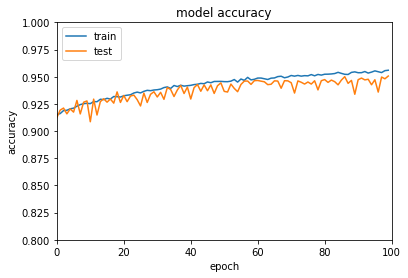

In [61]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.axis([0, 100, 0.8, 1])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

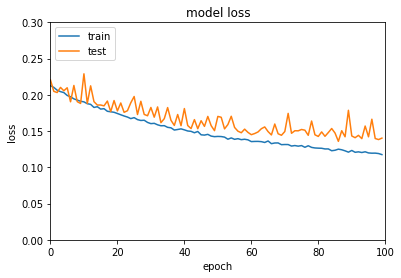

In [64]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.axis([0, 100, 0, 0.3])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
means = clf.cv_results_['split1_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

0.913 (+/-0.011) for {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adam'}
0.912 (+/-0.006) for {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adamax'}
0.497 (+/-0.001) for {'activation': 'softmax', 'epochs': 50, 'optimizer': 'SGD'}
0.908 (+/-0.035) for {'activation': 'softmax', 'epochs': 50, 'optimizer': 'RMSprop'}
0.497 (+/-0.004) for {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adadelta'}
0.921 (+/-0.009) for {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adam'}
0.917 (+/-0.006) for {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adamax'}
0.497 (+/-0.004) for {'activation': 'softmax', 'epochs': 100, 'optimizer': 'SGD'}
0.918 (+/-0.026) for {'activation': 'softmax', 'epochs': 100, 'optimizer': 'RMSprop'}
0.497 (+/-0.001) for {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adadelta'}
0.926 (+/-0.005) for {'activation': 'softmax', 'epochs': 150, 'optimizer': 'Adam'}
0.921 (+/-0.005) for {'activation': 'softmax', 'epochs': 150, 'optimizer': '

In [20]:
print(clf.cv_results_)

{'mean_fit_time': array([ 99.48231053,  97.60496751,  95.29572225,  96.57561914,
       100.68478449, 200.51633215, 194.31647396, 188.82513078,
       193.12555257, 199.5437386 , 288.88976717, 319.02153309,
       280.40824493, 287.41018621, 319.76135286,  97.66411368,
        94.91807461,  94.07752021,  92.52734129,  92.70452213,
       174.38522609, 168.41241312, 160.9057397 , 166.86077722,
       163.90433574, 252.94580317, 240.57170137, 238.520854  ,
       245.29545657, 256.78754385,  89.46609426,  84.4006803 ,
        82.7851762 ,  86.52923147,  87.20719926, 174.22285   ,
       169.63174105, 164.59539557, 164.69074686, 173.57368326,
       260.41231155, 257.29775389, 244.08776561, 249.76898917,
       253.5778079 , 118.48083631, 116.71892325, 109.18805114,
       113.08607769, 131.31517275, 285.41022682, 283.61533562,
       253.83330862, 224.15859167, 229.37499436, 360.33676076,
       421.77092783, 401.97225149, 408.35462586, 401.15015173,
        90.0707856 ,  96.34787798,  9

## Bestes Modell speichern

In [ ]:
# Mit mode.to_json wird nur die Architektur gespeichert.
# Besser: model.save()
## model_json = model.to_json()
## file_name_json = "model.json"
## file_name_h5 = "model.h5"
## with open(file_name_json, "w") as json_file:
    ## json_file.write(model_json)
## serialize weights to HDF5
##model.save_weights(file_name_h5)


save_model = ROOT_DIR+'/Optimierung_Gender_UC1/model.h5'
model.save(save_model)
print("Saved model to disk")

# Ab hier redundant bis zur Kennzeichnung

## Optimale Parameter eintragen!

In [33]:
epochs_opti = 100
optimizer_opti = 'Adam'
activation_opti = 'elu'

In [34]:
# bestes model konfigurieren
model = Sequential()
model.add(Dense (34, input_dim = 34, activation = activation_opti))
model.add (Dense (100, activation = activation_opti))
model.add (Dense (100, activation = activation_opti))
model.add (Dense (1, activation = 'sigmoid'))
model.summary()

Model: "sequential_230"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_917 (Dense)            (None, 34)                1190      
_________________________________________________________________
dense_918 (Dense)            (None, 100)               3500      
_________________________________________________________________
dense_919 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_920 (Dense)            (None, 1)                 101       
Total params: 14,891
Trainable params: 14,891
Non-trainable params: 0
_________________________________________________________________


Im nächsten Schritt wird das Modell kompiliert.
Als Loss Funktion wird die Methode "Mean Squared Error" genutzt. "Adam" wird als Optimierungsfunktion genutzt.

In [35]:
# Modell kompilieren
model.compile (loss = "binary_crossentropy", optimizer = optimizer_opti, metrics = ["binary_crossentropy","acc"])

Dann wird das Modell trainiert. Die Validierung erfolgt direkt mit dem Training mit 30% der Gesamt-Daten

In [36]:
import time

# Startzeit
t = time.localtime()
current_time = time.strftime("%d.%m.%Y %H:%M:%S", t)
print(current_time, ' Training gestartet ...\n')

# Model trainieren
history = model.fit (df_data_x, df_gender_y, epochs = epochs_opti, validation_split = 0.3)

# Endzeit
t2 = time.localtime()
current_time2 = time.strftime("%d.%m.%Y %H:%M:%S", t2)
print(' ')
print(current_time2, 'Training beendet ...')

04.05.2020 07:46:44  Training gestartet ...

Train on 39512 samples, validate on 16934 samples
Epoch 1/100
39512/39512 [==============================] - 3s 83us/step - loss: 0.6110 - binary_crossentropy: 0.6111 - acc: 0.7136 - val_loss: 1.1987 - val_binary_crossentropy: 1.1987 - val_acc: 0.0000e+00
Epoch 2/100
39512/39512 [==============================] - 3s 78us/step - loss: 0.4392 - binary_crossentropy: 0.4392 - acc: 0.7950 - val_loss: 0.6957 - val_binary_crossentropy: 0.6957 - val_acc: 0.8011
Epoch 3/100
39512/39512 [==============================] - 3s 75us/step - loss: 0.3252 - binary_crossentropy: 0.3252 - acc: 0.8713 - val_loss: 0.5185 - val_binary_crossentropy: 0.5185 - val_acc: 0.8496
Epoch 4/100
39512/39512 [==============================] - 3s 74us/step - loss: 0.3018 - binary_crossentropy: 0.3018 - acc: 0.8761 - val_loss: 0.4893 - val_binary_crossentropy: 0.4893 - val_acc: 0.8460
Epoch 5/100
39512/39512 [==============================] - 3s 74us/step - loss: 0.2857 - bina

Epoch 41/100
39512/39512 [==============================] - 3s 75us/step - loss: 0.1923 - binary_crossentropy: 0.1923 - acc: 0.9249 - val_loss: 0.2870 - val_binary_crossentropy: 0.2870 - val_acc: 0.8910
Epoch 42/100
39512/39512 [==============================] - 3s 75us/step - loss: 0.1931 - binary_crossentropy: 0.1931 - acc: 0.9243 - val_loss: 0.4292 - val_binary_crossentropy: 0.4292 - val_acc: 0.8267
Epoch 43/100
39512/39512 [==============================] - 3s 74us/step - loss: 0.1929 - binary_crossentropy: 0.1929 - acc: 0.9245 - val_loss: 0.3898 - val_binary_crossentropy: 0.3898 - val_acc: 0.8436
Epoch 44/100
39512/39512 [==============================] - 3s 76us/step - loss: 0.1907 - binary_crossentropy: 0.1907 - acc: 0.9256 - val_loss: 0.3324 - val_binary_crossentropy: 0.3324 - val_acc: 0.8705
Epoch 45/100
39512/39512 [==============================] - 3s 76us/step - loss: 0.1927 - binary_crossentropy: 0.1927 - acc: 0.9254 - val_loss: 0.2941 - val_binary_crossentropy: 0.2941 - v

In [ ]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoche')
plt.ylim(0,1)
plt.legend(['Train', 'Test'], loc='lower right')
plt

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoche')
plt.ylim (0,1)
plt.legend(['Train', 'Test'], loc='upper right')
plt

## Speichern des Modells in S3 als JSON

In [52]:
# Mit mode.to_json wird nur die Architektur gespeichert.
# Besser: model.save()
## model_json = model.to_json()
## file_name_json = "model.json"
## file_name_h5 = "model.h5"
## with open(file_name_json, "w") as json_file:
    ## json_file.write(model_json)
## serialize weights to HDF5
##model.save_weights(file_name_h5)


save_model = ROOT_DIR+'/Optimierung_Gender_UC1/model.h5'
model.save(save_model)
print("Saved model to disk")

Saved model to disk


In [ ]:
# Upload des trainieren Modells in S3

#object_key = 'Modell'
#s3 = boto3.resource('s3') 
#s3.Bucket(bucket_name).upload_file(file_name_json, object_key + '/' + file_name_json)
#s3.Bucket(bucket_name).upload_file(file_name_h5, object_key + '/' + file_name_h5)

# bis hier redundant, siehe oben - bestes Modell noch nicht getestet

# Testen des Modells mit ungelabelten Daten

Einlesen der Testdaten aus dem S3 Bucket

In [ ]:
# Laden des trainierten Modells
from keras.models import load_model

model = load_model(ROOT_DIR+'/model/model.h5')
print("Loaded model from disk")

In [ ]:
# von S3 lesen
#bucket_name = 'analyseprojectaudio'
#object_key = 'Test_Dateien/test_final_FeaturesExtracted.csv'
#s3 = boto3.client('s3')
#df_test = pd.read_csv ('s3://' + bucket_name+'/'+object_key, delimiter =';')

# von lokal lesen
df_test = pd.read_csv (ROOT_DIR+'/validation_test/test_final_FeaturesExtracted.csv', delimiter =';')

Die Input Datei für das Testen des Modells mit nicht gelabelten Daten wird analog zu den Test und Trainingsdatensätzen vorbereitet

In [ ]:
# Liste mit Spaltennamen erstellen

list_cn = df_test.columns.values
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn

In [ ]:
nrows = len(df_test)

for i in range (0,nrows):
    for j in list_cn:
        list_c = df_test[j].iloc[i]
        list_c = list_c.replace('[','')
        list_c = list_c.replace(']','')
        list1 = np.fromstring (list_c, sep=' ',dtype=float)
        df_test[j].iat[i] = list1
        df_test[j].iat[i] = df_test[j].iloc[i].mean()
    if (i % 10000 == 0):
        print ("Reihe "+ str(i) + " fertig")
print ("Konvertierung abgeschlossen.")

In [ ]:
df_test

In [ ]:
# Überflüssige Spalten entfernen

df_pred = df_test.copy()
del df_pred['Unnamed: 0']
del df_pred['index']
del df_pred['path']
del df_pred['age']
del df_pred['file_wave']
del df_pred['gender']

## Prediction der Testwerte
Die Ausgabe der Prediction gibt die vorhergesagte Klasse wieder (prediction_class)
0 = Male
1 = Female
Die Variable prediction_proba gibt die errechnete Wahrscheinlichkeit aus, dass es sich um die vorhergesagte Klasse handelt

In [ ]:
df_test['proba'] = 0
df_test['class'] = 0

for i in range (7):
    prediction = model.predict(df_pred.iloc[[i]])
    prediction_class = model.predict_classes(df_pred.iloc[[i]])
    prediction_proba = model.predict_proba(df_pred.iloc[[i]])
    df_test['proba'].iloc[i] = prediction_proba
    df_test['class'].iloc[i] = prediction_class
    # print(prediction) --> ist das gleiche wie prediction proba
    print ('Sample '+str(i)+': ')
    print (prediction_class)
    print (prediction_proba)
    print ("----------")

# Der nachfolgende Code hilft bei der Überprüfung der Prediction

In [ ]:
label_encoder = LabelEncoder()
df_test['gender_enc'] = label_encoder.fit_transform(df_test['gender'])
print(df_gender_y)

In [ ]:
df_test[['gender','gender_enc','proba','path','class']]

In [ ]:
# von lokal lesen
df_opti = pd.read_csv (ROOT_DIR+'/validation_test/test_final_FeaturesExtracted.csv', delimiter =';')